In [1]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

model_o = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=28*28, out_features=1024),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1024, out_features=10),
)

In [2]:
!nvidia-smi

Fri May 19 05:40:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   38C    P0    56W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   39C    P0    57W / 300W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# PMPHMC BNN

In [2]:
batch_size = 60000
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # 0.001
print("device: ", device)
import copy
from tqdm import tqdm

# get data
def get_data():
    train = torchvision.datasets.MNIST(root="./data", train=True, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(), # to tensor
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))  # standardization
                                       ]))
    train_loader = DataLoader(train, batch_size=batch_size)  
    test = torchvision.datasets.MNIST(root="./data", train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),  # to tensor
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))  # standardization
                                      ]))
    test_loader = DataLoader(test, batch_size=batch_size)  
    return train_loader, test_loader
train_loader, test_loader = get_data()
for _, (X, y) in enumerate(train_loader):
    X = X.reshape(batch_size,-1).to(device)
    y = y.to(device)
for _, (x_test,y_test) in enumerate(test_loader):
    x_test = x_test.reshape(10000,-1).to(device)
    y_test = y_test.to(device)

device:  cuda:0


In [3]:
import math
import copy
class bnnPMPHmc():
    def __init__(self,net,alpha,N):
        super().__init__()
        self.net = net
        self.alpha = alpha
        self.N = N
        self.d = sum(p.numel() for p in self.net.parameters())
        self.loss = torch.nn.CrossEntropyLoss().to(device)
        self.loss_list = []
        self.train_acc = []
        self.test_acc = []

    def step(self, s, p_s, nets_loss,tree_deep):
        A = torch.ones([self.N + 1, 1]).to(device)
        t_1 = torch.FloatTensor([1]).to(device)
        t_0 = torch.FloatTensor([0]).to(device)
        # 1.Calculate acceptance ratio
        for all in range(self.N + 1):
            for c in range(int(tree_deep)):
                judg = all
                j = int(math.pow(2, c + 1))
                half_j = int(j / 2)
                if judg > 0:
                    deep = int(math.log2(judg))
                while (judg > j - 1):
                    if judg >= int(math.pow(2, deep)):
                        judg = judg - int(math.pow(2, deep))
                    deep = deep - 1
                if (judg < half_j):
                    w_new = torch.exp(nets_loss[judg] - (p_s[judg][judg + half_j]*p_s[judg][judg + half_j]).sum()/2)
                    w_old = torch.exp(nets_loss[judg+half_j] - (p_s[judg+ half_j][judg ]*p_s[judg+ half_j][judg] ).sum()/2)
                    w_old = torch.min(t_1,w_old/w_new)
                    w_new = torch.max(t_0,1-w_old/w_new)
                    #print(judg+half_j,"to",judg,"  new:",ww_new,"  old:",ww_old,"  w_new:",nets_loss[judg],"  w_old:",nets_loss[judg+half_j])
                else:
                    w_new = torch.exp(nets_loss[judg] - (p_s[judg][judg - half_j]*p_s[judg][judg - half_j]).sum()/2)
                    w_old =torch.exp(nets_loss[judg-half_j] - (p_s[judg- half_j][judg ]*p_s[judg- half_j][judg] ).sum()/2)
                    w_new = torch.min(t_1,w_new/w_old)
                    w_old = torch.max(t_0,1-w_new/w_old)
                    #print(judg-half_j,"to",judg,"  new:",ww_new," old:",ww_old,"  w_new:",nets_loss[judg],"  w_old:",nets_loss[judg-half_j])
                A[all, 0] = A[all, 0] * w_new / (w_new + w_old)
            #print(A[all,0])
  
        # 2. Sampling by acceptance rate
        B = A.reshape(-1)
        B = torch.where(torch.isnan(B), torch.full_like(B, 1), B)
        B = torch.where(torch.isinf(B), torch.full_like(B, 1), B)
        I = torch.multinomial(B, 1, replacement=True).data
        return I
    def fit(self, num_steps=1000,step_size=0.1):
        trajectory = []
        print("-------PMP HMC Optimizer------ ")
        tree_deep = math.log2(self.N + 1)
        # parameters, number of networks
        proposal_nets = [1] * (self.N + 1) # store each network
        p_s = torch.empty(self.N+1,self.N+1,self.d).to(device) # store the speed of the network p :p[i][j] indicates the speed of i when used for i to j
        nets_loss = [1] * (self.N + 1) # store the loss of each network

        for s in tqdm(range(num_steps)):
            proposal_nets[0] = copy.deepcopy(self.net).to(device) 
            # Initialize to generate N proposal networks (can be parallelized)
            for i in range(int(tree_deep)):
                j = int(math.pow(2, i))
                for k in range(int(j)):
                    p_s[k][k+j] = torch.randn(self.d).to(device) * 0.0005 # Randomly choose the original speed
                    proposal_nets[k+j] = copy.deepcopy(proposal_nets[k]).to(device)
                    p_s[k+j][k]= copy.deepcopy(p_s[k][k+j])

                    # Calculate potential energy  U(x)=-log(p(x))
                    yhat = proposal_nets[k](X)
                    nets_loss[k] = - self.loss(yhat, y)
                    # Calculate du_dx
                    nets_loss[k].backward()
                    du_dx = torch.tensor([]).to(device)
                    for par in proposal_nets[k].parameters():
                        par = par.grad.reshape(-1)
                        shape = par.shape[0]
                        du_dx = torch.cat([du_dx, par.reshape(shape, 1)])
                    du_dx = du_dx.reshape(self.d)
                    # leapfrog dynamic iteration
                    # 1. P take a half step
                    p_s[k+j][k] +=  step_size * du_dx / 2
                    # 2. Parameters go one step
                    sum = 0
                    for par in proposal_nets[k+j].parameters():
                        size = par.numel()
                        par.data += step_size * p_s[k+j][k][sum:sum + size].reshape(par.data.shape)
                        sum += size
                        # 3.Update the parameters required in the second half of the step
                    yhat = proposal_nets[k+j](X)
                    nets_loss[k+j] = - self.loss(yhat, y)
                    nets_loss[k+j].backward()
                    du_dx = torch.tensor([]).to(device)
                    for par in proposal_nets[j+k].parameters():
                        par = par.grad.reshape(-1)
                        shape = par.shape[0]
                        du_dx = torch.cat([du_dx, par.reshape(shape, 1)])
                    # 4. take half a step
                    du_dx = du_dx.reshape(self.d)
                    p_s[k+j][k] +=  step_size * du_dx / 2
            I = self.step(s,p_s,nets_loss,tree_deep)
            self.net = proposal_nets[I]
            self.loss_list.append(- nets_loss[I].cpu().item())
            if s%50==0:
                print("epoch",s,"loss = ",- nets_loss[I].cpu().item())
                correct = (self.net(X).argmax(1) == y).type(torch.float).sum().item()
                self.train_acc.append(correct / 60000)
                print("train_acc:",correct / 60000)
            
                correct = (self.net(x_test).argmax(1) == y_test).type(torch.float).sum().item()
                self.test_acc.append(correct / 10000)
                print("test_acc:",correct / 10000)

              
            # 记录每个参数的值
            parameters = torch.cat([param.view(-1) for param in self.net.parameters()])
            trajectory.append(parameters.cpu()[:10].detach().numpy().tolist())
        return np.array(self.loss_list),np.array(self.train_acc), np.array(self.test_acc),trajectory

In [4]:
model_PMPhmc = copy.deepcopy(model_o)
model_PMPhmc = model_PMPhmc.to(device)
alpha = 0.001
num_steps = 30000
N = 7
trainer = bnnPMPHmc(net = model_PMPhmc, alpha=alpha,N=N)
loss,train_acc,test_acc,samples = trainer.fit(num_steps=num_steps)

# save data
np.save('mnist_PMPhmc_loss'+'.npy', loss)
np.save('mnist_PMPhmc_train_acc'+'.npy', train_acc)
np.save('mnist_PMPhmc_test_acc'+'.npy', test_acc)
np.save('mnist_PMPhmc_samples'+'.npy', samples)

  0%|          | 0/30000 [00:00<?, ?it/s]

-------PMP HMC Optimizer------ 


  0%|          | 1/30000 [00:00<4:54:05,  1.70it/s]

epoch 0 loss =  10.069243431091309
train_acc: 0.15338333333333334
test_acc: 0.1426


  0%|          | 51/30000 [00:17<2:51:05,  2.92it/s]

epoch 50 loss =  7.144386291503906
train_acc: 0.20018333333333332
test_acc: 0.1514


  0%|          | 101/30000 [00:34<2:50:07,  2.93it/s]

epoch 100 loss =  5.362961292266846
train_acc: 0.29893333333333333
test_acc: 0.3485


  1%|          | 151/30000 [00:51<2:49:39,  2.93it/s]

epoch 150 loss =  2.57519793510437
train_acc: 0.5173166666666666
test_acc: 0.5001


  1%|          | 201/30000 [01:08<2:49:28,  2.93it/s]

epoch 200 loss =  2.378551483154297
train_acc: 0.60445
test_acc: 0.5481


  1%|          | 251/30000 [01:25<2:49:32,  2.92it/s]

epoch 250 loss =  2.1672005653381348
train_acc: 0.6218
test_acc: 0.6011


  1%|          | 301/30000 [01:42<2:48:56,  2.93it/s]

epoch 300 loss =  1.6861847639083862
train_acc: 0.5900166666666666
test_acc: 0.6507


  1%|          | 351/30000 [01:58<2:48:54,  2.93it/s]

epoch 350 loss =  1.7861220836639404
train_acc: 0.6594
test_acc: 0.7031


  1%|▏         | 401/30000 [02:15<2:48:12,  2.93it/s]

epoch 400 loss =  1.6771823167800903
train_acc: 0.6687
test_acc: 0.7126


  2%|▏         | 451/30000 [02:32<2:48:07,  2.93it/s]

epoch 450 loss =  1.165269374847412
train_acc: 0.7164166666666667
test_acc: 0.7145


  2%|▏         | 501/30000 [02:49<2:47:49,  2.93it/s]

epoch 500 loss =  1.3521323204040527
train_acc: 0.7541166666666667
test_acc: 0.7223


  2%|▏         | 551/30000 [03:06<2:48:05,  2.92it/s]

epoch 550 loss =  1.5125032663345337
train_acc: 0.7370833333333333
test_acc: 0.7556


  2%|▏         | 601/30000 [03:23<2:47:38,  2.92it/s]

epoch 600 loss =  1.3158656358718872
train_acc: 0.7399833333333333
test_acc: 0.762


  2%|▏         | 651/30000 [03:40<2:47:20,  2.92it/s]

epoch 650 loss =  0.9655691385269165
train_acc: 0.7637
test_acc: 0.7148


  2%|▏         | 701/30000 [03:57<2:47:08,  2.92it/s]

epoch 700 loss =  0.997684895992279
train_acc: 0.7722166666666667
test_acc: 0.7567


  3%|▎         | 751/30000 [04:14<2:46:34,  2.93it/s]

epoch 750 loss =  1.0838077068328857
train_acc: 0.7769333333333334
test_acc: 0.7706


  3%|▎         | 801/30000 [04:31<2:46:21,  2.93it/s]

epoch 800 loss =  1.1194947957992554
train_acc: 0.7544333333333333
test_acc: 0.8121


  3%|▎         | 851/30000 [04:48<2:46:03,  2.93it/s]

epoch 850 loss =  1.0889912843704224
train_acc: 0.8130833333333334
test_acc: 0.7797


  3%|▎         | 901/30000 [05:05<2:46:16,  2.92it/s]

epoch 900 loss =  1.134237289428711
train_acc: 0.7303833333333334
test_acc: 0.7713


  3%|▎         | 951/30000 [05:22<2:45:42,  2.92it/s]

epoch 950 loss =  0.8597670793533325
train_acc: 0.7896833333333333
test_acc: 0.7478


  3%|▎         | 1001/30000 [05:39<2:44:50,  2.93it/s]

epoch 1000 loss =  1.1132911443710327
train_acc: 0.7625166666666666
test_acc: 0.7196


  4%|▎         | 1051/30000 [05:56<2:44:50,  2.93it/s]

epoch 1050 loss =  1.096913456916809
train_acc: 0.8113833333333333
test_acc: 0.8051


  4%|▎         | 1101/30000 [06:12<2:44:38,  2.93it/s]

epoch 1100 loss =  0.8985407948493958
train_acc: 0.8058166666666666
test_acc: 0.7931


  4%|▍         | 1151/30000 [06:29<2:44:27,  2.92it/s]

epoch 1150 loss =  0.8072068095207214
train_acc: 0.82185
test_acc: 0.8299


  4%|▍         | 1201/30000 [06:46<2:43:51,  2.93it/s]

epoch 1200 loss =  0.7496573328971863
train_acc: 0.8159833333333333
test_acc: 0.7999


  4%|▍         | 1251/30000 [07:03<2:44:04,  2.92it/s]

epoch 1250 loss =  0.9383037090301514
train_acc: 0.7951333333333334
test_acc: 0.7859


  4%|▍         | 1301/30000 [07:20<2:43:50,  2.92it/s]

epoch 1300 loss =  0.8113250732421875
train_acc: 0.7909333333333334
test_acc: 0.8067


  5%|▍         | 1351/30000 [07:37<2:43:15,  2.92it/s]

epoch 1350 loss =  0.8410519957542419
train_acc: 0.82125
test_acc: 0.8088


  5%|▍         | 1401/30000 [07:54<2:43:08,  2.92it/s]

epoch 1400 loss =  0.6908932328224182
train_acc: 0.8189833333333333
test_acc: 0.8307


  5%|▍         | 1451/30000 [08:11<2:42:38,  2.93it/s]

epoch 1450 loss =  0.8281476497650146
train_acc: 0.8380166666666666
test_acc: 0.8015


  5%|▌         | 1501/30000 [08:28<2:41:43,  2.94it/s]

epoch 1500 loss =  0.739112377166748
train_acc: 0.8041
test_acc: 0.8471


  5%|▌         | 1551/30000 [08:45<2:41:40,  2.93it/s]

epoch 1550 loss =  0.7498822212219238
train_acc: 0.8183833333333334
test_acc: 0.8134


  5%|▌         | 1601/30000 [09:02<2:41:27,  2.93it/s]

epoch 1600 loss =  0.8397077322006226
train_acc: 0.8073666666666667
test_acc: 0.8257


  6%|▌         | 1651/30000 [09:19<2:41:14,  2.93it/s]

epoch 1650 loss =  0.7937846779823303
train_acc: 0.8343833333333334
test_acc: 0.8259


  6%|▌         | 1701/30000 [09:36<2:41:01,  2.93it/s]

epoch 1700 loss =  0.8408074378967285
train_acc: 0.8220666666666666
test_acc: 0.815


  6%|▌         | 1751/30000 [09:52<2:40:38,  2.93it/s]

epoch 1750 loss =  0.6334227323532104
train_acc: 0.8021166666666667
test_acc: 0.8259


  6%|▌         | 1801/30000 [10:09<2:40:58,  2.92it/s]

epoch 1800 loss =  0.6665608286857605
train_acc: 0.8431
test_acc: 0.8153


  6%|▌         | 1851/30000 [10:26<2:40:05,  2.93it/s]

epoch 1850 loss =  0.6668137907981873
train_acc: 0.8231333333333334
test_acc: 0.8198


  6%|▋         | 1901/30000 [10:43<2:39:32,  2.94it/s]

epoch 1900 loss =  0.6787221431732178
train_acc: 0.8118833333333333
test_acc: 0.8482


  7%|▋         | 1951/30000 [11:00<2:39:26,  2.93it/s]

epoch 1950 loss =  0.7056043744087219
train_acc: 0.8243666666666667
test_acc: 0.8217


  7%|▋         | 2001/30000 [11:17<2:39:48,  2.92it/s]

epoch 2000 loss =  0.6326927542686462
train_acc: 0.8406
test_acc: 0.8589


  7%|▋         | 2051/30000 [11:34<2:39:02,  2.93it/s]

epoch 2050 loss =  0.663899302482605
train_acc: 0.83785
test_acc: 0.8499


  7%|▋         | 2101/30000 [11:51<2:38:27,  2.93it/s]

epoch 2100 loss =  0.6736334562301636
train_acc: 0.8214333333333333
test_acc: 0.8537


  7%|▋         | 2151/30000 [12:08<2:38:32,  2.93it/s]

epoch 2150 loss =  0.6555325984954834
train_acc: 0.8478333333333333
test_acc: 0.8671


  7%|▋         | 2201/30000 [12:25<2:38:25,  2.92it/s]

epoch 2200 loss =  0.593427836894989
train_acc: 0.84095
test_acc: 0.8139


  8%|▊         | 2251/30000 [12:41<2:37:48,  2.93it/s]

epoch 2250 loss =  0.6462300419807434
train_acc: 0.8227833333333333
test_acc: 0.8528


  8%|▊         | 2301/30000 [12:58<2:37:22,  2.93it/s]

epoch 2300 loss =  0.6229971647262573
train_acc: 0.8635333333333334
test_acc: 0.8315


  8%|▊         | 2351/30000 [13:15<2:37:00,  2.94it/s]

epoch 2350 loss =  0.5898597836494446
train_acc: 0.8390833333333333
test_acc: 0.8535


  8%|▊         | 2401/30000 [13:32<2:36:52,  2.93it/s]

epoch 2400 loss =  0.5735063552856445
train_acc: 0.8594166666666667
test_acc: 0.8459


  8%|▊         | 2451/30000 [13:49<2:36:39,  2.93it/s]

epoch 2450 loss =  0.6453778147697449
train_acc: 0.8459833333333333
test_acc: 0.8481


  8%|▊         | 2501/30000 [14:06<2:36:41,  2.92it/s]

epoch 2500 loss =  0.5609028935432434
train_acc: 0.85325
test_acc: 0.8461


  9%|▊         | 2551/30000 [14:23<2:36:16,  2.93it/s]

epoch 2550 loss =  0.5374150276184082
train_acc: 0.8413
test_acc: 0.8739


  9%|▊         | 2601/30000 [14:40<2:37:15,  2.90it/s]

epoch 2600 loss =  0.5725668668746948
train_acc: 0.8648833333333333
test_acc: 0.8303


  9%|▉         | 2651/30000 [14:57<2:37:49,  2.89it/s]

epoch 2650 loss =  0.6631283760070801
train_acc: 0.8618166666666667
test_acc: 0.8704


  9%|▉         | 2701/30000 [15:14<2:39:02,  2.86it/s]

epoch 2700 loss =  0.5524981021881104
train_acc: 0.8239833333333333
test_acc: 0.8381


  9%|▉         | 2751/30000 [15:32<2:39:00,  2.86it/s]

epoch 2750 loss =  0.5882434248924255
train_acc: 0.85365
test_acc: 0.8446


  9%|▉         | 2801/30000 [15:49<2:38:27,  2.86it/s]

epoch 2800 loss =  0.5704623460769653
train_acc: 0.8589833333333333
test_acc: 0.87


 10%|▉         | 2851/30000 [16:06<2:37:56,  2.87it/s]

epoch 2850 loss =  0.47969087958335876
train_acc: 0.8553166666666666
test_acc: 0.8654


 10%|▉         | 2901/30000 [16:23<2:37:32,  2.87it/s]

epoch 2900 loss =  0.5226104855537415
train_acc: 0.8359833333333333
test_acc: 0.8674


 10%|▉         | 2951/30000 [16:41<2:37:25,  2.86it/s]

epoch 2950 loss =  0.46655261516571045
train_acc: 0.8439666666666666
test_acc: 0.8741


 10%|█         | 3001/30000 [16:58<2:36:56,  2.87it/s]

epoch 3000 loss =  0.604430079460144
train_acc: 0.86315
test_acc: 0.88


 10%|█         | 3051/30000 [17:15<2:36:50,  2.86it/s]

epoch 3050 loss =  0.48421403765678406
train_acc: 0.8270666666666666
test_acc: 0.8705


 10%|█         | 3101/30000 [17:32<2:36:26,  2.87it/s]

epoch 3100 loss =  0.5099161267280579
train_acc: 0.8686166666666667
test_acc: 0.8694


 11%|█         | 3151/30000 [17:50<2:35:57,  2.87it/s]

epoch 3150 loss =  0.6142903566360474
train_acc: 0.87295
test_acc: 0.8582


 11%|█         | 3201/30000 [18:07<2:36:16,  2.86it/s]

epoch 3200 loss =  0.4457148313522339
train_acc: 0.8596166666666667
test_acc: 0.8826


 11%|█         | 3251/30000 [18:24<2:37:14,  2.84it/s]

epoch 3250 loss =  0.6330296993255615
train_acc: 0.8583666666666666
test_acc: 0.8813


 11%|█         | 3301/30000 [18:42<2:35:01,  2.87it/s]

epoch 3300 loss =  0.6006444096565247
train_acc: 0.8795666666666667
test_acc: 0.8703


 11%|█         | 3351/30000 [18:59<2:34:41,  2.87it/s]

epoch 3350 loss =  0.5023549795150757
train_acc: 0.8679833333333333
test_acc: 0.8835


 11%|█▏        | 3401/30000 [19:16<2:34:54,  2.86it/s]

epoch 3400 loss =  0.5169265866279602
train_acc: 0.8764833333333333
test_acc: 0.8588


 12%|█▏        | 3451/30000 [19:34<2:33:46,  2.88it/s]

epoch 3450 loss =  0.49541324377059937
train_acc: 0.83615
test_acc: 0.8534


 12%|█▏        | 3501/30000 [19:51<2:33:00,  2.89it/s]

epoch 3500 loss =  0.4745936095714569
train_acc: 0.8680666666666667
test_acc: 0.8704


 12%|█▏        | 3551/30000 [20:08<2:31:53,  2.90it/s]

epoch 3550 loss =  0.5208089351654053
train_acc: 0.8783166666666666
test_acc: 0.8696


 12%|█▏        | 3601/30000 [20:25<2:30:26,  2.92it/s]

epoch 3600 loss =  0.5000333786010742
train_acc: 0.8753333333333333
test_acc: 0.8729


 12%|█▏        | 3651/30000 [20:42<2:30:01,  2.93it/s]

epoch 3650 loss =  0.4874117970466614
train_acc: 0.8695166666666667
test_acc: 0.8681


 12%|█▏        | 3701/30000 [20:59<2:29:38,  2.93it/s]

epoch 3700 loss =  0.6111667156219482
train_acc: 0.8797166666666667
test_acc: 0.8766


 13%|█▎        | 3751/30000 [21:16<2:29:35,  2.92it/s]

epoch 3750 loss =  0.5048224329948425
train_acc: 0.8694333333333333
test_acc: 0.8891


 13%|█▎        | 3801/30000 [21:33<2:31:05,  2.89it/s]

epoch 3800 loss =  0.43551042675971985
train_acc: 0.8794333333333333
test_acc: 0.8853


 13%|█▎        | 3851/30000 [21:50<2:30:41,  2.89it/s]

epoch 3850 loss =  0.4932343363761902
train_acc: 0.8787
test_acc: 0.8712


 13%|█▎        | 3901/30000 [22:07<2:30:30,  2.89it/s]

epoch 3900 loss =  0.47370660305023193
train_acc: 0.8581166666666666
test_acc: 0.8662


 13%|█▎        | 3951/30000 [22:24<2:31:24,  2.87it/s]

epoch 3950 loss =  0.43443602323532104
train_acc: 0.8701333333333333
test_acc: 0.8914


 13%|█▎        | 4001/30000 [22:41<2:31:44,  2.86it/s]

epoch 4000 loss =  0.4547835886478424
train_acc: 0.8918666666666667
test_acc: 0.8551


 14%|█▎        | 4051/30000 [22:59<2:31:22,  2.86it/s]

epoch 4050 loss =  0.4376123249530792
train_acc: 0.8241833333333334
test_acc: 0.88


 14%|█▎        | 4101/30000 [23:16<2:30:32,  2.87it/s]

epoch 4100 loss =  0.44249212741851807
train_acc: 0.8578666666666667
test_acc: 0.8868


 14%|█▍        | 4151/30000 [23:33<2:30:06,  2.87it/s]

epoch 4150 loss =  0.4434508681297302
train_acc: 0.8863666666666666
test_acc: 0.8825


 14%|█▍        | 4201/30000 [23:51<2:30:37,  2.85it/s]

epoch 4200 loss =  0.5024173259735107
train_acc: 0.8745833333333334
test_acc: 0.8822


 14%|█▍        | 4251/30000 [24:08<2:29:29,  2.87it/s]

epoch 4250 loss =  0.4467366635799408
train_acc: 0.8700833333333333
test_acc: 0.8894


 14%|█▍        | 4301/30000 [24:25<2:29:47,  2.86it/s]

epoch 4300 loss =  0.511725664138794
train_acc: 0.8879
test_acc: 0.8769


 15%|█▍        | 4351/30000 [24:43<2:29:16,  2.86it/s]

epoch 4350 loss =  0.45593956112861633
train_acc: 0.86795
test_acc: 0.8425


 15%|█▍        | 4401/30000 [25:00<2:28:47,  2.87it/s]

epoch 4400 loss =  0.428680956363678
train_acc: 0.8836333333333334
test_acc: 0.8718


 15%|█▍        | 4451/30000 [25:17<2:28:22,  2.87it/s]

epoch 4450 loss =  0.5020893812179565
train_acc: 0.87765
test_acc: 0.8682


 15%|█▌        | 4501/30000 [25:34<2:28:21,  2.86it/s]

epoch 4500 loss =  0.4414610266685486
train_acc: 0.8839166666666667
test_acc: 0.8803


 15%|█▌        | 4551/30000 [25:52<2:28:18,  2.86it/s]

epoch 4550 loss =  0.489443302154541
train_acc: 0.8929833333333334
test_acc: 0.8849


 15%|█▌        | 4601/30000 [26:09<2:28:36,  2.85it/s]

epoch 4600 loss =  0.4068463444709778
train_acc: 0.8930666666666667
test_acc: 0.8652


 16%|█▌        | 4651/30000 [26:26<2:26:42,  2.88it/s]

epoch 4650 loss =  0.42849645018577576
train_acc: 0.8842
test_acc: 0.8948


 16%|█▌        | 4701/30000 [26:43<2:25:39,  2.89it/s]

epoch 4700 loss =  0.40478795766830444
train_acc: 0.8854333333333333
test_acc: 0.8866


 16%|█▌        | 4751/30000 [27:00<2:23:33,  2.93it/s]

epoch 4750 loss =  0.5204809904098511
train_acc: 0.8843166666666666
test_acc: 0.8819


 16%|█▌        | 4801/30000 [27:17<2:23:06,  2.93it/s]

epoch 4800 loss =  0.4138454794883728
train_acc: 0.8940833333333333
test_acc: 0.8858


 16%|█▌        | 4851/30000 [27:34<2:23:10,  2.93it/s]

epoch 4850 loss =  0.5661359429359436
train_acc: 0.9020333333333334
test_acc: 0.8857


 16%|█▋        | 4901/30000 [27:51<2:22:28,  2.94it/s]

epoch 4900 loss =  0.558932900428772
train_acc: 0.8783
test_acc: 0.8957


 17%|█▋        | 4951/30000 [28:08<2:22:07,  2.94it/s]

epoch 4950 loss =  0.435660183429718
train_acc: 0.8922833333333333
test_acc: 0.8816


 17%|█▋        | 5001/30000 [28:25<2:22:04,  2.93it/s]

epoch 5000 loss =  0.4054572284221649
train_acc: 0.87425
test_acc: 0.8872


 17%|█▋        | 5051/30000 [28:41<2:21:58,  2.93it/s]

epoch 5050 loss =  0.4173451364040375
train_acc: 0.8927166666666667
test_acc: 0.902


 17%|█▋        | 5101/30000 [28:58<2:21:47,  2.93it/s]

epoch 5100 loss =  0.3867529630661011
train_acc: 0.884
test_acc: 0.8786


 17%|█▋        | 5151/30000 [29:15<2:21:09,  2.93it/s]

epoch 5150 loss =  0.4578079879283905
train_acc: 0.89885
test_acc: 0.8923


 17%|█▋        | 5201/30000 [29:32<2:21:02,  2.93it/s]

epoch 5200 loss =  0.3843367397785187
train_acc: 0.8866833333333334
test_acc: 0.8732


 18%|█▊        | 5251/30000 [29:49<2:20:34,  2.93it/s]

epoch 5250 loss =  0.4323556125164032
train_acc: 0.88635
test_acc: 0.8963


 18%|█▊        | 5301/30000 [30:06<2:20:07,  2.94it/s]

epoch 5300 loss =  0.49144089221954346
train_acc: 0.8874666666666666
test_acc: 0.8887


 18%|█▊        | 5351/30000 [30:23<2:20:22,  2.93it/s]

epoch 5350 loss =  0.4181641936302185
train_acc: 0.894
test_acc: 0.8968


 18%|█▊        | 5401/30000 [30:40<2:19:35,  2.94it/s]

epoch 5400 loss =  0.3800489604473114
train_acc: 0.8958
test_acc: 0.9


 18%|█▊        | 5451/30000 [30:57<2:19:27,  2.93it/s]

epoch 5450 loss =  0.466433584690094
train_acc: 0.8998666666666667
test_acc: 0.896


 18%|█▊        | 5501/30000 [31:14<2:21:06,  2.89it/s]

epoch 5500 loss =  0.40249648690223694
train_acc: 0.88915
test_acc: 0.8962


 19%|█▊        | 5551/30000 [31:31<2:21:48,  2.87it/s]

epoch 5550 loss =  0.39963385462760925
train_acc: 0.8958833333333334
test_acc: 0.9043


 19%|█▊        | 5601/30000 [31:48<2:20:23,  2.90it/s]

epoch 5600 loss =  0.38681653141975403
train_acc: 0.8736666666666667
test_acc: 0.9044


 19%|█▉        | 5651/30000 [32:05<2:20:15,  2.89it/s]

epoch 5650 loss =  0.3555290997028351
train_acc: 0.8891333333333333
test_acc: 0.8905


 19%|█▉        | 5701/30000 [32:22<2:19:47,  2.90it/s]

epoch 5700 loss =  0.3717011511325836
train_acc: 0.9043666666666667
test_acc: 0.8905


 19%|█▉        | 5751/30000 [32:39<2:19:31,  2.90it/s]

epoch 5750 loss =  0.42516660690307617
train_acc: 0.9017666666666667
test_acc: 0.9024


 19%|█▉        | 5801/30000 [32:56<2:18:57,  2.90it/s]

epoch 5800 loss =  0.33624929189682007
train_acc: 0.8870166666666667
test_acc: 0.898


 20%|█▉        | 5851/30000 [33:13<2:18:51,  2.90it/s]

epoch 5850 loss =  0.3593105375766754
train_acc: 0.9050333333333334
test_acc: 0.8819


 20%|█▉        | 5901/30000 [33:30<2:18:53,  2.89it/s]

epoch 5900 loss =  0.3644868731498718
train_acc: 0.9035666666666666
test_acc: 0.8946


 20%|█▉        | 5951/30000 [33:47<2:18:16,  2.90it/s]

epoch 5950 loss =  0.3584182858467102
train_acc: 0.8864
test_acc: 0.8822


 20%|██        | 6001/30000 [34:05<2:18:03,  2.90it/s]

epoch 6000 loss =  0.36496907472610474
train_acc: 0.8854833333333333
test_acc: 0.9002


 20%|██        | 6051/30000 [34:22<2:17:29,  2.90it/s]

epoch 6050 loss =  0.3327651023864746
train_acc: 0.90065
test_acc: 0.8965


 20%|██        | 6101/30000 [34:39<2:17:19,  2.90it/s]

epoch 6100 loss =  0.3726372718811035
train_acc: 0.9035166666666666
test_acc: 0.8952


 21%|██        | 6151/30000 [34:56<2:16:48,  2.91it/s]

epoch 6150 loss =  0.42832499742507935
train_acc: 0.9023666666666667
test_acc: 0.8998


 21%|██        | 6201/30000 [35:13<2:16:24,  2.91it/s]

epoch 6200 loss =  0.35066142678260803
train_acc: 0.9055833333333333
test_acc: 0.9056


 21%|██        | 6251/30000 [35:30<2:15:06,  2.93it/s]

epoch 6250 loss =  0.35091087222099304
train_acc: 0.9081166666666667
test_acc: 0.9011


 21%|██        | 6301/30000 [35:47<2:14:38,  2.93it/s]

epoch 6300 loss =  0.36019307374954224
train_acc: 0.9043666666666667
test_acc: 0.9021


 21%|██        | 6351/30000 [36:04<2:14:16,  2.94it/s]

epoch 6350 loss =  0.3418337106704712
train_acc: 0.8879666666666667
test_acc: 0.8992


 21%|██▏       | 6401/30000 [36:20<2:14:08,  2.93it/s]

epoch 6400 loss =  0.33861464262008667
train_acc: 0.9070666666666667
test_acc: 0.8987


 22%|██▏       | 6451/30000 [36:37<2:13:54,  2.93it/s]

epoch 6450 loss =  0.3327903747558594
train_acc: 0.9056333333333333
test_acc: 0.9131


 22%|██▏       | 6501/30000 [36:54<2:13:22,  2.94it/s]

epoch 6500 loss =  0.3234558701515198
train_acc: 0.9091
test_acc: 0.8967


 22%|██▏       | 6551/30000 [37:11<2:13:18,  2.93it/s]

epoch 6550 loss =  0.344167560338974
train_acc: 0.9035833333333333
test_acc: 0.9012


 22%|██▏       | 6601/30000 [37:28<2:12:50,  2.94it/s]

epoch 6600 loss =  0.36222320795059204
train_acc: 0.89485
test_acc: 0.8771


 22%|██▏       | 6651/30000 [37:45<2:12:43,  2.93it/s]

epoch 6650 loss =  0.32223886251449585
train_acc: 0.90965
test_acc: 0.8858


 22%|██▏       | 6701/30000 [38:02<2:12:17,  2.94it/s]

epoch 6700 loss =  0.3290996849536896
train_acc: 0.9098833333333334
test_acc: 0.9022


 23%|██▎       | 6751/30000 [38:19<2:12:02,  2.93it/s]

epoch 6750 loss =  0.3542579412460327
train_acc: 0.90285
test_acc: 0.913


 23%|██▎       | 6801/30000 [38:36<2:11:52,  2.93it/s]

epoch 6800 loss =  0.3243395686149597
train_acc: 0.9042333333333333
test_acc: 0.8982


 23%|██▎       | 6851/30000 [38:52<2:11:28,  2.93it/s]

epoch 6850 loss =  0.3651215434074402
train_acc: 0.8819833333333333
test_acc: 0.9079


 23%|██▎       | 6901/30000 [39:09<2:11:14,  2.93it/s]

epoch 6900 loss =  0.3125581443309784
train_acc: 0.8951666666666667
test_acc: 0.9091


 23%|██▎       | 6951/30000 [39:26<2:10:52,  2.94it/s]

epoch 6950 loss =  0.3600478172302246
train_acc: 0.8830166666666667
test_acc: 0.8981


 23%|██▎       | 7001/30000 [39:43<2:10:56,  2.93it/s]

epoch 7000 loss =  0.33862540125846863
train_acc: 0.9175166666666666
test_acc: 0.9064


 24%|██▎       | 7051/30000 [40:00<2:10:19,  2.93it/s]

epoch 7050 loss =  0.3819735050201416
train_acc: 0.9088833333333334
test_acc: 0.9029


 24%|██▎       | 7101/30000 [40:17<2:09:51,  2.94it/s]

epoch 7100 loss =  0.33716854453086853
train_acc: 0.9144333333333333
test_acc: 0.9042


 24%|██▍       | 7151/30000 [40:34<2:10:02,  2.93it/s]

epoch 7150 loss =  0.33580490946769714
train_acc: 0.90295
test_acc: 0.902


 24%|██▍       | 7201/30000 [40:51<2:09:25,  2.94it/s]

epoch 7200 loss =  0.3561080992221832
train_acc: 0.9043
test_acc: 0.8915


 24%|██▍       | 7251/30000 [41:08<2:09:07,  2.94it/s]

epoch 7250 loss =  0.3583114445209503
train_acc: 0.9098333333333334
test_acc: 0.9001


 24%|██▍       | 7301/30000 [41:24<2:08:59,  2.93it/s]

epoch 7300 loss =  0.3581290543079376
train_acc: 0.9020833333333333
test_acc: 0.9028


 25%|██▍       | 7351/30000 [41:41<2:09:26,  2.92it/s]

epoch 7350 loss =  0.3358170688152313
train_acc: 0.9019666666666667
test_acc: 0.9198


 25%|██▍       | 7401/30000 [41:58<2:08:29,  2.93it/s]

epoch 7400 loss =  0.3377784788608551
train_acc: 0.9106833333333333
test_acc: 0.9122


 25%|██▍       | 7451/30000 [42:15<2:08:00,  2.94it/s]

epoch 7450 loss =  0.3432113528251648
train_acc: 0.9101833333333333
test_acc: 0.9089


 25%|██▌       | 7501/30000 [42:32<2:07:40,  2.94it/s]

epoch 7500 loss =  0.29541489481925964
train_acc: 0.9098666666666667
test_acc: 0.9069


 25%|██▌       | 7551/30000 [42:49<2:07:31,  2.93it/s]

epoch 7550 loss =  0.3211095631122589
train_acc: 0.9007333333333334
test_acc: 0.9004


 25%|██▌       | 7601/30000 [43:06<2:07:15,  2.93it/s]

epoch 7600 loss =  0.3212977647781372
train_acc: 0.9056333333333333
test_acc: 0.9145


 26%|██▌       | 7651/30000 [43:23<2:06:53,  2.94it/s]

epoch 7650 loss =  0.31928983330726624
train_acc: 0.9116666666666666
test_acc: 0.9253


 26%|██▌       | 7701/30000 [43:39<2:07:19,  2.92it/s]

epoch 7700 loss =  0.2938409447669983
train_acc: 0.9077
test_acc: 0.9065


 26%|██▌       | 7751/30000 [43:56<2:06:35,  2.93it/s]

epoch 7750 loss =  0.34182706475257874
train_acc: 0.9040166666666667
test_acc: 0.9245


 26%|██▌       | 7801/30000 [44:13<2:06:26,  2.93it/s]

epoch 7800 loss =  0.3474354147911072
train_acc: 0.9056833333333333
test_acc: 0.9069


 26%|██▌       | 7851/30000 [44:30<2:05:45,  2.94it/s]

epoch 7850 loss =  0.29376137256622314
train_acc: 0.90795
test_acc: 0.9078


 26%|██▋       | 7901/30000 [44:47<2:05:25,  2.94it/s]

epoch 7900 loss =  0.32668909430503845
train_acc: 0.9133833333333333
test_acc: 0.9126


 27%|██▋       | 7951/30000 [45:04<2:05:35,  2.93it/s]

epoch 7950 loss =  0.3204195499420166
train_acc: 0.9065833333333333
test_acc: 0.9093


 27%|██▋       | 8001/30000 [45:21<2:05:32,  2.92it/s]

epoch 8000 loss =  0.3044166564941406
train_acc: 0.9207333333333333
test_acc: 0.9204


 27%|██▋       | 8051/30000 [45:38<2:05:20,  2.92it/s]

epoch 8050 loss =  0.3015160858631134
train_acc: 0.9108166666666667
test_acc: 0.914


 27%|██▋       | 8101/30000 [45:55<2:04:30,  2.93it/s]

epoch 8100 loss =  0.2993471920490265
train_acc: 0.9122333333333333
test_acc: 0.9143


 27%|██▋       | 8151/30000 [46:12<2:04:04,  2.93it/s]

epoch 8150 loss =  0.2896377742290497
train_acc: 0.91755
test_acc: 0.9148


 27%|██▋       | 8201/30000 [46:29<2:03:53,  2.93it/s]

epoch 8200 loss =  0.29391029477119446
train_acc: 0.9167166666666666
test_acc: 0.9106


 28%|██▊       | 8251/30000 [46:45<2:04:02,  2.92it/s]

epoch 8250 loss =  0.31872454285621643
train_acc: 0.9124666666666666
test_acc: 0.9233


 28%|██▊       | 8301/30000 [47:02<2:03:13,  2.94it/s]

epoch 8300 loss =  0.40785661339759827
train_acc: 0.9207833333333333
test_acc: 0.892


 28%|██▊       | 8351/30000 [47:19<2:02:56,  2.94it/s]

epoch 8350 loss =  0.3134302496910095
train_acc: 0.9144
test_acc: 0.9163


 28%|██▊       | 8401/30000 [47:36<2:02:47,  2.93it/s]

epoch 8400 loss =  0.29531973600387573
train_acc: 0.9185166666666666
test_acc: 0.9096


 28%|██▊       | 8451/30000 [47:53<2:02:25,  2.93it/s]

epoch 8450 loss =  0.2924021780490875
train_acc: 0.90505
test_acc: 0.9099


 28%|██▊       | 8501/30000 [48:10<2:02:13,  2.93it/s]

epoch 8500 loss =  0.31824907660484314
train_acc: 0.9090833333333334
test_acc: 0.9169


 29%|██▊       | 8551/30000 [48:27<2:01:52,  2.93it/s]

epoch 8550 loss =  0.2963837683200836
train_acc: 0.9037333333333334
test_acc: 0.913


 29%|██▊       | 8601/30000 [48:44<2:01:36,  2.93it/s]

epoch 8600 loss =  0.2681957185268402
train_acc: 0.9106666666666666
test_acc: 0.9094


 29%|██▉       | 8651/30000 [49:00<2:01:41,  2.92it/s]

epoch 8650 loss =  0.27990075945854187
train_acc: 0.8990166666666667
test_acc: 0.9124


 29%|██▉       | 8701/30000 [49:17<2:01:41,  2.92it/s]

epoch 8700 loss =  0.29933708906173706
train_acc: 0.9033666666666667
test_acc: 0.9188


 29%|██▉       | 8751/30000 [49:34<2:00:33,  2.94it/s]

epoch 8750 loss =  0.3023747205734253
train_acc: 0.9141833333333333
test_acc: 0.9051


 29%|██▉       | 8801/30000 [49:51<2:00:27,  2.93it/s]

epoch 8800 loss =  0.31649065017700195
train_acc: 0.9176666666666666
test_acc: 0.9111


 30%|██▉       | 8851/30000 [50:08<2:00:09,  2.93it/s]

epoch 8850 loss =  0.2899262011051178
train_acc: 0.9065166666666666
test_acc: 0.9119


 30%|██▉       | 8901/30000 [50:25<2:00:34,  2.92it/s]

epoch 8900 loss =  0.3007679879665375
train_acc: 0.9140333333333334
test_acc: 0.919


 30%|██▉       | 8951/30000 [50:42<2:00:22,  2.91it/s]

epoch 8950 loss =  0.3274693787097931
train_acc: 0.9272
test_acc: 0.9087


 30%|███       | 9001/30000 [50:59<2:00:12,  2.91it/s]

epoch 9000 loss =  0.27333271503448486
train_acc: 0.9080333333333334
test_acc: 0.919


 30%|███       | 9051/30000 [51:16<1:59:26,  2.92it/s]

epoch 9050 loss =  0.29440635442733765
train_acc: 0.92705
test_acc: 0.916


 30%|███       | 9101/30000 [51:33<1:58:52,  2.93it/s]

epoch 9100 loss =  0.28081443905830383
train_acc: 0.9054166666666666
test_acc: 0.9153


 31%|███       | 9151/30000 [51:50<1:59:02,  2.92it/s]

epoch 9150 loss =  0.28393200039863586
train_acc: 0.9262833333333333
test_acc: 0.9162


 31%|███       | 9201/30000 [52:07<1:58:24,  2.93it/s]

epoch 9200 loss =  0.37748417258262634
train_acc: 0.9164666666666667
test_acc: 0.917


 31%|███       | 9251/30000 [52:24<1:58:23,  2.92it/s]

epoch 9250 loss =  0.3049047887325287
train_acc: 0.91255
test_acc: 0.9255


 31%|███       | 9301/30000 [52:41<1:57:33,  2.93it/s]

epoch 9300 loss =  0.33791741728782654
train_acc: 0.90805
test_acc: 0.9196


 31%|███       | 9351/30000 [52:57<1:57:16,  2.93it/s]

epoch 9350 loss =  0.2953003942966461
train_acc: 0.9226833333333333
test_acc: 0.9267


 31%|███▏      | 9401/30000 [53:14<1:57:03,  2.93it/s]

epoch 9400 loss =  0.32255035638809204
train_acc: 0.9122
test_acc: 0.9098


 32%|███▏      | 9451/30000 [53:31<1:56:38,  2.94it/s]

epoch 9450 loss =  0.30254247784614563
train_acc: 0.9142333333333333
test_acc: 0.9232


 32%|███▏      | 9501/30000 [53:48<1:56:47,  2.93it/s]

epoch 9500 loss =  0.30362048745155334
train_acc: 0.9112833333333333
test_acc: 0.9234


 32%|███▏      | 9551/30000 [54:05<1:57:08,  2.91it/s]

epoch 9550 loss =  0.30029118061065674
train_acc: 0.9185666666666666
test_acc: 0.9239


 32%|███▏      | 9601/30000 [54:22<1:56:49,  2.91it/s]

epoch 9600 loss =  0.2885696291923523
train_acc: 0.9227833333333333
test_acc: 0.9209


 32%|███▏      | 9651/30000 [54:39<1:56:33,  2.91it/s]

epoch 9650 loss =  0.2856801748275757
train_acc: 0.9216333333333333
test_acc: 0.9132


 32%|███▏      | 9701/30000 [54:56<1:55:15,  2.94it/s]

epoch 9700 loss =  0.2791089713573456
train_acc: 0.9161833333333333
test_acc: 0.9098


 33%|███▎      | 9751/30000 [55:13<1:55:03,  2.93it/s]

epoch 9750 loss =  0.24823376536369324
train_acc: 0.9209833333333334
test_acc: 0.9191


 33%|███▎      | 9801/30000 [55:30<1:54:50,  2.93it/s]

epoch 9800 loss =  0.29187992215156555
train_acc: 0.9193666666666667
test_acc: 0.9096


 33%|███▎      | 9851/30000 [55:47<1:54:36,  2.93it/s]

epoch 9850 loss =  0.2706507742404938
train_acc: 0.92075
test_acc: 0.9203


 33%|███▎      | 9901/30000 [56:04<1:54:13,  2.93it/s]

epoch 9900 loss =  0.3321037292480469
train_acc: 0.92685
test_acc: 0.9253


 33%|███▎      | 9951/30000 [56:20<1:53:55,  2.93it/s]

epoch 9950 loss =  0.35436299443244934
train_acc: 0.9142833333333333
test_acc: 0.9245


 33%|███▎      | 10001/30000 [56:37<1:53:34,  2.93it/s]

epoch 10000 loss =  0.34401920437812805
train_acc: 0.9316166666666666
test_acc: 0.9048


 34%|███▎      | 10051/30000 [56:54<1:53:33,  2.93it/s]

epoch 10050 loss =  0.28236123919487
train_acc: 0.9193
test_acc: 0.9242


 34%|███▎      | 10101/30000 [57:11<1:52:58,  2.94it/s]

epoch 10100 loss =  0.2625263035297394
train_acc: 0.9234333333333333
test_acc: 0.9239


 34%|███▍      | 10151/30000 [57:28<1:53:44,  2.91it/s]

epoch 10150 loss =  0.29918020963668823
train_acc: 0.9217833333333333
test_acc: 0.916


 34%|███▍      | 10201/30000 [57:45<1:53:43,  2.90it/s]

epoch 10200 loss =  0.28988826274871826
train_acc: 0.9159666666666667
test_acc: 0.9122


 34%|███▍      | 10251/30000 [58:02<1:54:39,  2.87it/s]

epoch 10250 loss =  0.29704606533050537
train_acc: 0.92575
test_acc: 0.9155


 34%|███▍      | 10301/30000 [58:19<1:53:00,  2.91it/s]

epoch 10300 loss =  0.2814798057079315
train_acc: 0.9267666666666666
test_acc: 0.9125


 35%|███▍      | 10351/30000 [58:36<1:52:08,  2.92it/s]

epoch 10350 loss =  0.29066202044487
train_acc: 0.9159333333333334
test_acc: 0.9279


 35%|███▍      | 10401/30000 [58:53<1:52:27,  2.90it/s]

epoch 10400 loss =  0.31561726331710815
train_acc: 0.9043166666666667
test_acc: 0.9211


 35%|███▍      | 10451/30000 [59:10<1:51:09,  2.93it/s]

epoch 10450 loss =  0.28346362709999084
train_acc: 0.9248
test_acc: 0.9224


 35%|███▌      | 10501/30000 [59:27<1:50:47,  2.93it/s]

epoch 10500 loss =  0.2830401062965393
train_acc: 0.9090833333333334
test_acc: 0.9323


 35%|███▌      | 10551/30000 [59:44<1:50:23,  2.94it/s]

epoch 10550 loss =  0.3037136197090149
train_acc: 0.9281666666666667
test_acc: 0.9201


 35%|███▌      | 10601/30000 [1:00:01<1:50:08,  2.94it/s]

epoch 10600 loss =  0.267250120639801
train_acc: 0.9312
test_acc: 0.9232


 36%|███▌      | 10651/30000 [1:00:18<1:50:06,  2.93it/s]

epoch 10650 loss =  0.25315427780151367
train_acc: 0.922
test_acc: 0.9227


 36%|███▌      | 10701/30000 [1:00:35<1:51:08,  2.89it/s]

epoch 10700 loss =  0.2750686705112457
train_acc: 0.9246666666666666
test_acc: 0.9072


 36%|███▌      | 10751/30000 [1:00:52<1:50:52,  2.89it/s]

epoch 10750 loss =  0.25740566849708557
train_acc: 0.92405
test_acc: 0.9171


 36%|███▌      | 10801/30000 [1:01:09<1:49:55,  2.91it/s]

epoch 10800 loss =  0.2680736780166626
train_acc: 0.9179666666666667
test_acc: 0.9246


 36%|███▌      | 10851/30000 [1:01:26<1:48:48,  2.93it/s]

epoch 10850 loss =  0.26757001876831055
train_acc: 0.9151666666666667
test_acc: 0.9257


 36%|███▋      | 10901/30000 [1:01:43<1:48:45,  2.93it/s]

epoch 10900 loss =  0.2779967188835144
train_acc: 0.9196
test_acc: 0.9165


 37%|███▋      | 10951/30000 [1:02:00<1:49:08,  2.91it/s]

epoch 10950 loss =  0.2912238538265228
train_acc: 0.9280833333333334
test_acc: 0.9309


 37%|███▋      | 11001/30000 [1:02:17<1:48:46,  2.91it/s]

epoch 11000 loss =  0.2448861449956894
train_acc: 0.9222
test_acc: 0.9244


 37%|███▋      | 11051/30000 [1:02:34<1:48:40,  2.91it/s]

epoch 11050 loss =  0.2626553773880005
train_acc: 0.9239166666666667
test_acc: 0.911


 37%|███▋      | 11101/30000 [1:02:51<1:47:33,  2.93it/s]

epoch 11100 loss =  0.26928502321243286
train_acc: 0.9196333333333333
test_acc: 0.9302


 37%|███▋      | 11151/30000 [1:03:07<1:47:46,  2.91it/s]

epoch 11150 loss =  0.26468130946159363
train_acc: 0.92035
test_acc: 0.9268


 37%|███▋      | 11201/30000 [1:03:25<1:47:42,  2.91it/s]

epoch 11200 loss =  0.2974611222743988
train_acc: 0.9343333333333333
test_acc: 0.9198


 38%|███▊      | 11251/30000 [1:03:42<1:46:31,  2.93it/s]

epoch 11250 loss =  0.2618366777896881
train_acc: 0.93125
test_acc: 0.9236


 38%|███▊      | 11301/30000 [1:03:58<1:46:23,  2.93it/s]

epoch 11300 loss =  0.2788863182067871
train_acc: 0.9279
test_acc: 0.9289


 38%|███▊      | 11351/30000 [1:04:15<1:46:17,  2.92it/s]

epoch 11350 loss =  0.2816316783428192
train_acc: 0.9243333333333333
test_acc: 0.9292


 38%|███▊      | 11401/30000 [1:04:32<1:46:12,  2.92it/s]

epoch 11400 loss =  0.26239070296287537
train_acc: 0.9343666666666667
test_acc: 0.9082


 38%|███▊      | 11451/30000 [1:04:49<1:46:06,  2.91it/s]

epoch 11450 loss =  0.2801333963871002
train_acc: 0.9238333333333333
test_acc: 0.9298


 38%|███▊      | 11501/30000 [1:05:06<1:45:05,  2.93it/s]

epoch 11500 loss =  0.3072744905948639
train_acc: 0.9329666666666667
test_acc: 0.9232


 39%|███▊      | 11551/30000 [1:05:23<1:44:51,  2.93it/s]

epoch 11550 loss =  0.25804799795150757
train_acc: 0.9314666666666667
test_acc: 0.9216


 39%|███▊      | 11601/30000 [1:05:40<1:44:46,  2.93it/s]

epoch 11600 loss =  0.24495241045951843
train_acc: 0.9169333333333334
test_acc: 0.9241


 39%|███▉      | 11651/30000 [1:05:57<1:44:21,  2.93it/s]

epoch 11650 loss =  0.24407415091991425
train_acc: 0.9267333333333333
test_acc: 0.926


 39%|███▉      | 11701/30000 [1:06:14<1:44:01,  2.93it/s]

epoch 11700 loss =  0.27788785099983215
train_acc: 0.9281333333333334
test_acc: 0.9341


 39%|███▉      | 11751/30000 [1:06:31<1:43:49,  2.93it/s]

epoch 11750 loss =  0.260476678609848
train_acc: 0.9176666666666666
test_acc: 0.9227


 39%|███▉      | 11801/30000 [1:06:48<1:43:33,  2.93it/s]

epoch 11800 loss =  0.2559177875518799
train_acc: 0.93145
test_acc: 0.9223


 40%|███▉      | 11851/30000 [1:07:05<1:43:41,  2.92it/s]

epoch 11850 loss =  0.2663901746273041
train_acc: 0.93005
test_acc: 0.925


 40%|███▉      | 11901/30000 [1:07:21<1:42:51,  2.93it/s]

epoch 11900 loss =  0.2564932405948639
train_acc: 0.9245666666666666
test_acc: 0.9259


 40%|███▉      | 11951/30000 [1:07:38<1:42:36,  2.93it/s]

epoch 11950 loss =  0.24429981410503387
train_acc: 0.9254
test_acc: 0.9307


 40%|████      | 12001/30000 [1:07:55<1:42:25,  2.93it/s]

epoch 12000 loss =  0.26389628648757935
train_acc: 0.93025
test_acc: 0.9281


 40%|████      | 12051/30000 [1:08:12<1:42:08,  2.93it/s]

epoch 12050 loss =  0.25669413805007935
train_acc: 0.9249666666666667
test_acc: 0.9352


 40%|████      | 12101/30000 [1:08:29<1:41:50,  2.93it/s]

epoch 12100 loss =  0.25355076789855957
train_acc: 0.9272333333333334
test_acc: 0.9372


 41%|████      | 12151/30000 [1:08:46<1:41:29,  2.93it/s]

epoch 12150 loss =  0.23237991333007812
train_acc: 0.93475
test_acc: 0.9237


 41%|████      | 12201/30000 [1:09:03<1:41:15,  2.93it/s]

epoch 12200 loss =  0.2506556510925293
train_acc: 0.9310166666666667
test_acc: 0.9334


 41%|████      | 12251/30000 [1:09:20<1:40:48,  2.93it/s]

epoch 12250 loss =  0.23882882297039032
train_acc: 0.9285
test_acc: 0.9152


 41%|████      | 12301/30000 [1:09:37<1:40:47,  2.93it/s]

epoch 12300 loss =  0.23806996643543243
train_acc: 0.9174
test_acc: 0.9248


 41%|████      | 12351/30000 [1:09:54<1:40:33,  2.92it/s]

epoch 12350 loss =  0.23188330233097076
train_acc: 0.9278833333333333
test_acc: 0.926


 41%|████▏     | 12401/30000 [1:10:10<1:40:08,  2.93it/s]

epoch 12400 loss =  0.2742534577846527
train_acc: 0.924
test_acc: 0.9288


 42%|████▏     | 12451/30000 [1:10:27<1:39:58,  2.93it/s]

epoch 12450 loss =  0.23262529075145721
train_acc: 0.9271
test_acc: 0.9302


 42%|████▏     | 12501/30000 [1:10:44<1:39:34,  2.93it/s]

epoch 12500 loss =  0.2543991506099701
train_acc: 0.9356166666666667
test_acc: 0.9291


 42%|████▏     | 12551/30000 [1:11:01<1:39:17,  2.93it/s]

epoch 12550 loss =  0.28860101103782654
train_acc: 0.92615
test_acc: 0.9201


 42%|████▏     | 12601/30000 [1:11:18<1:38:56,  2.93it/s]

epoch 12600 loss =  0.2538163959980011
train_acc: 0.9263166666666667
test_acc: 0.9287


 42%|████▏     | 12651/30000 [1:11:35<1:38:38,  2.93it/s]

epoch 12650 loss =  0.21555161476135254
train_acc: 0.9353166666666667
test_acc: 0.9276


 42%|████▏     | 12701/30000 [1:11:52<1:38:27,  2.93it/s]

epoch 12700 loss =  0.2529173791408539
train_acc: 0.9230666666666667
test_acc: 0.9224


 43%|████▎     | 12751/30000 [1:12:09<1:38:29,  2.92it/s]

epoch 12750 loss =  0.23875892162322998
train_acc: 0.9329166666666666
test_acc: 0.9239


 43%|████▎     | 12801/30000 [1:12:26<1:37:45,  2.93it/s]

epoch 12800 loss =  0.2832101583480835
train_acc: 0.9311166666666667
test_acc: 0.9343


 43%|████▎     | 12851/30000 [1:12:43<1:37:35,  2.93it/s]

epoch 12850 loss =  0.28020161390304565
train_acc: 0.9237333333333333
test_acc: 0.9337


 43%|████▎     | 12901/30000 [1:13:00<1:37:24,  2.93it/s]

epoch 12900 loss =  0.261849582195282
train_acc: 0.9305333333333333
test_acc: 0.92


 43%|████▎     | 12951/30000 [1:13:16<1:36:58,  2.93it/s]

epoch 12950 loss =  0.3025580048561096
train_acc: 0.9275166666666667
test_acc: 0.9328


 43%|████▎     | 13001/30000 [1:13:33<1:36:41,  2.93it/s]

epoch 13000 loss =  0.26359859108924866
train_acc: 0.93125
test_acc: 0.9321


 44%|████▎     | 13051/30000 [1:13:50<1:36:21,  2.93it/s]

epoch 13050 loss =  0.2325872927904129
train_acc: 0.92635
test_acc: 0.9223


 44%|████▎     | 13101/30000 [1:14:07<1:36:17,  2.93it/s]

epoch 13100 loss =  0.2304677963256836
train_acc: 0.9343333333333333
test_acc: 0.9267


 44%|████▍     | 13151/30000 [1:14:24<1:35:48,  2.93it/s]

epoch 13150 loss =  0.251189649105072
train_acc: 0.9337833333333333
test_acc: 0.9335


 44%|████▍     | 13201/30000 [1:14:41<1:35:38,  2.93it/s]

epoch 13200 loss =  0.2522622048854828
train_acc: 0.92615
test_acc: 0.9341


 44%|████▍     | 13251/30000 [1:14:58<1:35:34,  2.92it/s]

epoch 13250 loss =  0.23634544014930725
train_acc: 0.9373333333333334
test_acc: 0.9352


 44%|████▍     | 13301/30000 [1:15:15<1:34:59,  2.93it/s]

epoch 13300 loss =  0.24322961270809174
train_acc: 0.9311666666666667
test_acc: 0.9323


 45%|████▍     | 13351/30000 [1:15:32<1:34:40,  2.93it/s]

epoch 13350 loss =  0.2294279783964157
train_acc: 0.9353833333333333
test_acc: 0.9411


 45%|████▍     | 13401/30000 [1:15:49<1:34:26,  2.93it/s]

epoch 13400 loss =  0.24402669072151184
train_acc: 0.9375833333333333
test_acc: 0.9374


 45%|████▍     | 13451/30000 [1:16:06<1:34:13,  2.93it/s]

epoch 13450 loss =  0.2511986792087555
train_acc: 0.9386333333333333
test_acc: 0.9354


 45%|████▌     | 13501/30000 [1:16:22<1:33:52,  2.93it/s]

epoch 13500 loss =  0.2354208379983902
train_acc: 0.9140833333333334
test_acc: 0.921


 45%|████▌     | 13551/30000 [1:16:39<1:33:34,  2.93it/s]

epoch 13550 loss =  0.23858846724033356
train_acc: 0.9357666666666666
test_acc: 0.9355


 45%|████▌     | 13601/30000 [1:16:56<1:34:20,  2.90it/s]

epoch 13600 loss =  0.22708284854888916
train_acc: 0.9328666666666666
test_acc: 0.9285


 46%|████▌     | 13651/30000 [1:17:13<1:34:10,  2.89it/s]

epoch 13650 loss =  0.2594682276248932
train_acc: 0.9346
test_acc: 0.9355


 46%|████▌     | 13701/30000 [1:17:30<1:33:25,  2.91it/s]

epoch 13700 loss =  0.24522578716278076
train_acc: 0.9333833333333333
test_acc: 0.9222


 46%|████▌     | 13751/30000 [1:17:47<1:32:26,  2.93it/s]

epoch 13750 loss =  0.2518106997013092
train_acc: 0.9368666666666666
test_acc: 0.9333


 46%|████▌     | 13801/30000 [1:18:04<1:32:11,  2.93it/s]

epoch 13800 loss =  0.2277839332818985
train_acc: 0.9321
test_acc: 0.9329


 46%|████▌     | 13851/30000 [1:18:21<1:31:47,  2.93it/s]

epoch 13850 loss =  0.23576492071151733
train_acc: 0.9251
test_acc: 0.9238


 46%|████▋     | 13901/30000 [1:18:38<1:31:27,  2.93it/s]

epoch 13900 loss =  0.23002278804779053
train_acc: 0.9335666666666667
test_acc: 0.9348


 47%|████▋     | 13951/30000 [1:18:55<1:31:16,  2.93it/s]

epoch 13950 loss =  0.2519826292991638
train_acc: 0.9369666666666666
test_acc: 0.9381


 47%|████▋     | 14001/30000 [1:19:12<1:30:53,  2.93it/s]

epoch 14000 loss =  0.24062857031822205
train_acc: 0.9357666666666666
test_acc: 0.9277


 47%|████▋     | 14051/30000 [1:19:29<1:30:32,  2.94it/s]

epoch 14050 loss =  0.24638095498085022
train_acc: 0.9252666666666667
test_acc: 0.9287


 47%|████▋     | 14101/30000 [1:19:46<1:30:22,  2.93it/s]

epoch 14100 loss =  0.25476568937301636
train_acc: 0.92855
test_acc: 0.9244


 47%|████▋     | 14151/30000 [1:20:02<1:30:11,  2.93it/s]

epoch 14150 loss =  0.23439635336399078
train_acc: 0.9296666666666666
test_acc: 0.9366


 47%|████▋     | 14201/30000 [1:20:19<1:29:49,  2.93it/s]

epoch 14200 loss =  0.24864347279071808
train_acc: 0.91465
test_acc: 0.9333


 48%|████▊     | 14251/30000 [1:20:36<1:29:25,  2.94it/s]

epoch 14250 loss =  0.21403032541275024
train_acc: 0.9310166666666667
test_acc: 0.9264


 48%|████▊     | 14301/30000 [1:20:53<1:29:02,  2.94it/s]

epoch 14300 loss =  0.23532402515411377
train_acc: 0.9387333333333333
test_acc: 0.9365


 48%|████▊     | 14351/30000 [1:21:10<1:28:54,  2.93it/s]

epoch 14350 loss =  0.2283928394317627
train_acc: 0.9243666666666667
test_acc: 0.9356


 48%|████▊     | 14401/30000 [1:21:27<1:28:37,  2.93it/s]

epoch 14400 loss =  0.22711656987667084
train_acc: 0.9302
test_acc: 0.9329


 48%|████▊     | 14451/30000 [1:21:44<1:28:17,  2.93it/s]

epoch 14450 loss =  0.2462700754404068
train_acc: 0.9381166666666667
test_acc: 0.9194


 48%|████▊     | 14501/30000 [1:22:01<1:28:04,  2.93it/s]

epoch 14500 loss =  0.22305168211460114
train_acc: 0.9387666666666666
test_acc: 0.9339


 49%|████▊     | 14551/30000 [1:22:17<1:27:46,  2.93it/s]

epoch 14550 loss =  0.23520101606845856
train_acc: 0.9379666666666666
test_acc: 0.9231


 49%|████▊     | 14601/30000 [1:22:34<1:27:20,  2.94it/s]

epoch 14600 loss =  0.22095514833927155
train_acc: 0.9383833333333333
test_acc: 0.9219


 49%|████▉     | 14651/30000 [1:22:51<1:27:15,  2.93it/s]

epoch 14650 loss =  0.2346843034029007
train_acc: 0.9392333333333334
test_acc: 0.9353


 49%|████▉     | 14701/30000 [1:23:08<1:26:52,  2.93it/s]

epoch 14700 loss =  0.23119080066680908
train_acc: 0.9285
test_acc: 0.9366


 49%|████▉     | 14751/30000 [1:23:25<1:26:34,  2.94it/s]

epoch 14750 loss =  0.25394877791404724
train_acc: 0.9289833333333334
test_acc: 0.9251


 49%|████▉     | 14801/30000 [1:23:42<1:26:34,  2.93it/s]

epoch 14800 loss =  0.2585597038269043
train_acc: 0.9358333333333333
test_acc: 0.935


 50%|████▉     | 14851/30000 [1:23:59<1:27:01,  2.90it/s]

epoch 14850 loss =  0.3013020157814026
train_acc: 0.9230333333333334
test_acc: 0.9321


 50%|████▉     | 14901/30000 [1:24:16<1:27:17,  2.88it/s]

epoch 14900 loss =  0.2391137182712555
train_acc: 0.9323666666666667
test_acc: 0.9341


 50%|████▉     | 14951/30000 [1:24:33<1:26:43,  2.89it/s]

epoch 14950 loss =  0.23755942285060883
train_acc: 0.9329833333333334
test_acc: 0.9297


 50%|█████     | 15001/30000 [1:24:50<1:25:23,  2.93it/s]

epoch 15000 loss =  0.21882981061935425
train_acc: 0.92845
test_acc: 0.939


 50%|█████     | 15051/30000 [1:25:07<1:25:15,  2.92it/s]

epoch 15050 loss =  0.22607815265655518
train_acc: 0.93675
test_acc: 0.936


 50%|█████     | 15101/30000 [1:25:24<1:24:57,  2.92it/s]

epoch 15100 loss =  0.24103334546089172
train_acc: 0.9329166666666666
test_acc: 0.9321


 51%|█████     | 15151/30000 [1:25:41<1:24:27,  2.93it/s]

epoch 15150 loss =  0.2169300764799118
train_acc: 0.9327333333333333
test_acc: 0.918


 51%|█████     | 15201/30000 [1:25:58<1:24:10,  2.93it/s]

epoch 15200 loss =  0.23967674374580383
train_acc: 0.9376333333333333
test_acc: 0.9283


 51%|█████     | 15251/30000 [1:26:15<1:23:56,  2.93it/s]

epoch 15250 loss =  0.2202087789773941
train_acc: 0.93005
test_acc: 0.9261


 51%|█████     | 15301/30000 [1:26:31<1:23:32,  2.93it/s]

epoch 15300 loss =  0.21063214540481567
train_acc: 0.93485
test_acc: 0.9396


 51%|█████     | 15351/30000 [1:26:48<1:23:13,  2.93it/s]

epoch 15350 loss =  0.20770347118377686
train_acc: 0.9332333333333334
test_acc: 0.9346


 51%|█████▏    | 15401/30000 [1:27:05<1:22:53,  2.94it/s]

epoch 15400 loss =  0.22988571226596832
train_acc: 0.9266833333333333
test_acc: 0.9307


 52%|█████▏    | 15451/30000 [1:27:22<1:22:36,  2.94it/s]

epoch 15450 loss =  0.21685917675495148
train_acc: 0.93155
test_acc: 0.9448


 52%|█████▏    | 15501/30000 [1:27:39<1:22:41,  2.92it/s]

epoch 15500 loss =  0.27444469928741455
train_acc: 0.9371
test_acc: 0.9378


 52%|█████▏    | 15551/30000 [1:27:56<1:22:55,  2.90it/s]

epoch 15550 loss =  0.19588187336921692
train_acc: 0.92805
test_acc: 0.9314


 52%|█████▏    | 15601/30000 [1:28:13<1:22:39,  2.90it/s]

epoch 15600 loss =  0.23351289331912994
train_acc: 0.9355333333333333
test_acc: 0.9376


 52%|█████▏    | 15651/30000 [1:28:30<1:21:34,  2.93it/s]

epoch 15650 loss =  0.21236921846866608
train_acc: 0.9275
test_acc: 0.9328


 52%|█████▏    | 15701/30000 [1:28:47<1:21:16,  2.93it/s]

epoch 15700 loss =  0.20670779049396515
train_acc: 0.9391666666666667
test_acc: 0.9301


 53%|█████▎    | 15751/30000 [1:29:04<1:21:02,  2.93it/s]

epoch 15750 loss =  0.20359671115875244
train_acc: 0.9382166666666667
test_acc: 0.9353


 53%|█████▎    | 15801/30000 [1:29:21<1:20:43,  2.93it/s]

epoch 15800 loss =  0.22528858482837677
train_acc: 0.9274666666666667
test_acc: 0.9363


 53%|█████▎    | 15851/30000 [1:29:38<1:20:34,  2.93it/s]

epoch 15850 loss =  0.2104022353887558
train_acc: 0.93685
test_acc: 0.9171


 53%|█████▎    | 15901/30000 [1:29:55<1:20:03,  2.94it/s]

epoch 15900 loss =  0.22414197027683258
train_acc: 0.93545
test_acc: 0.9335


 53%|█████▎    | 15951/30000 [1:30:11<1:19:55,  2.93it/s]

epoch 15950 loss =  0.22217683494091034
train_acc: 0.9414833333333333
test_acc: 0.9318


 53%|█████▎    | 16001/30000 [1:30:28<1:19:55,  2.92it/s]

epoch 16000 loss =  0.23664942383766174
train_acc: 0.9424666666666667
test_acc: 0.9402


 54%|█████▎    | 16051/30000 [1:30:45<1:19:14,  2.93it/s]

epoch 16050 loss =  0.2519640624523163
train_acc: 0.9379833333333333
test_acc: 0.9375


 54%|█████▎    | 16101/30000 [1:31:02<1:18:54,  2.94it/s]

epoch 16100 loss =  0.21272112429141998
train_acc: 0.9303166666666667
test_acc: 0.9366


 54%|█████▍    | 16151/30000 [1:31:19<1:18:40,  2.93it/s]

epoch 16150 loss =  0.21036124229431152
train_acc: 0.9428333333333333
test_acc: 0.9355


 54%|█████▍    | 16201/30000 [1:31:36<1:18:25,  2.93it/s]

epoch 16200 loss =  0.21056969463825226
train_acc: 0.9402166666666667
test_acc: 0.9417


 54%|█████▍    | 16251/30000 [1:31:53<1:18:08,  2.93it/s]

epoch 16250 loss =  0.23806703090667725
train_acc: 0.94475
test_acc: 0.9237


 54%|█████▍    | 16301/30000 [1:32:10<1:17:52,  2.93it/s]

epoch 16300 loss =  0.21866749227046967
train_acc: 0.9411
test_acc: 0.9272


 55%|█████▍    | 16351/30000 [1:32:26<1:17:41,  2.93it/s]

epoch 16350 loss =  0.21057957410812378
train_acc: 0.9386333333333333
test_acc: 0.9414


 55%|█████▍    | 16401/30000 [1:32:43<1:17:24,  2.93it/s]

epoch 16400 loss =  0.23252753913402557
train_acc: 0.9433333333333334
test_acc: 0.9413


 55%|█████▍    | 16451/30000 [1:33:00<1:17:10,  2.93it/s]

epoch 16450 loss =  0.21905480325222015
train_acc: 0.9393833333333333
test_acc: 0.9406


 55%|█████▌    | 16501/30000 [1:33:17<1:16:48,  2.93it/s]

epoch 16500 loss =  0.23069524765014648
train_acc: 0.93405
test_acc: 0.9449


 55%|█████▌    | 16551/30000 [1:33:34<1:16:32,  2.93it/s]

epoch 16550 loss =  0.24591299891471863
train_acc: 0.93695
test_acc: 0.9317


 55%|█████▌    | 16601/30000 [1:33:51<1:16:17,  2.93it/s]

epoch 16600 loss =  0.19729657471179962
train_acc: 0.9414666666666667
test_acc: 0.9252


 56%|█████▌    | 16651/30000 [1:34:08<1:15:57,  2.93it/s]

epoch 16650 loss =  0.2054879516363144
train_acc: 0.9402333333333334
test_acc: 0.9388


 56%|█████▌    | 16701/30000 [1:34:25<1:15:37,  2.93it/s]

epoch 16700 loss =  0.19982990622520447
train_acc: 0.93635
test_acc: 0.9336


 56%|█████▌    | 16751/30000 [1:34:42<1:15:22,  2.93it/s]

epoch 16750 loss =  0.23305314779281616
train_acc: 0.9401166666666667
test_acc: 0.9267


 56%|█████▌    | 16801/30000 [1:34:59<1:15:04,  2.93it/s]

epoch 16800 loss =  0.207704558968544
train_acc: 0.9389833333333333
test_acc: 0.9324


 56%|█████▌    | 16851/30000 [1:35:16<1:14:47,  2.93it/s]

epoch 16850 loss =  0.24476759135723114
train_acc: 0.94585
test_acc: 0.9344


 56%|█████▋    | 16901/30000 [1:35:32<1:14:47,  2.92it/s]

epoch 16900 loss =  0.2009083330631256
train_acc: 0.9363166666666667
test_acc: 0.9419


 57%|█████▋    | 16951/30000 [1:35:49<1:14:16,  2.93it/s]

epoch 16950 loss =  0.20451992750167847
train_acc: 0.9420833333333334
test_acc: 0.9356


 57%|█████▋    | 17001/30000 [1:36:06<1:13:58,  2.93it/s]

epoch 17000 loss =  0.2192542552947998
train_acc: 0.9343
test_acc: 0.925


 57%|█████▋    | 17051/30000 [1:36:23<1:13:47,  2.92it/s]

epoch 17050 loss =  0.22776134312152863
train_acc: 0.9378
test_acc: 0.9408


 57%|█████▋    | 17101/30000 [1:36:40<1:13:39,  2.92it/s]

epoch 17100 loss =  0.24033193290233612
train_acc: 0.9349
test_acc: 0.9408


 57%|█████▋    | 17151/30000 [1:36:57<1:13:44,  2.90it/s]

epoch 17150 loss =  0.21286402642726898
train_acc: 0.9352166666666667
test_acc: 0.9374


 57%|█████▋    | 17201/30000 [1:37:14<1:13:24,  2.91it/s]

epoch 17200 loss =  0.22120627760887146
train_acc: 0.939
test_acc: 0.9366


 58%|█████▊    | 17251/30000 [1:37:31<1:12:52,  2.92it/s]

epoch 17250 loss =  0.19879627227783203
train_acc: 0.9470166666666666
test_acc: 0.9303


 58%|█████▊    | 17301/30000 [1:37:48<1:12:11,  2.93it/s]

epoch 17300 loss =  0.19441455602645874
train_acc: 0.9402
test_acc: 0.9364


 58%|█████▊    | 17351/30000 [1:38:05<1:12:06,  2.92it/s]

epoch 17350 loss =  0.20638012886047363
train_acc: 0.93875
test_acc: 0.9344


 58%|█████▊    | 17401/30000 [1:38:22<1:11:58,  2.92it/s]

epoch 17400 loss =  0.22982735931873322
train_acc: 0.9437166666666666
test_acc: 0.9188


 58%|█████▊    | 17451/30000 [1:38:39<1:11:19,  2.93it/s]

epoch 17450 loss =  0.21415838599205017
train_acc: 0.9403666666666667
test_acc: 0.9364


 58%|█████▊    | 17501/30000 [1:38:56<1:10:59,  2.93it/s]

epoch 17500 loss =  0.22701016068458557
train_acc: 0.9394
test_acc: 0.9253


 59%|█████▊    | 17551/30000 [1:39:13<1:10:42,  2.93it/s]

epoch 17550 loss =  0.23144423961639404
train_acc: 0.9406666666666667
test_acc: 0.935


 59%|█████▊    | 17601/30000 [1:39:30<1:10:25,  2.93it/s]

epoch 17600 loss =  0.22137822210788727
train_acc: 0.9391
test_acc: 0.94


 59%|█████▉    | 17651/30000 [1:39:46<1:10:18,  2.93it/s]

epoch 17650 loss =  0.24145536124706268
train_acc: 0.9422
test_acc: 0.9384


 59%|█████▉    | 17701/30000 [1:40:03<1:09:51,  2.93it/s]

epoch 17700 loss =  0.1964758187532425
train_acc: 0.9473833333333334
test_acc: 0.9383


 59%|█████▉    | 17751/30000 [1:40:20<1:09:29,  2.94it/s]

epoch 17750 loss =  0.19107095897197723
train_acc: 0.9442333333333334
test_acc: 0.9312


 59%|█████▉    | 17801/30000 [1:40:37<1:09:45,  2.91it/s]

epoch 17800 loss =  0.21932439506053925
train_acc: 0.9368
test_acc: 0.9286


 60%|█████▉    | 17851/30000 [1:40:54<1:09:05,  2.93it/s]

epoch 17850 loss =  0.24459244310855865
train_acc: 0.9368
test_acc: 0.9421


 60%|█████▉    | 17901/30000 [1:41:11<1:08:39,  2.94it/s]

epoch 17900 loss =  0.22424723207950592
train_acc: 0.9404
test_acc: 0.9414


 60%|█████▉    | 17951/30000 [1:41:28<1:08:26,  2.93it/s]

epoch 17950 loss =  0.2327205240726471
train_acc: 0.9385
test_acc: 0.9413


 60%|██████    | 18001/30000 [1:41:45<1:08:10,  2.93it/s]

epoch 18000 loss =  0.20384541153907776
train_acc: 0.9433
test_acc: 0.9283


 60%|██████    | 18051/30000 [1:42:01<1:07:53,  2.93it/s]

epoch 18050 loss =  0.20663633942604065
train_acc: 0.9432
test_acc: 0.938


 60%|██████    | 18101/30000 [1:42:18<1:07:41,  2.93it/s]

epoch 18100 loss =  0.2206406146287918
train_acc: 0.94325
test_acc: 0.9422


 61%|██████    | 18151/30000 [1:42:35<1:07:17,  2.93it/s]

epoch 18150 loss =  0.20350775122642517
train_acc: 0.9459666666666666
test_acc: 0.9309


 61%|██████    | 18201/30000 [1:42:52<1:07:03,  2.93it/s]

epoch 18200 loss =  0.19962306320667267
train_acc: 0.9357666666666666
test_acc: 0.9336


 61%|██████    | 18251/30000 [1:43:09<1:06:48,  2.93it/s]

epoch 18250 loss =  0.19938930869102478
train_acc: 0.9428166666666666
test_acc: 0.9387


 61%|██████    | 18301/30000 [1:43:26<1:06:26,  2.93it/s]

epoch 18300 loss =  0.19205434620380402
train_acc: 0.9434833333333333
test_acc: 0.9444


 61%|██████    | 18351/30000 [1:43:43<1:06:07,  2.94it/s]

epoch 18350 loss =  0.20491357147693634
train_acc: 0.9437166666666666
test_acc: 0.9364


 61%|██████▏   | 18401/30000 [1:44:00<1:05:52,  2.93it/s]

epoch 18400 loss =  0.21437138319015503
train_acc: 0.9414666666666667
test_acc: 0.9222


 62%|██████▏   | 18451/30000 [1:44:17<1:05:44,  2.93it/s]

epoch 18450 loss =  0.22541062533855438
train_acc: 0.9433666666666667
test_acc: 0.9378


 62%|██████▏   | 18501/30000 [1:44:33<1:05:24,  2.93it/s]

epoch 18500 loss =  0.1914503276348114
train_acc: 0.9414166666666667
test_acc: 0.9369


 62%|██████▏   | 18551/30000 [1:44:50<1:05:07,  2.93it/s]

epoch 18550 loss =  0.1998705416917801
train_acc: 0.9362166666666667
test_acc: 0.9356


 62%|██████▏   | 18601/30000 [1:45:07<1:04:51,  2.93it/s]

epoch 18600 loss =  0.22163811326026917
train_acc: 0.9399666666666666
test_acc: 0.9345


 62%|██████▏   | 18651/30000 [1:45:24<1:04:42,  2.92it/s]

epoch 18650 loss =  0.1965331882238388
train_acc: 0.9342833333333334
test_acc: 0.9399


 62%|██████▏   | 18701/30000 [1:45:41<1:04:40,  2.91it/s]

epoch 18700 loss =  0.20582079887390137
train_acc: 0.9350166666666667
test_acc: 0.9503


 63%|██████▎   | 18751/30000 [1:45:58<1:04:16,  2.92it/s]

epoch 18750 loss =  0.19833871722221375
train_acc: 0.9457
test_acc: 0.9373


 63%|██████▎   | 18801/30000 [1:46:15<1:04:07,  2.91it/s]

epoch 18800 loss =  0.20177125930786133
train_acc: 0.9431166666666667
test_acc: 0.9368


 63%|██████▎   | 18851/30000 [1:46:32<1:04:05,  2.90it/s]

epoch 18850 loss =  0.22165653109550476
train_acc: 0.92285
test_acc: 0.9424


 63%|██████▎   | 18901/30000 [1:46:49<1:03:23,  2.92it/s]

epoch 18900 loss =  0.19759181141853333
train_acc: 0.9449833333333333
test_acc: 0.9373


 63%|██████▎   | 18951/30000 [1:47:06<1:02:47,  2.93it/s]

epoch 18950 loss =  0.22735679149627686
train_acc: 0.9395
test_acc: 0.9335


 63%|██████▎   | 19001/30000 [1:47:23<1:02:27,  2.94it/s]

epoch 19000 loss =  0.188131183385849
train_acc: 0.9401666666666667
test_acc: 0.9402


 64%|██████▎   | 19051/30000 [1:47:40<1:02:08,  2.94it/s]

epoch 19050 loss =  0.19588643312454224
train_acc: 0.9429333333333333
test_acc: 0.9422


 64%|██████▎   | 19101/30000 [1:47:57<1:02:02,  2.93it/s]

epoch 19100 loss =  0.17204007506370544
train_acc: 0.9379833333333333
test_acc: 0.9333


 64%|██████▍   | 19151/30000 [1:48:14<1:01:42,  2.93it/s]

epoch 19150 loss =  0.1755373477935791
train_acc: 0.94855
test_acc: 0.9374


 64%|██████▍   | 19201/30000 [1:48:31<1:01:28,  2.93it/s]

epoch 19200 loss =  0.20370060205459595
train_acc: 0.9445666666666667
test_acc: 0.9416


 64%|██████▍   | 19251/30000 [1:48:47<1:01:09,  2.93it/s]

epoch 19250 loss =  0.20012404024600983
train_acc: 0.9445166666666667
test_acc: 0.9445


 64%|██████▍   | 19301/30000 [1:49:04<1:00:52,  2.93it/s]

epoch 19300 loss =  0.19523334503173828
train_acc: 0.94095
test_acc: 0.9418


 65%|██████▍   | 19351/30000 [1:49:21<1:00:29,  2.93it/s]

epoch 19350 loss =  0.1934569925069809
train_acc: 0.9394833333333333
test_acc: 0.9385


 65%|██████▍   | 19401/30000 [1:49:38<1:00:05,  2.94it/s]

epoch 19400 loss =  0.20292524993419647
train_acc: 0.9502333333333334
test_acc: 0.9352


 65%|██████▍   | 19451/30000 [1:49:55<59:49,  2.94it/s]  

epoch 19450 loss =  0.19331711530685425
train_acc: 0.9422333333333334
test_acc: 0.9399


 65%|██████▌   | 19501/30000 [1:50:12<59:31,  2.94it/s]

epoch 19500 loss =  0.18936897814273834
train_acc: 0.94535
test_acc: 0.9469


 65%|██████▌   | 19551/30000 [1:50:29<59:19,  2.94it/s]

epoch 19550 loss =  0.2188396453857422
train_acc: 0.9384333333333333
test_acc: 0.9403


 65%|██████▌   | 19601/30000 [1:50:46<59:07,  2.93it/s]

epoch 19600 loss =  0.1827341467142105
train_acc: 0.9467
test_acc: 0.9352


 66%|██████▌   | 19651/30000 [1:51:02<59:00,  2.92it/s]

epoch 19650 loss =  0.2106960415840149
train_acc: 0.9455166666666667
test_acc: 0.9469


 66%|██████▌   | 19701/30000 [1:51:19<58:26,  2.94it/s]

epoch 19700 loss =  0.19044679403305054
train_acc: 0.94915
test_acc: 0.9374


 66%|██████▌   | 19751/30000 [1:51:36<58:18,  2.93it/s]

epoch 19750 loss =  0.22472523152828217
train_acc: 0.9445
test_acc: 0.9427


 66%|██████▌   | 19801/30000 [1:51:53<58:03,  2.93it/s]

epoch 19800 loss =  0.21413348615169525
train_acc: 0.9459333333333333
test_acc: 0.9442


 66%|██████▌   | 19851/30000 [1:52:10<57:45,  2.93it/s]

epoch 19850 loss =  0.2223665863275528
train_acc: 0.9378166666666666
test_acc: 0.9328


 66%|██████▋   | 19901/30000 [1:52:27<57:28,  2.93it/s]

epoch 19900 loss =  0.1974557340145111
train_acc: 0.9409166666666666
test_acc: 0.9327


 67%|██████▋   | 19951/30000 [1:52:44<57:07,  2.93it/s]

epoch 19950 loss =  0.1975763738155365
train_acc: 0.9448333333333333
test_acc: 0.9412


 67%|██████▋   | 20001/30000 [1:53:01<56:50,  2.93it/s]

epoch 20000 loss =  0.18425850570201874
train_acc: 0.9480333333333333
test_acc: 0.9409


 67%|██████▋   | 20051/30000 [1:53:18<56:29,  2.94it/s]

epoch 20050 loss =  0.20872695744037628
train_acc: 0.9376
test_acc: 0.9461


 67%|██████▋   | 20101/30000 [1:53:35<56:14,  2.93it/s]

epoch 20100 loss =  0.21054022014141083
train_acc: 0.9435
test_acc: 0.942


 67%|██████▋   | 20151/30000 [1:53:51<56:00,  2.93it/s]

epoch 20150 loss =  0.22404517233371735
train_acc: 0.9421666666666667
test_acc: 0.9422


 67%|██████▋   | 20201/30000 [1:54:08<55:42,  2.93it/s]

epoch 20200 loss =  0.18931768834590912
train_acc: 0.9431
test_acc: 0.9446


 68%|██████▊   | 20251/30000 [1:54:25<55:24,  2.93it/s]

epoch 20250 loss =  0.1915103793144226
train_acc: 0.9466833333333333
test_acc: 0.9428


 68%|██████▊   | 20301/30000 [1:54:42<55:09,  2.93it/s]

epoch 20300 loss =  0.19041581451892853
train_acc: 0.9458
test_acc: 0.946


 68%|██████▊   | 20351/30000 [1:54:59<54:50,  2.93it/s]

epoch 20350 loss =  0.17011050879955292
train_acc: 0.9422
test_acc: 0.9442


 68%|██████▊   | 20401/30000 [1:55:16<54:29,  2.94it/s]

epoch 20400 loss =  0.1845092475414276
train_acc: 0.9480333333333333
test_acc: 0.9458


 68%|██████▊   | 20451/30000 [1:55:33<54:14,  2.93it/s]

epoch 20450 loss =  0.17997287213802338
train_acc: 0.9435833333333333
test_acc: 0.9404


 68%|██████▊   | 20501/30000 [1:55:50<53:58,  2.93it/s]

epoch 20500 loss =  0.18793341517448425
train_acc: 0.9410833333333334
test_acc: 0.943


 69%|██████▊   | 20551/30000 [1:56:07<53:43,  2.93it/s]

epoch 20550 loss =  0.17334622144699097
train_acc: 0.947
test_acc: 0.9426


 69%|██████▊   | 20601/30000 [1:56:23<53:27,  2.93it/s]

epoch 20600 loss =  0.20120912790298462
train_acc: 0.9434333333333333
test_acc: 0.9377


 69%|██████▉   | 20651/30000 [1:56:40<53:05,  2.94it/s]

epoch 20650 loss =  0.2087973952293396
train_acc: 0.9411166666666667
test_acc: 0.9374


 69%|██████▉   | 20701/30000 [1:56:57<52:46,  2.94it/s]

epoch 20700 loss =  0.21347950398921967
train_acc: 0.9458166666666666
test_acc: 0.941


 69%|██████▉   | 20751/30000 [1:57:14<52:34,  2.93it/s]

epoch 20750 loss =  0.1921457201242447
train_acc: 0.9454
test_acc: 0.9412


 69%|██████▉   | 20801/30000 [1:57:31<52:17,  2.93it/s]

epoch 20800 loss =  0.16989734768867493
train_acc: 0.9445166666666667
test_acc: 0.9431


 70%|██████▉   | 20851/30000 [1:57:48<51:54,  2.94it/s]

epoch 20850 loss =  0.1993725448846817
train_acc: 0.9393833333333333
test_acc: 0.9433


 70%|██████▉   | 20901/30000 [1:58:05<51:39,  2.94it/s]

epoch 20900 loss =  0.18643653392791748
train_acc: 0.9472
test_acc: 0.9437


 70%|██████▉   | 20951/30000 [1:58:22<51:23,  2.93it/s]

epoch 20950 loss =  0.1906924992799759
train_acc: 0.9448
test_acc: 0.947


 70%|███████   | 21001/30000 [1:58:38<51:07,  2.93it/s]

epoch 21000 loss =  0.2536289095878601
train_acc: 0.9467833333333333
test_acc: 0.9484


 70%|███████   | 21051/30000 [1:58:55<50:59,  2.93it/s]

epoch 21050 loss =  0.1899747997522354
train_acc: 0.9471166666666667
test_acc: 0.939


 70%|███████   | 21101/30000 [1:59:12<50:30,  2.94it/s]

epoch 21100 loss =  0.20570677518844604
train_acc: 0.9484
test_acc: 0.9492


 71%|███████   | 21151/30000 [1:59:29<50:16,  2.93it/s]

epoch 21150 loss =  0.20385441184043884
train_acc: 0.9405833333333333
test_acc: 0.9402


 71%|███████   | 21201/30000 [1:59:46<49:59,  2.93it/s]

epoch 21200 loss =  0.18484219908714294
train_acc: 0.9428666666666666
test_acc: 0.942


 71%|███████   | 21251/30000 [2:00:03<49:47,  2.93it/s]

epoch 21250 loss =  0.20087075233459473
train_acc: 0.9460333333333333
test_acc: 0.934


 71%|███████   | 21301/30000 [2:00:20<49:21,  2.94it/s]

epoch 21300 loss =  0.18335920572280884
train_acc: 0.9488833333333333
test_acc: 0.9363


 71%|███████   | 21351/30000 [2:00:37<49:11,  2.93it/s]

epoch 21350 loss =  0.19491001963615417
train_acc: 0.9478166666666666
test_acc: 0.9432


 71%|███████▏  | 21401/30000 [2:00:54<48:56,  2.93it/s]

epoch 21400 loss =  0.16967670619487762
train_acc: 0.9475666666666667
test_acc: 0.9259


 72%|███████▏  | 21451/30000 [2:01:10<48:38,  2.93it/s]

epoch 21450 loss =  0.18173080682754517
train_acc: 0.9481333333333334
test_acc: 0.9445


 72%|███████▏  | 21501/30000 [2:01:27<48:29,  2.92it/s]

epoch 21500 loss =  0.20873206853866577
train_acc: 0.94475
test_acc: 0.9479


 72%|███████▏  | 21551/30000 [2:01:44<48:09,  2.92it/s]

epoch 21550 loss =  0.19668644666671753
train_acc: 0.9452166666666667
test_acc: 0.931


 72%|███████▏  | 21601/30000 [2:02:01<47:46,  2.93it/s]

epoch 21600 loss =  0.2058189958333969
train_acc: 0.9468833333333333
test_acc: 0.9418


 72%|███████▏  | 21651/30000 [2:02:18<47:31,  2.93it/s]

epoch 21650 loss =  0.18613143265247345
train_acc: 0.9412166666666667
test_acc: 0.9417


 72%|███████▏  | 21701/30000 [2:02:35<47:07,  2.94it/s]

epoch 21700 loss =  0.19402699172496796
train_acc: 0.9418333333333333
test_acc: 0.9394


 73%|███████▎  | 21751/30000 [2:02:52<46:52,  2.93it/s]

epoch 21750 loss =  0.1933995485305786
train_acc: 0.9461
test_acc: 0.942


 73%|███████▎  | 21801/30000 [2:03:09<46:38,  2.93it/s]

epoch 21800 loss =  0.1729879379272461
train_acc: 0.9451333333333334
test_acc: 0.9417


 73%|███████▎  | 21851/30000 [2:03:26<46:17,  2.93it/s]

epoch 21850 loss =  0.17905253171920776
train_acc: 0.9477166666666667
test_acc: 0.9397


 73%|███████▎  | 21901/30000 [2:03:43<45:57,  2.94it/s]

epoch 21900 loss =  0.20628571510314941
train_acc: 0.9438666666666666
test_acc: 0.9393


 73%|███████▎  | 21951/30000 [2:03:59<45:48,  2.93it/s]

epoch 21950 loss =  0.18574193120002747
train_acc: 0.9542333333333334
test_acc: 0.9405


 73%|███████▎  | 22001/30000 [2:04:16<45:25,  2.93it/s]

epoch 22000 loss =  0.18608462810516357
train_acc: 0.9502666666666667
test_acc: 0.9394


 74%|███████▎  | 22051/30000 [2:04:33<45:06,  2.94it/s]

epoch 22050 loss =  0.179316908121109
train_acc: 0.9507
test_acc: 0.9422


 74%|███████▎  | 22101/30000 [2:04:50<44:52,  2.93it/s]

epoch 22100 loss =  0.18370379507541656
train_acc: 0.9355666666666667
test_acc: 0.9431


 74%|███████▍  | 22151/30000 [2:05:07<44:32,  2.94it/s]

epoch 22150 loss =  0.17978931963443756
train_acc: 0.94355
test_acc: 0.9455


 74%|███████▍  | 22201/30000 [2:05:24<44:13,  2.94it/s]

epoch 22200 loss =  0.18244366347789764
train_acc: 0.9444
test_acc: 0.9409


 74%|███████▍  | 22251/30000 [2:05:41<44:00,  2.93it/s]

epoch 22250 loss =  0.19396694004535675
train_acc: 0.9472
test_acc: 0.9465


 74%|███████▍  | 22301/30000 [2:05:58<43:42,  2.94it/s]

epoch 22300 loss =  0.1941012740135193
train_acc: 0.9465166666666667
test_acc: 0.9452


 75%|███████▍  | 22351/30000 [2:06:14<43:22,  2.94it/s]

epoch 22350 loss =  0.17238496243953705
train_acc: 0.9457833333333333
test_acc: 0.9477


 75%|███████▍  | 22401/30000 [2:06:31<43:14,  2.93it/s]

epoch 22400 loss =  0.1998528093099594
train_acc: 0.94455
test_acc: 0.9414


 75%|███████▍  | 22451/30000 [2:06:48<43:00,  2.93it/s]

epoch 22450 loss =  0.18380095064640045
train_acc: 0.95155
test_acc: 0.9353


 75%|███████▌  | 22501/30000 [2:07:05<42:34,  2.94it/s]

epoch 22500 loss =  0.1807417869567871
train_acc: 0.9468166666666666
test_acc: 0.9361


 75%|███████▌  | 22551/30000 [2:07:22<42:18,  2.93it/s]

epoch 22550 loss =  0.20157475769519806
train_acc: 0.9524166666666667
test_acc: 0.9449


 75%|███████▌  | 22601/30000 [2:07:39<42:02,  2.93it/s]

epoch 22600 loss =  0.16578403115272522
train_acc: 0.9517333333333333
test_acc: 0.9447


 76%|███████▌  | 22651/30000 [2:07:56<41:44,  2.93it/s]

epoch 22650 loss =  0.18785053491592407
train_acc: 0.9485666666666667
test_acc: 0.9455


 76%|███████▌  | 22701/30000 [2:08:13<41:43,  2.92it/s]

epoch 22700 loss =  0.16130571067333221
train_acc: 0.9513333333333334
test_acc: 0.9441


 76%|███████▌  | 22751/30000 [2:08:29<41:10,  2.93it/s]

epoch 22750 loss =  0.16968922317028046
train_acc: 0.9413833333333333
test_acc: 0.9431


 76%|███████▌  | 22801/30000 [2:08:46<40:52,  2.94it/s]

epoch 22800 loss =  0.17305701971054077
train_acc: 0.9370833333333334
test_acc: 0.9485


 76%|███████▌  | 22851/30000 [2:09:03<40:50,  2.92it/s]

epoch 22850 loss =  0.18989120423793793
train_acc: 0.9494166666666667
test_acc: 0.9443


 76%|███████▋  | 22901/30000 [2:09:20<40:19,  2.93it/s]

epoch 22900 loss =  0.19180335104465485
train_acc: 0.9539833333333333
test_acc: 0.9447


 77%|███████▋  | 22951/30000 [2:09:37<40:01,  2.93it/s]

epoch 22950 loss =  0.17536717653274536
train_acc: 0.9410666666666667
test_acc: 0.9432


 77%|███████▋  | 23001/30000 [2:09:54<39:45,  2.93it/s]

epoch 23000 loss =  0.17145167291164398
train_acc: 0.9476
test_acc: 0.9382


 77%|███████▋  | 23051/30000 [2:10:11<39:25,  2.94it/s]

epoch 23050 loss =  0.1991582065820694
train_acc: 0.9464833333333333
test_acc: 0.9439


 77%|███████▋  | 23101/30000 [2:10:28<39:09,  2.94it/s]

epoch 23100 loss =  0.17235146462917328
train_acc: 0.9524833333333333
test_acc: 0.9415


 77%|███████▋  | 23151/30000 [2:10:45<38:53,  2.94it/s]

epoch 23150 loss =  0.17119303345680237
train_acc: 0.9499166666666666
test_acc: 0.9407


 77%|███████▋  | 23201/30000 [2:11:01<38:37,  2.93it/s]

epoch 23200 loss =  0.17895177006721497
train_acc: 0.9483666666666667
test_acc: 0.9374


 78%|███████▊  | 23251/30000 [2:11:18<38:17,  2.94it/s]

epoch 23250 loss =  0.17857953906059265
train_acc: 0.9468
test_acc: 0.9361


 78%|███████▊  | 23301/30000 [2:11:35<38:01,  2.94it/s]

epoch 23300 loss =  0.17842884361743927
train_acc: 0.9507166666666667
test_acc: 0.9424


 78%|███████▊  | 23351/30000 [2:11:52<37:46,  2.93it/s]

epoch 23350 loss =  0.1928020715713501
train_acc: 0.9508833333333333
test_acc: 0.944


 78%|███████▊  | 23401/30000 [2:12:09<37:29,  2.93it/s]

epoch 23400 loss =  0.20394088327884674
train_acc: 0.94925
test_acc: 0.9477


 78%|███████▊  | 23451/30000 [2:12:26<37:20,  2.92it/s]

epoch 23450 loss =  0.18868966400623322
train_acc: 0.95155
test_acc: 0.9453


 78%|███████▊  | 23501/30000 [2:12:43<36:57,  2.93it/s]

epoch 23500 loss =  0.1715541034936905
train_acc: 0.9541
test_acc: 0.9428


 79%|███████▊  | 23551/30000 [2:13:00<36:38,  2.93it/s]

epoch 23550 loss =  0.18285085260868073
train_acc: 0.9499
test_acc: 0.946


 79%|███████▊  | 23601/30000 [2:13:17<36:22,  2.93it/s]

epoch 23600 loss =  0.20684221386909485
train_acc: 0.9475166666666667
test_acc: 0.9476


 79%|███████▉  | 23651/30000 [2:13:33<36:11,  2.92it/s]

epoch 23650 loss =  0.18673719465732574
train_acc: 0.9461166666666667
test_acc: 0.9499


 79%|███████▉  | 23701/30000 [2:13:50<35:51,  2.93it/s]

epoch 23700 loss =  0.17634372413158417
train_acc: 0.9324166666666667
test_acc: 0.9447


 79%|███████▉  | 23751/30000 [2:14:07<35:33,  2.93it/s]

epoch 23750 loss =  0.1898968517780304
train_acc: 0.9499833333333333
test_acc: 0.9281


 79%|███████▉  | 23801/30000 [2:14:24<35:11,  2.94it/s]

epoch 23800 loss =  0.17894168198108673
train_acc: 0.9522166666666667
test_acc: 0.9456


 80%|███████▉  | 23851/30000 [2:14:41<34:56,  2.93it/s]

epoch 23850 loss =  0.15515069663524628
train_acc: 0.9494666666666667
test_acc: 0.9404


 80%|███████▉  | 23901/30000 [2:14:58<34:36,  2.94it/s]

epoch 23900 loss =  0.16836026310920715
train_acc: 0.9403
test_acc: 0.9471


 80%|███████▉  | 23951/30000 [2:15:15<34:17,  2.94it/s]

epoch 23950 loss =  0.22433491051197052
train_acc: 0.953
test_acc: 0.948


 80%|████████  | 24001/30000 [2:15:32<34:02,  2.94it/s]

epoch 24000 loss =  0.16924190521240234
train_acc: 0.95005
test_acc: 0.9454


 80%|████████  | 24051/30000 [2:15:48<33:47,  2.93it/s]

epoch 24050 loss =  0.1714247614145279
train_acc: 0.9489333333333333
test_acc: 0.9448


 80%|████████  | 24101/30000 [2:16:05<33:27,  2.94it/s]

epoch 24100 loss =  0.18569067120552063
train_acc: 0.94845
test_acc: 0.9481


 81%|████████  | 24151/30000 [2:16:22<33:12,  2.94it/s]

epoch 24150 loss =  0.17771807312965393
train_acc: 0.9513166666666667
test_acc: 0.9507


 81%|████████  | 24201/30000 [2:16:39<32:57,  2.93it/s]

epoch 24200 loss =  0.17620667815208435
train_acc: 0.9439333333333333
test_acc: 0.9484


 81%|████████  | 24251/30000 [2:16:56<32:48,  2.92it/s]

epoch 24250 loss =  0.1708788126707077
train_acc: 0.95215
test_acc: 0.9508


 81%|████████  | 24301/30000 [2:17:13<32:23,  2.93it/s]

epoch 24300 loss =  0.18693223595619202
train_acc: 0.9451666666666667
test_acc: 0.9434


 81%|████████  | 24351/30000 [2:17:30<32:06,  2.93it/s]

epoch 24350 loss =  0.1808272749185562
train_acc: 0.9468166666666666
test_acc: 0.9503


 81%|████████▏ | 24401/30000 [2:17:47<31:48,  2.93it/s]

epoch 24400 loss =  0.17202870547771454
train_acc: 0.9532
test_acc: 0.9481


 82%|████████▏ | 24451/30000 [2:18:04<31:31,  2.93it/s]

epoch 24450 loss =  0.16574311256408691
train_acc: 0.9420166666666666
test_acc: 0.9493


 82%|████████▏ | 24501/30000 [2:18:20<31:14,  2.93it/s]

epoch 24500 loss =  0.17050103843212128
train_acc: 0.9533833333333334
test_acc: 0.9426


 82%|████████▏ | 24551/30000 [2:18:37<30:58,  2.93it/s]

epoch 24550 loss =  0.1994764804840088
train_acc: 0.9488833333333333
test_acc: 0.9397


 82%|████████▏ | 24601/30000 [2:18:54<30:38,  2.94it/s]

epoch 24600 loss =  0.17951881885528564
train_acc: 0.9458833333333333
test_acc: 0.9495


 82%|████████▏ | 24651/30000 [2:19:11<30:23,  2.93it/s]

epoch 24650 loss =  0.16282853484153748
train_acc: 0.9534166666666667
test_acc: 0.945


 82%|████████▏ | 24701/30000 [2:19:28<30:02,  2.94it/s]

epoch 24700 loss =  0.1819010227918625
train_acc: 0.95055
test_acc: 0.9403


 83%|████████▎ | 24751/30000 [2:19:45<29:46,  2.94it/s]

epoch 24750 loss =  0.1783936470746994
train_acc: 0.9548166666666666
test_acc: 0.9451


 83%|████████▎ | 24801/30000 [2:20:02<29:29,  2.94it/s]

epoch 24800 loss =  0.16614285111427307
train_acc: 0.9521333333333334
test_acc: 0.9477


 83%|████████▎ | 24851/30000 [2:20:19<29:15,  2.93it/s]

epoch 24850 loss =  0.17331597208976746
train_acc: 0.9561666666666667
test_acc: 0.9442


 83%|████████▎ | 24901/30000 [2:20:35<29:02,  2.93it/s]

epoch 24900 loss =  0.1623860001564026
train_acc: 0.9498833333333333
test_acc: 0.9452


 83%|████████▎ | 24951/30000 [2:20:52<28:46,  2.92it/s]

epoch 24950 loss =  0.17702463269233704
train_acc: 0.9381333333333334
test_acc: 0.9444


 83%|████████▎ | 25001/30000 [2:21:09<28:27,  2.93it/s]

epoch 25000 loss =  0.1824965476989746
train_acc: 0.9539166666666666
test_acc: 0.9421


 84%|████████▎ | 25051/30000 [2:21:26<28:08,  2.93it/s]

epoch 25050 loss =  0.20293129980564117
train_acc: 0.9447
test_acc: 0.9406


 84%|████████▎ | 25101/30000 [2:21:43<27:47,  2.94it/s]

epoch 25100 loss =  0.16505888104438782
train_acc: 0.9531166666666666
test_acc: 0.9437


 84%|████████▍ | 25151/30000 [2:22:00<27:38,  2.92it/s]

epoch 25150 loss =  0.17087844014167786
train_acc: 0.95165
test_acc: 0.9505


 84%|████████▍ | 25201/30000 [2:22:17<27:22,  2.92it/s]

epoch 25200 loss =  0.17438606917858124
train_acc: 0.9524666666666667
test_acc: 0.9503


 84%|████████▍ | 25251/30000 [2:22:34<27:02,  2.93it/s]

epoch 25250 loss =  0.1868704855442047
train_acc: 0.9531166666666666
test_acc: 0.9393


 84%|████████▍ | 25301/30000 [2:22:51<26:42,  2.93it/s]

epoch 25300 loss =  0.16322161257266998
train_acc: 0.9484
test_acc: 0.9482


 85%|████████▍ | 25351/30000 [2:23:08<26:25,  2.93it/s]

epoch 25350 loss =  0.17221035063266754
train_acc: 0.95175
test_acc: 0.9444


 85%|████████▍ | 25401/30000 [2:23:24<26:09,  2.93it/s]

epoch 25400 loss =  0.16876475512981415
train_acc: 0.9528333333333333
test_acc: 0.9482


 85%|████████▍ | 25451/30000 [2:23:41<25:53,  2.93it/s]

epoch 25450 loss =  0.17589259147644043
train_acc: 0.94815
test_acc: 0.9447


 85%|████████▌ | 25501/30000 [2:23:58<25:36,  2.93it/s]

epoch 25500 loss =  0.1633267104625702
train_acc: 0.9484666666666667
test_acc: 0.9486


 85%|████████▌ | 25551/30000 [2:24:15<25:18,  2.93it/s]

epoch 25550 loss =  0.19103939831256866
train_acc: 0.954
test_acc: 0.9498


 85%|████████▌ | 25601/30000 [2:24:32<25:01,  2.93it/s]

epoch 25600 loss =  0.2075650542974472
train_acc: 0.9534666666666667
test_acc: 0.9383


 86%|████████▌ | 25651/30000 [2:24:49<24:42,  2.93it/s]

epoch 25650 loss =  0.177096426486969
train_acc: 0.9546666666666667
test_acc: 0.9384


 86%|████████▌ | 25701/30000 [2:25:06<24:27,  2.93it/s]

epoch 25700 loss =  0.18745577335357666
train_acc: 0.9527
test_acc: 0.933


 86%|████████▌ | 25751/30000 [2:25:23<24:09,  2.93it/s]

epoch 25750 loss =  0.18150606751441956
train_acc: 0.95615
test_acc: 0.943


 86%|████████▌ | 25801/30000 [2:25:40<23:53,  2.93it/s]

epoch 25800 loss =  0.18315963447093964
train_acc: 0.9537
test_acc: 0.9414


 86%|████████▌ | 25851/30000 [2:25:57<23:35,  2.93it/s]

epoch 25850 loss =  0.17457842826843262
train_acc: 0.9525833333333333
test_acc: 0.9454


 86%|████████▋ | 25901/30000 [2:26:14<23:17,  2.93it/s]

epoch 25900 loss =  0.2069021314382553
train_acc: 0.9527166666666667
test_acc: 0.9493


 87%|████████▋ | 25951/30000 [2:26:30<23:01,  2.93it/s]

epoch 25950 loss =  0.18471629917621613
train_acc: 0.952
test_acc: 0.9501


 87%|████████▋ | 26001/30000 [2:26:47<22:46,  2.93it/s]

epoch 26000 loss =  0.17664723098278046
train_acc: 0.9502
test_acc: 0.9422


 87%|████████▋ | 26051/30000 [2:27:04<22:27,  2.93it/s]

epoch 26050 loss =  0.15343089401721954
train_acc: 0.9418166666666666
test_acc: 0.9443


 87%|████████▋ | 26101/30000 [2:27:21<22:24,  2.90it/s]

epoch 26100 loss =  0.16846820712089539
train_acc: 0.9536166666666667
test_acc: 0.9364


 87%|████████▋ | 26151/30000 [2:27:38<21:55,  2.93it/s]

epoch 26150 loss =  0.17370407283306122
train_acc: 0.9473833333333334
test_acc: 0.9379


 87%|████████▋ | 26201/30000 [2:27:55<21:35,  2.93it/s]

epoch 26200 loss =  0.16230955719947815
train_acc: 0.9497
test_acc: 0.9489


 88%|████████▊ | 26251/30000 [2:28:12<21:17,  2.93it/s]

epoch 26250 loss =  0.16581818461418152
train_acc: 0.9549333333333333
test_acc: 0.9397


 88%|████████▊ | 26301/30000 [2:28:29<21:01,  2.93it/s]

epoch 26300 loss =  0.1798402965068817
train_acc: 0.95275
test_acc: 0.9431


 88%|████████▊ | 26351/30000 [2:28:46<20:45,  2.93it/s]

epoch 26350 loss =  0.15147800743579865
train_acc: 0.9511166666666667
test_acc: 0.9466


 88%|████████▊ | 26401/30000 [2:29:03<20:27,  2.93it/s]

epoch 26400 loss =  0.16160427033901215
train_acc: 0.9415666666666667
test_acc: 0.9405


 88%|████████▊ | 26451/30000 [2:29:20<20:10,  2.93it/s]

epoch 26450 loss =  0.1739470213651657
train_acc: 0.9381
test_acc: 0.9425


 88%|████████▊ | 26501/30000 [2:29:36<19:53,  2.93it/s]

epoch 26500 loss =  0.1915893852710724
train_acc: 0.95405
test_acc: 0.9494


 89%|████████▊ | 26551/30000 [2:29:53<19:37,  2.93it/s]

epoch 26550 loss =  0.1786932647228241
train_acc: 0.9528
test_acc: 0.9505


 89%|████████▊ | 26601/30000 [2:30:10<19:19,  2.93it/s]

epoch 26600 loss =  0.1701037585735321
train_acc: 0.9557333333333333
test_acc: 0.9528


 89%|████████▉ | 26651/30000 [2:30:27<19:03,  2.93it/s]

epoch 26650 loss =  0.1845313012599945
train_acc: 0.9514333333333334
test_acc: 0.9468


 89%|████████▉ | 26701/30000 [2:30:44<18:48,  2.92it/s]

epoch 26700 loss =  0.17105785012245178
train_acc: 0.95565
test_acc: 0.9452


 89%|████████▉ | 26751/30000 [2:31:01<18:26,  2.94it/s]

epoch 26750 loss =  0.16959159076213837
train_acc: 0.9534333333333334
test_acc: 0.9443


 89%|████████▉ | 26801/30000 [2:31:18<18:09,  2.94it/s]

epoch 26800 loss =  0.17381754517555237
train_acc: 0.94815
test_acc: 0.9467


 90%|████████▉ | 26851/30000 [2:31:35<17:55,  2.93it/s]

epoch 26850 loss =  0.16345252096652985
train_acc: 0.9476833333333333
test_acc: 0.941


 90%|████████▉ | 26901/30000 [2:31:52<17:37,  2.93it/s]

epoch 26900 loss =  0.18386587500572205
train_acc: 0.9467
test_acc: 0.9483


 90%|████████▉ | 26951/30000 [2:32:08<17:25,  2.92it/s]

epoch 26950 loss =  0.1850924789905548
train_acc: 0.9548833333333333
test_acc: 0.9445


 90%|█████████ | 27001/30000 [2:32:25<17:09,  2.91it/s]

epoch 27000 loss =  0.1576765775680542
train_acc: 0.95045
test_acc: 0.9424


 90%|█████████ | 27051/30000 [2:32:42<16:46,  2.93it/s]

epoch 27050 loss =  0.1641336977481842
train_acc: 0.9451666666666667
test_acc: 0.9553


 90%|█████████ | 27101/30000 [2:32:59<16:31,  2.92it/s]

epoch 27100 loss =  0.15540418028831482
train_acc: 0.9558666666666666
test_acc: 0.9526


 91%|█████████ | 27151/30000 [2:33:16<16:12,  2.93it/s]

epoch 27150 loss =  0.17454005777835846
train_acc: 0.9550833333333333
test_acc: 0.9452


 91%|█████████ | 27201/30000 [2:33:33<15:56,  2.93it/s]

epoch 27200 loss =  0.1710808277130127
train_acc: 0.9548833333333333
test_acc: 0.9492


 91%|█████████ | 27251/30000 [2:33:50<15:37,  2.93it/s]

epoch 27250 loss =  0.16563020646572113
train_acc: 0.9561166666666666
test_acc: 0.9506


 91%|█████████ | 27301/30000 [2:34:07<15:21,  2.93it/s]

epoch 27300 loss =  0.17159399390220642
train_acc: 0.949
test_acc: 0.9406


 91%|█████████ | 27351/30000 [2:34:24<15:03,  2.93it/s]

epoch 27350 loss =  0.16164815425872803
train_acc: 0.9546166666666667
test_acc: 0.9471


 91%|█████████▏| 27401/30000 [2:34:41<14:47,  2.93it/s]

epoch 27400 loss =  0.16203534603118896
train_acc: 0.95705
test_acc: 0.9482


 92%|█████████▏| 27451/30000 [2:34:58<14:27,  2.94it/s]

epoch 27450 loss =  0.15897057950496674
train_acc: 0.9554833333333334
test_acc: 0.9526


 92%|█████████▏| 27501/30000 [2:35:14<14:11,  2.94it/s]

epoch 27500 loss =  0.15833616256713867
train_acc: 0.9551
test_acc: 0.948


 92%|█████████▏| 27551/30000 [2:35:31<13:55,  2.93it/s]

epoch 27550 loss =  0.17042391002178192
train_acc: 0.9567166666666667
test_acc: 0.9447


 92%|█████████▏| 27601/30000 [2:35:48<13:39,  2.93it/s]

epoch 27600 loss =  0.15134555101394653
train_acc: 0.9571666666666667
test_acc: 0.948


 92%|█████████▏| 27651/30000 [2:36:05<13:22,  2.93it/s]

epoch 27650 loss =  0.15360186994075775
train_acc: 0.95525
test_acc: 0.9499


 92%|█████████▏| 27701/30000 [2:36:22<13:04,  2.93it/s]

epoch 27700 loss =  0.1570061594247818
train_acc: 0.9555166666666667
test_acc: 0.9461


 93%|█████████▎| 27751/30000 [2:36:39<12:48,  2.93it/s]

epoch 27750 loss =  0.15353304147720337
train_acc: 0.9508
test_acc: 0.9481


 93%|█████████▎| 27801/30000 [2:36:56<12:31,  2.93it/s]

epoch 27800 loss =  0.17318210005760193
train_acc: 0.94185
test_acc: 0.9414


 93%|█████████▎| 27851/30000 [2:37:13<12:14,  2.92it/s]

epoch 27850 loss =  0.18629653751850128
train_acc: 0.9567166666666667
test_acc: 0.9446


 93%|█████████▎| 27901/30000 [2:37:30<11:58,  2.92it/s]

epoch 27900 loss =  0.1557857245206833
train_acc: 0.95565
test_acc: 0.9492


 93%|█████████▎| 27951/30000 [2:37:47<11:38,  2.93it/s]

epoch 27950 loss =  0.1639714241027832
train_acc: 0.95635
test_acc: 0.9398


 93%|█████████▎| 28001/30000 [2:38:03<11:23,  2.93it/s]

epoch 28000 loss =  0.162569060921669
train_acc: 0.9542166666666667
test_acc: 0.9451


 94%|█████████▎| 28051/30000 [2:38:20<11:04,  2.93it/s]

epoch 28050 loss =  0.16213218867778778
train_acc: 0.95235
test_acc: 0.9484


 94%|█████████▎| 28101/30000 [2:38:37<10:49,  2.93it/s]

epoch 28100 loss =  0.15774260461330414
train_acc: 0.9505
test_acc: 0.9494


 94%|█████████▍| 28151/30000 [2:38:54<10:31,  2.93it/s]

epoch 28150 loss =  0.15590722858905792
train_acc: 0.9554
test_acc: 0.9497


 94%|█████████▍| 28201/30000 [2:39:11<10:13,  2.93it/s]

epoch 28200 loss =  0.19771739840507507
train_acc: 0.9474
test_acc: 0.9434


 94%|█████████▍| 28251/30000 [2:39:28<09:57,  2.93it/s]

epoch 28250 loss =  0.17766647040843964
train_acc: 0.93965
test_acc: 0.9479


 94%|█████████▍| 28301/30000 [2:39:45<09:44,  2.91it/s]

epoch 28300 loss =  0.1698305606842041
train_acc: 0.9540666666666666
test_acc: 0.9495


 95%|█████████▍| 28351/30000 [2:40:02<09:26,  2.91it/s]

epoch 28350 loss =  0.14984430372714996
train_acc: 0.9517166666666667
test_acc: 0.9499


 95%|█████████▍| 28401/30000 [2:40:19<09:10,  2.91it/s]

epoch 28400 loss =  0.16935032606124878
train_acc: 0.9490833333333333
test_acc: 0.9487


 95%|█████████▍| 28451/30000 [2:40:36<08:53,  2.91it/s]

epoch 28450 loss =  0.16686630249023438
train_acc: 0.9495833333333333
test_acc: 0.9536


 95%|█████████▌| 28501/30000 [2:40:53<08:31,  2.93it/s]

epoch 28500 loss =  0.17399127781391144
train_acc: 0.95475
test_acc: 0.9468


 95%|█████████▌| 28551/30000 [2:41:10<08:14,  2.93it/s]

epoch 28550 loss =  0.16633841395378113
train_acc: 0.9521833333333334
test_acc: 0.9426


 95%|█████████▌| 28601/30000 [2:41:27<07:58,  2.93it/s]

epoch 28600 loss =  0.1553761214017868
train_acc: 0.9530333333333333
test_acc: 0.953


 96%|█████████▌| 28651/30000 [2:41:44<07:40,  2.93it/s]

epoch 28650 loss =  0.164173424243927
train_acc: 0.9537833333333333
test_acc: 0.9517


 96%|█████████▌| 28701/30000 [2:42:01<07:22,  2.93it/s]

epoch 28700 loss =  0.1626928448677063
train_acc: 0.9481166666666667
test_acc: 0.9423


 96%|█████████▌| 28751/30000 [2:42:18<07:07,  2.92it/s]

epoch 28750 loss =  0.14660558104515076
train_acc: 0.9450666666666667
test_acc: 0.9575


 96%|█████████▌| 28801/30000 [2:42:34<06:49,  2.93it/s]

epoch 28800 loss =  0.147323340177536
train_acc: 0.9512
test_acc: 0.9542


 96%|█████████▌| 28851/30000 [2:42:51<06:31,  2.93it/s]

epoch 28850 loss =  0.15544454753398895
train_acc: 0.95175
test_acc: 0.9524


 96%|█████████▋| 28901/30000 [2:43:08<06:14,  2.93it/s]

epoch 28900 loss =  0.167435884475708
train_acc: 0.94965
test_acc: 0.9419


 97%|█████████▋| 28951/30000 [2:43:25<05:57,  2.94it/s]

epoch 28950 loss =  0.16253763437271118
train_acc: 0.9532666666666667
test_acc: 0.9502


 97%|█████████▋| 29001/30000 [2:43:42<05:41,  2.93it/s]

epoch 29000 loss =  0.16290870308876038
train_acc: 0.9413333333333334
test_acc: 0.9534


 97%|█████████▋| 29051/30000 [2:43:59<05:24,  2.93it/s]

epoch 29050 loss =  0.1617489904165268
train_acc: 0.9544833333333334
test_acc: 0.9546


 97%|█████████▋| 29101/30000 [2:44:16<05:06,  2.93it/s]

epoch 29100 loss =  0.15941408276557922
train_acc: 0.9547833333333333
test_acc: 0.9473


 97%|█████████▋| 29151/30000 [2:44:33<04:49,  2.93it/s]

epoch 29150 loss =  0.16447295248508453
train_acc: 0.9531
test_acc: 0.9499


 97%|█████████▋| 29201/30000 [2:44:50<04:32,  2.93it/s]

epoch 29200 loss =  0.16307230293750763
train_acc: 0.94445
test_acc: 0.9454


 98%|█████████▊| 29251/30000 [2:45:06<04:15,  2.93it/s]

epoch 29250 loss =  0.17523176968097687
train_acc: 0.9567333333333333
test_acc: 0.9494


 98%|█████████▊| 29301/30000 [2:45:23<03:58,  2.93it/s]

epoch 29300 loss =  0.15091608464717865
train_acc: 0.9574666666666667
test_acc: 0.9516


 98%|█████████▊| 29351/30000 [2:45:40<03:42,  2.92it/s]

epoch 29350 loss =  0.14901097118854523
train_acc: 0.9519
test_acc: 0.9484


 98%|█████████▊| 29401/30000 [2:45:57<03:24,  2.93it/s]

epoch 29400 loss =  0.14564594626426697
train_acc: 0.9520666666666666
test_acc: 0.9461


 98%|█████████▊| 29451/30000 [2:46:14<03:07,  2.93it/s]

epoch 29450 loss =  0.16738323867321014
train_acc: 0.9521333333333334
test_acc: 0.9469


 98%|█████████▊| 29501/30000 [2:46:31<02:50,  2.93it/s]

epoch 29500 loss =  0.1559964120388031
train_acc: 0.9512666666666667
test_acc: 0.9486


 99%|█████████▊| 29551/30000 [2:46:48<02:33,  2.93it/s]

epoch 29550 loss =  0.1525874137878418
train_acc: 0.9488833333333333
test_acc: 0.949


 99%|█████████▊| 29601/30000 [2:47:05<02:16,  2.92it/s]

epoch 29600 loss =  0.16499443352222443
train_acc: 0.9569166666666666
test_acc: 0.9504


 99%|█████████▉| 29651/30000 [2:47:22<02:00,  2.90it/s]

epoch 29650 loss =  0.15998277068138123
train_acc: 0.9514
test_acc: 0.9518


 99%|█████████▉| 29701/30000 [2:47:39<01:42,  2.91it/s]

epoch 29700 loss =  0.163994699716568
train_acc: 0.9482
test_acc: 0.954


 99%|█████████▉| 29751/30000 [2:47:56<01:25,  2.90it/s]

epoch 29750 loss =  0.14654380083084106
train_acc: 0.9552833333333334
test_acc: 0.9545


 99%|█████████▉| 29801/30000 [2:48:13<01:07,  2.93it/s]

epoch 29800 loss =  0.1703166365623474
train_acc: 0.95815
test_acc: 0.9477


100%|█████████▉| 29851/30000 [2:48:30<00:50,  2.93it/s]

epoch 29850 loss =  0.15958906710147858
train_acc: 0.95605
test_acc: 0.9486


100%|█████████▉| 29901/30000 [2:48:47<00:33,  2.93it/s]

epoch 29900 loss =  0.16391286253929138
train_acc: 0.9570333333333333
test_acc: 0.9522


100%|█████████▉| 29951/30000 [2:49:04<00:16,  2.93it/s]

epoch 29950 loss =  0.16520968079566956
train_acc: 0.9575833333333333
test_acc: 0.9484


100%|██████████| 30000/30000 [2:49:20<00:00,  2.96it/s]


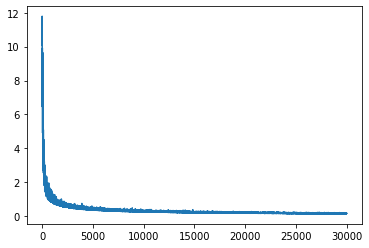

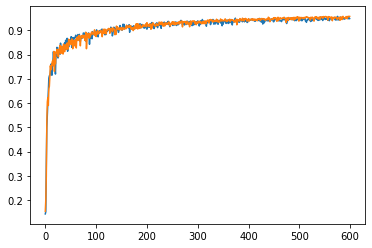

In [5]:
manyLoss = np.load("./mnist_PMPhmc_loss.npy",allow_pickle=True)
test_acc = np.load("./mnist_PMPhmc_test_acc.npy",allow_pickle=True)
train_acc = np.load("./mnist_PMPhmc_train_acc.npy",allow_pickle=True)

plt.plot(manyLoss)
plt.show()
plt.plot(test_acc)
plt.plot(train_acc)
plt.show()

# SPMCMC

In [6]:
class bnnHmc():
    def __init__(self,net,alpha):
        super().__init__()
        self.net = net
        self.alpha = alpha
        self.d = sum(p.numel() for p in self.net.parameters())
        self.loss = torch.nn.CrossEntropyLoss().to(device)
        self.loss_list = []
        self.train_acc = []
        self.test_acc = []

    def step(self, s, path_len=0.001, step_size=0.1):
        # Step 1:
        proposal_net = copy.deepcopy(self.net)  # Copy the sample to put the sample after iteration
        p_old = torch.randn(self.d).to(device) * 0.0005  # Randomly choose the original speed
        p_new = copy.deepcopy(p_old).to(device)  # Randomly choose a new speed
        # Calculate potential energy U(x)=-log(p(x))
        yhat = self.net(X)
        x_0_nlp = - self.loss(yhat, y)
        # Calculate kinetic energy
        p_0_nlp = (p_old * p_old).sum() / 2
        H_0 = p_0_nlp + x_0_nlp

        x_0_nlp.backward()
        du_dx = torch.tensor([]).to(device)
        for i in self.net.parameters():
            i = i.grad.reshape(-1)
            shape = i.shape[0]
            du_dx = torch.cat([du_dx, i.reshape(shape, 1)])

        du_dx = du_dx.reshape(self.d)
        # leapfrog dynamic iteration
        # 1. P take a half step
        p_new += step_size * du_dx / 2  # as potential energy increases, kinetic energy

        # 2. Parameters go one step
        sum = 0
        for i, j in zip(proposal_net.parameters(), range(self.d)):
            size = i.numel()
            i.data += step_size * p_new[sum:sum + size].reshape(i.data.shape)
            sum += size
        # 3.Update the parameters required in the second half of the step
        yhat = proposal_net(X)
        x_1_nlp = - self.loss(yhat, y)
        x_1_nlp.backward()
        du_dx = torch.tensor([]).to(device)
        for i in proposal_net.parameters():
            i = i.grad.reshape(-1)
            shape = i.shape[0]
            du_dx = torch.cat([du_dx, i.reshape(shape, 1)])
        # 4. take half a step
        du_dx = du_dx.reshape(self.d)
        p_new += step_size * du_dx.reshape(self.d) / 2  # second half-step "leapfrog" update to momentum

        p_1_nlp = (p_new * p_new).sum() / 2
        yhat = proposal_net(X)
        x_1_nlp = - self.loss(yhat, y)
        H_1 = x_1_nlp + p_1_nlp
        acceptance = torch.exp((- H_0 + H_1) * 1000)
        rand = torch.rand(1)[0].to(device)
        if acceptance > rand:
            self.net = proposal_net
            self.loss_list.append(-x_1_nlp.data)
        else:
            self.loss_list.append(- x_0_nlp.data)
        if s % 50 == 0:
            print("epoch",s,"loss = ",-x_1_nlp)
            correct = (yhat.argmax(1) == y).type(torch.float).sum().item()
            self.train_acc.append(correct / 60000 )
            print("train_acc:",correct / 60000)
            correct = (proposal_net(x_test).argmax(1) == y_test).type(torch.float).sum().item()
            self.test_acc.append(correct / 10000 )
            print("test_acc:",correct / 10000)

    def fit(self, num_steps=1000):
        trajectory = []
        for s in tqdm(range(num_steps)):
            self.step(s)
            # 记录每个参数的值
            parameters = torch.cat([param.view(-1) for param in self.net.parameters()])[:100]
            trajectory.append(parameters.cpu().detach().numpy().tolist())
        return np.array(self.loss_list), np.array(self.train_acc), np.array(self.test_acc),np.array(trajectory)

In [7]:
model_hmc = copy.deepcopy(model_o)
model_hmc = model_hmc.to(device)
alpha = 0.001
num_steps = 30000
trainer = bnnHmc(model_hmc, alpha=alpha)
loss,train_acc,test_acc,samples = trainer.fit(num_steps=num_steps)

# save data
np.save('mnist_SPhmc_loss'+'.npy', loss)
np.save('mnist_SPhmc_train_acc'+'.npy', train_acc)
np.save('mnist_SPhmc_test_acc'+'.npy', test_acc)
np.save('mnist_SPhmc_samples'+'.npy', samples)

  0%|          | 2/30000 [00:00<45:08, 11.08it/s]

epoch 0 loss =  tensor(9.9417, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.10506666666666667
test_acc: 0.0671


  0%|          | 54/30000 [00:03<31:55, 15.64it/s]

epoch 50 loss =  tensor(7.9331, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.13068333333333335
test_acc: 0.1688


  0%|          | 104/30000 [00:06<32:02, 15.55it/s]

epoch 100 loss =  tensor(7.2985, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.20856666666666668
test_acc: 0.1315


  1%|          | 154/30000 [00:09<31:48, 15.64it/s]

epoch 150 loss =  tensor(6.6286, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.2012
test_acc: 0.1133


  1%|          | 204/30000 [00:13<31:44, 15.64it/s]

epoch 200 loss =  tensor(5.9752, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.2305
test_acc: 0.3017


  1%|          | 254/30000 [00:16<31:53, 15.54it/s]

epoch 250 loss =  tensor(4.2238, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.30051666666666665
test_acc: 0.3805


  1%|          | 304/30000 [00:19<31:42, 15.61it/s]

epoch 300 loss =  tensor(4.1023, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.36418333333333336
test_acc: 0.3835


  1%|          | 354/30000 [00:22<31:32, 15.66it/s]

epoch 350 loss =  tensor(3.8527, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.39168333333333333
test_acc: 0.3355


  1%|▏         | 404/30000 [00:25<31:27, 15.68it/s]

epoch 400 loss =  tensor(3.4738, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.48325
test_acc: 0.4858


  2%|▏         | 454/30000 [00:28<31:24, 15.68it/s]

epoch 450 loss =  tensor(3.2709, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.4950833333333333
test_acc: 0.4482


  2%|▏         | 504/30000 [00:32<31:23, 15.66it/s]

epoch 500 loss =  tensor(3.1169, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.54735
test_acc: 0.5198


  2%|▏         | 554/30000 [00:35<31:21, 15.65it/s]

epoch 550 loss =  tensor(2.4033, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.53525
test_acc: 0.5397


  2%|▏         | 604/30000 [00:38<31:24, 15.60it/s]

epoch 600 loss =  tensor(2.4788, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.5367333333333333
test_acc: 0.6126


  2%|▏         | 654/30000 [00:41<31:23, 15.58it/s]

epoch 650 loss =  tensor(3.3240, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.51555
test_acc: 0.602


  2%|▏         | 704/30000 [00:44<31:14, 15.63it/s]

epoch 700 loss =  tensor(2.2702, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.5648333333333333
test_acc: 0.6038


  3%|▎         | 754/30000 [00:48<31:07, 15.66it/s]

epoch 750 loss =  tensor(1.8071, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.654
test_acc: 0.6125


  3%|▎         | 804/30000 [00:51<31:03, 15.66it/s]

epoch 800 loss =  tensor(1.8972, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6329833333333333
test_acc: 0.611


  3%|▎         | 854/30000 [00:54<30:59, 15.67it/s]

epoch 850 loss =  tensor(1.5186, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.692
test_acc: 0.6564


  3%|▎         | 904/30000 [00:57<31:00, 15.64it/s]

epoch 900 loss =  tensor(2.1251, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6107333333333334
test_acc: 0.6625


  3%|▎         | 954/30000 [01:00<30:55, 15.66it/s]

epoch 950 loss =  tensor(2.0605, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6323333333333333
test_acc: 0.6863


  3%|▎         | 1004/30000 [01:03<30:48, 15.69it/s]

epoch 1000 loss =  tensor(1.4968, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6885666666666667
test_acc: 0.6627


  4%|▎         | 1054/30000 [01:07<30:45, 15.69it/s]

epoch 1050 loss =  tensor(1.4236, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7186666666666667
test_acc: 0.6828


  4%|▎         | 1104/30000 [01:10<30:43, 15.67it/s]

epoch 1100 loss =  tensor(1.6769, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6570666666666667
test_acc: 0.6605


  4%|▍         | 1154/30000 [01:13<30:43, 15.65it/s]

epoch 1150 loss =  tensor(1.4051, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7105833333333333
test_acc: 0.6345


  4%|▍         | 1204/30000 [01:16<31:15, 15.35it/s]

epoch 1200 loss =  tensor(1.6580, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6801666666666667
test_acc: 0.6506


  4%|▍         | 1254/30000 [01:19<30:35, 15.66it/s]

epoch 1250 loss =  tensor(1.5173, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6886
test_acc: 0.6387


  4%|▍         | 1304/30000 [01:22<30:32, 15.66it/s]

epoch 1300 loss =  tensor(1.5683, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.68925
test_acc: 0.7012


  5%|▍         | 1354/30000 [01:26<30:29, 15.66it/s]

epoch 1350 loss =  tensor(1.4165, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7042
test_acc: 0.7136


  5%|▍         | 1404/30000 [01:29<30:29, 15.63it/s]

epoch 1400 loss =  tensor(1.5689, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.6898666666666666
test_acc: 0.6794


  5%|▍         | 1454/30000 [01:32<30:21, 15.67it/s]

epoch 1450 loss =  tensor(1.3995, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7234333333333334
test_acc: 0.685


  5%|▌         | 1504/30000 [01:35<30:22, 15.63it/s]

epoch 1500 loss =  tensor(1.3595, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7129333333333333
test_acc: 0.7652


  5%|▌         | 1554/30000 [01:38<30:36, 15.49it/s]

epoch 1550 loss =  tensor(1.2259, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7528666666666667
test_acc: 0.7477


  5%|▌         | 1604/30000 [01:42<30:13, 15.66it/s]

epoch 1600 loss =  tensor(1.3862, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.74485
test_acc: 0.7142


  6%|▌         | 1654/30000 [01:45<30:15, 15.62it/s]

epoch 1650 loss =  tensor(1.3663, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7038333333333333
test_acc: 0.7523


  6%|▌         | 1704/30000 [01:48<30:06, 15.66it/s]

epoch 1700 loss =  tensor(1.3265, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.72675
test_acc: 0.724


  6%|▌         | 1754/30000 [01:51<30:07, 15.63it/s]

epoch 1750 loss =  tensor(1.3797, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7388666666666667
test_acc: 0.6867


  6%|▌         | 1804/30000 [01:54<30:00, 15.66it/s]

epoch 1800 loss =  tensor(1.7270, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.68635
test_acc: 0.724


  6%|▌         | 1854/30000 [01:57<30:00, 15.63it/s]

epoch 1850 loss =  tensor(1.1033, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7633166666666666
test_acc: 0.7014


  6%|▋         | 1904/30000 [02:01<29:57, 15.63it/s]

epoch 1900 loss =  tensor(1.2449, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.74145
test_acc: 0.7541


  7%|▋         | 1954/30000 [02:04<29:54, 15.63it/s]

epoch 1950 loss =  tensor(1.2396, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7497666666666667
test_acc: 0.7767


  7%|▋         | 2004/30000 [02:07<29:47, 15.67it/s]

epoch 2000 loss =  tensor(1.3262, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7315
test_acc: 0.7372


  7%|▋         | 2054/30000 [02:10<29:43, 15.67it/s]

epoch 2050 loss =  tensor(1.2455, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7414166666666666
test_acc: 0.7579


  7%|▋         | 2104/30000 [02:13<29:44, 15.64it/s]

epoch 2100 loss =  tensor(1.2424, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7468
test_acc: 0.7675


  7%|▋         | 2154/30000 [02:17<30:07, 15.41it/s]

epoch 2150 loss =  tensor(1.0814, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7740666666666667
test_acc: 0.777


  7%|▋         | 2204/30000 [02:20<29:36, 15.65it/s]

epoch 2200 loss =  tensor(1.0026, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7845333333333333
test_acc: 0.7685


  8%|▊         | 2254/30000 [02:23<29:34, 15.64it/s]

epoch 2250 loss =  tensor(1.1987, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.76235
test_acc: 0.7807


  8%|▊         | 2304/30000 [02:26<29:30, 15.64it/s]

epoch 2300 loss =  tensor(1.1348, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7671
test_acc: 0.7696


  8%|▊         | 2354/30000 [02:29<29:27, 15.64it/s]

epoch 2350 loss =  tensor(1.0453, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7833
test_acc: 0.791


  8%|▊         | 2404/30000 [02:32<29:26, 15.62it/s]

epoch 2400 loss =  tensor(1.1955, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7558166666666667
test_acc: 0.8127


  8%|▊         | 2454/30000 [02:36<29:22, 15.63it/s]

epoch 2450 loss =  tensor(0.9592, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7933333333333333
test_acc: 0.7611


  8%|▊         | 2504/30000 [02:39<29:24, 15.58it/s]

epoch 2500 loss =  tensor(1.0741, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7745166666666666
test_acc: 0.7581


  9%|▊         | 2554/30000 [02:42<29:16, 15.63it/s]

epoch 2550 loss =  tensor(1.1548, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.76655
test_acc: 0.7963


  9%|▊         | 2604/30000 [02:45<29:11, 15.64it/s]

epoch 2600 loss =  tensor(1.4530, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7062166666666667
test_acc: 0.7615


  9%|▉         | 2654/30000 [02:48<29:09, 15.63it/s]

epoch 2650 loss =  tensor(0.9532, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7970333333333334
test_acc: 0.8011


  9%|▉         | 2704/30000 [02:52<29:05, 15.64it/s]

epoch 2700 loss =  tensor(0.8494, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7987833333333333
test_acc: 0.8057


  9%|▉         | 2754/30000 [02:55<29:00, 15.66it/s]

epoch 2750 loss =  tensor(1.0443, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7805333333333333
test_acc: 0.7948


  9%|▉         | 2804/30000 [02:58<29:01, 15.62it/s]

epoch 2800 loss =  tensor(0.8845, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.79965
test_acc: 0.7858


 10%|▉         | 2854/30000 [03:01<28:55, 15.64it/s]

epoch 2850 loss =  tensor(0.9414, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7913833333333333
test_acc: 0.7957


 10%|▉         | 2904/30000 [03:04<28:53, 15.63it/s]

epoch 2900 loss =  tensor(0.9906, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7777
test_acc: 0.7924


 10%|▉         | 2954/30000 [03:07<28:48, 15.64it/s]

epoch 2950 loss =  tensor(1.1446, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7512333333333333
test_acc: 0.7993


 10%|█         | 3004/30000 [03:11<28:48, 15.62it/s]

epoch 3000 loss =  tensor(1.4859, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7219333333333333
test_acc: 0.7523


 10%|█         | 3054/30000 [03:14<28:42, 15.64it/s]

epoch 3050 loss =  tensor(1.0410, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.78045
test_acc: 0.809


 10%|█         | 3104/30000 [03:17<29:03, 15.42it/s]

epoch 3100 loss =  tensor(1.1091, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7653666666666666
test_acc: 0.7849


 11%|█         | 3154/30000 [03:20<28:34, 15.66it/s]

epoch 3150 loss =  tensor(1.1593, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7597166666666667
test_acc: 0.8302


 11%|█         | 3204/30000 [03:23<28:34, 15.63it/s]

epoch 3200 loss =  tensor(1.5623, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7164666666666667
test_acc: 0.7851


 11%|█         | 3254/30000 [03:27<28:29, 15.64it/s]

epoch 3250 loss =  tensor(0.9803, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7935666666666666
test_acc: 0.8006


 11%|█         | 3304/30000 [03:30<28:35, 15.56it/s]

epoch 3300 loss =  tensor(0.8138, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8088666666666666
test_acc: 0.8043


 11%|█         | 3354/30000 [03:33<28:26, 15.61it/s]

epoch 3350 loss =  tensor(1.0896, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7740333333333334
test_acc: 0.7872


 11%|█▏        | 3404/30000 [03:36<28:23, 15.61it/s]

epoch 3400 loss =  tensor(0.8735, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8260833333333333
test_acc: 0.8052


 12%|█▏        | 3454/30000 [03:39<28:29, 15.53it/s]

epoch 3450 loss =  tensor(0.9892, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7796
test_acc: 0.8146


 12%|█▏        | 3504/30000 [03:42<28:14, 15.64it/s]

epoch 3500 loss =  tensor(0.7683, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.83495
test_acc: 0.8174


 12%|█▏        | 3554/30000 [03:46<28:09, 15.66it/s]

epoch 3550 loss =  tensor(0.8560, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7959333333333334
test_acc: 0.7993


 12%|█▏        | 3604/30000 [03:49<28:10, 15.62it/s]

epoch 3600 loss =  tensor(0.9951, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7722166666666667
test_acc: 0.7963


 12%|█▏        | 3654/30000 [03:52<28:06, 15.62it/s]

epoch 3650 loss =  tensor(0.9072, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7980666666666667
test_acc: 0.7959


 12%|█▏        | 3704/30000 [03:55<27:59, 15.66it/s]

epoch 3700 loss =  tensor(0.8940, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7977333333333333
test_acc: 0.7968


 13%|█▎        | 3754/30000 [03:58<28:00, 15.61it/s]

epoch 3750 loss =  tensor(0.8488, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8005166666666667
test_acc: 0.8052


 13%|█▎        | 3804/30000 [04:02<27:56, 15.63it/s]

epoch 3800 loss =  tensor(0.8335, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8047833333333333
test_acc: 0.8053


 13%|█▎        | 3854/30000 [04:05<27:50, 15.65it/s]

epoch 3850 loss =  tensor(0.9970, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.75335
test_acc: 0.816


 13%|█▎        | 3904/30000 [04:08<27:46, 15.65it/s]

epoch 3900 loss =  tensor(0.8603, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8064333333333333
test_acc: 0.8156


 13%|█▎        | 3954/30000 [04:11<27:43, 15.66it/s]

epoch 3950 loss =  tensor(0.9444, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7996333333333333
test_acc: 0.8211


 13%|█▎        | 4004/30000 [04:14<27:41, 15.64it/s]

epoch 4000 loss =  tensor(0.8658, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7962333333333333
test_acc: 0.7729


 14%|█▎        | 4054/30000 [04:17<27:43, 15.60it/s]

epoch 4050 loss =  tensor(0.8641, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.79685
test_acc: 0.8251


 14%|█▎        | 4104/30000 [04:21<27:34, 15.65it/s]

epoch 4100 loss =  tensor(0.7645, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.81775
test_acc: 0.8015


 14%|█▍        | 4154/30000 [04:24<27:29, 15.67it/s]

epoch 4150 loss =  tensor(0.7852, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8239666666666666
test_acc: 0.8145


 14%|█▍        | 4204/30000 [04:27<27:26, 15.67it/s]

epoch 4200 loss =  tensor(0.7435, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.82745
test_acc: 0.8237


 14%|█▍        | 4254/30000 [04:30<27:21, 15.68it/s]

epoch 4250 loss =  tensor(0.9451, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.78005
test_acc: 0.8186


 14%|█▍        | 4304/30000 [04:33<27:20, 15.66it/s]

epoch 4300 loss =  tensor(0.8470, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.80115
test_acc: 0.8114


 15%|█▍        | 4354/30000 [04:36<27:15, 15.68it/s]

epoch 4350 loss =  tensor(0.7662, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8195833333333333
test_acc: 0.8276


 15%|█▍        | 4404/30000 [04:40<27:14, 15.66it/s]

epoch 4400 loss =  tensor(0.8504, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.78955
test_acc: 0.7932


 15%|█▍        | 4454/30000 [04:43<27:09, 15.68it/s]

epoch 4450 loss =  tensor(0.9110, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7798333333333334
test_acc: 0.8354


 15%|█▌        | 4504/30000 [04:46<27:08, 15.65it/s]

epoch 4500 loss =  tensor(0.7077, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8316
test_acc: 0.8235


 15%|█▌        | 4554/30000 [04:49<27:03, 15.67it/s]

epoch 4550 loss =  tensor(0.7784, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8206666666666667
test_acc: 0.8529


 15%|█▌        | 4604/30000 [04:52<27:01, 15.67it/s]

epoch 4600 loss =  tensor(0.7896, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8269666666666666
test_acc: 0.8255


 16%|█▌        | 4654/30000 [04:56<26:58, 15.66it/s]

epoch 4650 loss =  tensor(0.8003, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8032833333333333
test_acc: 0.8348


 16%|█▌        | 4704/30000 [04:59<26:52, 15.68it/s]

epoch 4700 loss =  tensor(0.6508, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8498
test_acc: 0.8442


 16%|█▌        | 4754/30000 [05:02<26:53, 15.65it/s]

epoch 4750 loss =  tensor(0.7251, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8288666666666666
test_acc: 0.7918


 16%|█▌        | 4804/30000 [05:05<26:47, 15.68it/s]

epoch 4800 loss =  tensor(0.7642, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8207
test_acc: 0.8536


 16%|█▌        | 4854/30000 [05:08<26:47, 15.64it/s]

epoch 4850 loss =  tensor(0.8885, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7937833333333333
test_acc: 0.8097


 16%|█▋        | 4904/30000 [05:11<26:42, 15.66it/s]

epoch 4900 loss =  tensor(0.7881, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8075666666666667
test_acc: 0.7992


 17%|█▋        | 4954/30000 [05:15<26:38, 15.67it/s]

epoch 4950 loss =  tensor(0.7268, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8278333333333333
test_acc: 0.8109


 17%|█▋        | 5004/30000 [05:18<26:37, 15.64it/s]

epoch 5000 loss =  tensor(0.8070, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8076833333333333
test_acc: 0.8327


 17%|█▋        | 5054/30000 [05:21<26:40, 15.59it/s]

epoch 5050 loss =  tensor(0.7988, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.80455
test_acc: 0.7957


 17%|█▋        | 5104/30000 [05:24<26:32, 15.63it/s]

epoch 5100 loss =  tensor(0.7029, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8315833333333333
test_acc: 0.846


 17%|█▋        | 5154/30000 [05:27<26:28, 15.64it/s]

epoch 5150 loss =  tensor(0.7097, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8437833333333333
test_acc: 0.8403


 17%|█▋        | 5204/30000 [05:31<26:24, 15.65it/s]

epoch 5200 loss =  tensor(0.6704, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8320833333333333
test_acc: 0.8185


 18%|█▊        | 5254/30000 [05:34<26:21, 15.65it/s]

epoch 5250 loss =  tensor(0.7490, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8256
test_acc: 0.8099


 18%|█▊        | 5304/30000 [05:37<26:19, 15.63it/s]

epoch 5300 loss =  tensor(0.7368, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8254166666666667
test_acc: 0.7979


 18%|█▊        | 5354/30000 [05:40<26:13, 15.67it/s]

epoch 5350 loss =  tensor(0.6793, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.835
test_acc: 0.835


 18%|█▊        | 5404/30000 [05:43<26:16, 15.60it/s]

epoch 5400 loss =  tensor(0.7152, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.83085
test_acc: 0.8038


 18%|█▊        | 5454/30000 [05:46<26:07, 15.66it/s]

epoch 5450 loss =  tensor(0.7838, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8246
test_acc: 0.8458


 18%|█▊        | 5504/30000 [05:50<26:05, 15.65it/s]

epoch 5500 loss =  tensor(0.6786, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8281
test_acc: 0.8273


 19%|█▊        | 5554/30000 [05:53<26:02, 15.64it/s]

epoch 5550 loss =  tensor(0.9307, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7554166666666666
test_acc: 0.8423


 19%|█▊        | 5604/30000 [05:56<25:58, 15.65it/s]

epoch 5600 loss =  tensor(0.7582, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.81405
test_acc: 0.8281


 19%|█▉        | 5654/30000 [05:59<25:54, 15.66it/s]

epoch 5650 loss =  tensor(0.6756, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8351
test_acc: 0.8171


 19%|█▉        | 5704/30000 [06:02<25:53, 15.63it/s]

epoch 5700 loss =  tensor(0.7884, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8158166666666666
test_acc: 0.8358


 19%|█▉        | 5754/30000 [06:05<25:50, 15.63it/s]

epoch 5750 loss =  tensor(0.7115, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8134
test_acc: 0.8143


 19%|█▉        | 5804/30000 [06:09<25:45, 15.65it/s]

epoch 5800 loss =  tensor(0.6765, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8365333333333334
test_acc: 0.8316


 20%|█▉        | 5854/30000 [06:12<25:46, 15.61it/s]

epoch 5850 loss =  tensor(0.6638, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8322
test_acc: 0.8438


 20%|█▉        | 5904/30000 [06:15<25:41, 15.63it/s]

epoch 5900 loss =  tensor(0.7084, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8205333333333333
test_acc: 0.8435


 20%|█▉        | 5954/30000 [06:18<25:39, 15.62it/s]

epoch 5950 loss =  tensor(0.6750, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8322166666666667
test_acc: 0.8334


 20%|██        | 6004/30000 [06:21<25:41, 15.56it/s]

epoch 6000 loss =  tensor(0.6448, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8327666666666667
test_acc: 0.8366


 20%|██        | 6054/30000 [06:25<25:32, 15.62it/s]

epoch 6050 loss =  tensor(0.7949, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.80625
test_acc: 0.84


 20%|██        | 6104/30000 [06:28<25:28, 15.63it/s]

epoch 6100 loss =  tensor(0.7224, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8163333333333334
test_acc: 0.8625


 21%|██        | 6154/30000 [06:31<25:23, 15.65it/s]

epoch 6150 loss =  tensor(0.7097, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.83535
test_acc: 0.8402


 21%|██        | 6204/30000 [06:34<25:23, 15.62it/s]

epoch 6200 loss =  tensor(0.6732, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8210166666666666
test_acc: 0.8394


 21%|██        | 6254/30000 [06:37<25:17, 15.65it/s]

epoch 6250 loss =  tensor(0.7799, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8042333333333334
test_acc: 0.8288


 21%|██        | 6304/30000 [06:40<25:16, 15.62it/s]

epoch 6300 loss =  tensor(0.7271, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.82275
test_acc: 0.8656


 21%|██        | 6354/30000 [06:44<25:16, 15.60it/s]

epoch 6350 loss =  tensor(0.7350, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8172
test_acc: 0.8431


 21%|██▏       | 6404/30000 [06:47<25:08, 15.64it/s]

epoch 6400 loss =  tensor(0.7202, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8195833333333333
test_acc: 0.8457


 22%|██▏       | 6454/30000 [06:50<25:07, 15.62it/s]

epoch 6450 loss =  tensor(0.5874, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8518833333333333
test_acc: 0.774


 22%|██▏       | 6504/30000 [06:53<25:03, 15.62it/s]

epoch 6500 loss =  tensor(0.6904, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.82815
test_acc: 0.8607


 22%|██▏       | 6554/30000 [06:56<24:57, 15.65it/s]

epoch 6550 loss =  tensor(0.6026, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8451
test_acc: 0.8351


 22%|██▏       | 6604/30000 [07:00<24:55, 15.65it/s]

epoch 6600 loss =  tensor(0.6271, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.84035
test_acc: 0.8403


 22%|██▏       | 6654/30000 [07:03<24:52, 15.65it/s]

epoch 6650 loss =  tensor(0.6399, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8328666666666666
test_acc: 0.8377


 22%|██▏       | 6704/30000 [07:06<24:48, 15.65it/s]

epoch 6700 loss =  tensor(0.6359, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8399666666666666
test_acc: 0.8669


 23%|██▎       | 6754/30000 [07:09<24:44, 15.66it/s]

epoch 6750 loss =  tensor(0.6624, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8369333333333333
test_acc: 0.8577


 23%|██▎       | 6804/30000 [07:12<24:46, 15.60it/s]

epoch 6800 loss =  tensor(0.5973, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8509
test_acc: 0.8522


 23%|██▎       | 6854/30000 [07:15<24:39, 15.65it/s]

epoch 6850 loss =  tensor(0.6255, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8383166666666667
test_acc: 0.8542


 23%|██▎       | 6904/30000 [07:19<24:34, 15.67it/s]

epoch 6900 loss =  tensor(0.6054, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8411833333333333
test_acc: 0.829


 23%|██▎       | 6954/30000 [07:22<25:01, 15.35it/s]

epoch 6950 loss =  tensor(0.5699, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8566333333333334
test_acc: 0.8359


 23%|██▎       | 7004/30000 [07:25<24:31, 15.63it/s]

epoch 7000 loss =  tensor(0.6662, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8377666666666667
test_acc: 0.8478


 24%|██▎       | 7054/30000 [07:28<24:24, 15.67it/s]

epoch 7050 loss =  tensor(0.6455, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.83715
test_acc: 0.8683


 24%|██▎       | 7104/30000 [07:31<24:22, 15.66it/s]

epoch 7100 loss =  tensor(0.9385, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.7739833333333334
test_acc: 0.837


 24%|██▍       | 7154/30000 [07:35<24:17, 15.67it/s]

epoch 7150 loss =  tensor(0.6259, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.84225
test_acc: 0.8456


 24%|██▍       | 7204/30000 [07:38<24:17, 15.64it/s]

epoch 7200 loss =  tensor(0.6529, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8363666666666667
test_acc: 0.8392


 24%|██▍       | 7254/30000 [07:41<24:12, 15.66it/s]

epoch 7250 loss =  tensor(0.6051, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.84475
test_acc: 0.8668


 24%|██▍       | 7304/30000 [07:44<24:11, 15.64it/s]

epoch 7300 loss =  tensor(0.6224, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8384
test_acc: 0.8542


 25%|██▍       | 7354/30000 [07:47<24:04, 15.67it/s]

epoch 7350 loss =  tensor(0.5471, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.85725
test_acc: 0.8561


 25%|██▍       | 7404/30000 [07:50<24:02, 15.67it/s]

epoch 7400 loss =  tensor(0.6164, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8471666666666666
test_acc: 0.8404


 25%|██▍       | 7454/30000 [07:54<23:58, 15.67it/s]

epoch 7450 loss =  tensor(0.5164, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8652166666666666
test_acc: 0.8509


 25%|██▌       | 7504/30000 [07:57<23:57, 15.65it/s]

epoch 7500 loss =  tensor(0.5835, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.84685
test_acc: 0.8501


 25%|██▌       | 7554/30000 [08:00<23:56, 15.62it/s]

epoch 7550 loss =  tensor(0.7213, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8171833333333334
test_acc: 0.8517


 25%|██▌       | 7604/30000 [08:03<23:51, 15.65it/s]

epoch 7600 loss =  tensor(0.6268, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8382166666666667
test_acc: 0.8477


 26%|██▌       | 7654/30000 [08:06<23:55, 15.57it/s]

epoch 7650 loss =  tensor(0.7794, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8066333333333333
test_acc: 0.8637


 26%|██▌       | 7704/30000 [08:10<23:45, 15.64it/s]

epoch 7700 loss =  tensor(0.5293, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8652666666666666
test_acc: 0.847


 26%|██▌       | 7754/30000 [08:13<23:44, 15.62it/s]

epoch 7750 loss =  tensor(0.5825, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.85495
test_acc: 0.8371


 26%|██▌       | 7804/30000 [08:16<23:38, 15.65it/s]

epoch 7800 loss =  tensor(0.6108, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8412833333333334
test_acc: 0.8329


 26%|██▌       | 7854/30000 [08:19<23:36, 15.64it/s]

epoch 7850 loss =  tensor(0.5534, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8601833333333333
test_acc: 0.819


 26%|██▋       | 7904/30000 [08:22<23:50, 15.45it/s]

epoch 7900 loss =  tensor(0.6568, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8268666666666666
test_acc: 0.8572


 27%|██▋       | 7954/30000 [08:25<23:29, 15.64it/s]

epoch 7950 loss =  tensor(0.6123, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.84225
test_acc: 0.8435


 27%|██▋       | 8004/30000 [08:29<23:28, 15.62it/s]

epoch 8000 loss =  tensor(0.5731, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8507
test_acc: 0.813


 27%|██▋       | 8054/30000 [08:32<23:23, 15.64it/s]

epoch 8050 loss =  tensor(0.5419, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8585833333333334
test_acc: 0.8467


 27%|██▋       | 8104/30000 [08:35<23:22, 15.62it/s]

epoch 8100 loss =  tensor(0.5411, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8586
test_acc: 0.8384


 27%|██▋       | 8154/30000 [08:38<23:17, 15.64it/s]

epoch 8150 loss =  tensor(0.5911, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8478833333333333
test_acc: 0.8442


 27%|██▋       | 8204/30000 [08:41<23:17, 15.59it/s]

epoch 8200 loss =  tensor(0.6214, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8356333333333333
test_acc: 0.867


 28%|██▊       | 8254/30000 [08:45<23:19, 15.54it/s]

epoch 8250 loss =  tensor(0.6048, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.84825
test_acc: 0.8703


 28%|██▊       | 8304/30000 [08:48<23:09, 15.62it/s]

epoch 8300 loss =  tensor(0.5229, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8758833333333333
test_acc: 0.8603


 28%|██▊       | 8354/30000 [08:51<23:03, 15.64it/s]

epoch 8350 loss =  tensor(0.5687, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8505166666666667
test_acc: 0.8705


 28%|██▊       | 8404/30000 [08:54<23:00, 15.64it/s]

epoch 8400 loss =  tensor(0.5921, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8451333333333333
test_acc: 0.8692


 28%|██▊       | 8454/30000 [08:57<22:57, 15.64it/s]

epoch 8450 loss =  tensor(0.5126, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8644666666666667
test_acc: 0.8577


 28%|██▊       | 8504/30000 [09:00<22:54, 15.63it/s]

epoch 8500 loss =  tensor(0.5357, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8617666666666667
test_acc: 0.8553


 29%|██▊       | 8554/30000 [09:04<22:51, 15.63it/s]

epoch 8550 loss =  tensor(0.5266, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8627166666666667
test_acc: 0.8618


 29%|██▊       | 8604/30000 [09:07<22:48, 15.64it/s]

epoch 8600 loss =  tensor(0.5392, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8585333333333334
test_acc: 0.8444


 29%|██▉       | 8654/30000 [09:10<22:43, 15.65it/s]

epoch 8650 loss =  tensor(0.5227, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8655166666666667
test_acc: 0.8513


 29%|██▉       | 8704/30000 [09:13<22:44, 15.61it/s]

epoch 8700 loss =  tensor(0.6391, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8254833333333333
test_acc: 0.8375


 29%|██▉       | 8754/30000 [09:16<22:39, 15.63it/s]

epoch 8750 loss =  tensor(0.5378, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8527833333333333
test_acc: 0.8163


 29%|██▉       | 8804/30000 [09:20<22:36, 15.62it/s]

epoch 8800 loss =  tensor(0.5447, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.86385
test_acc: 0.8544


 30%|██▉       | 8854/30000 [09:23<22:31, 15.64it/s]

epoch 8850 loss =  tensor(0.5387, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8549333333333333
test_acc: 0.8297


 30%|██▉       | 8904/30000 [09:26<22:29, 15.64it/s]

epoch 8900 loss =  tensor(0.5651, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8508333333333333
test_acc: 0.8797


 30%|██▉       | 8954/30000 [09:29<22:25, 15.64it/s]

epoch 8950 loss =  tensor(0.6388, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8320833333333333
test_acc: 0.8701


 30%|███       | 9004/30000 [09:32<22:22, 15.63it/s]

epoch 9000 loss =  tensor(0.5552, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8577833333333333
test_acc: 0.8381


 30%|███       | 9054/30000 [09:35<22:17, 15.66it/s]

epoch 9050 loss =  tensor(0.4926, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.871
test_acc: 0.86


 30%|███       | 9104/30000 [09:39<22:13, 15.67it/s]

epoch 9100 loss =  tensor(0.5662, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8547833333333333
test_acc: 0.8775


 31%|███       | 9154/30000 [09:42<22:10, 15.67it/s]

epoch 9150 loss =  tensor(0.6555, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8469166666666667
test_acc: 0.8677


 31%|███       | 9204/30000 [09:45<22:10, 15.63it/s]

epoch 9200 loss =  tensor(0.5952, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.837
test_acc: 0.8747


 31%|███       | 9254/30000 [09:48<22:06, 15.64it/s]

epoch 9250 loss =  tensor(0.5778, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.84945
test_acc: 0.8731


 31%|███       | 9304/30000 [09:51<21:59, 15.68it/s]

epoch 9300 loss =  tensor(0.5902, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.83385
test_acc: 0.8448


 31%|███       | 9354/30000 [09:54<21:57, 15.67it/s]

epoch 9350 loss =  tensor(0.5472, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8483833333333334
test_acc: 0.8578


 31%|███▏      | 9404/30000 [09:58<22:01, 15.59it/s]

epoch 9400 loss =  tensor(0.5466, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8534333333333334
test_acc: 0.8687


 32%|███▏      | 9454/30000 [10:01<21:52, 15.65it/s]

epoch 9450 loss =  tensor(0.5366, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8631833333333333
test_acc: 0.8429


 32%|███▏      | 9504/30000 [10:04<21:47, 15.67it/s]

epoch 9500 loss =  tensor(0.4824, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8721333333333333
test_acc: 0.849


 32%|███▏      | 9554/30000 [10:07<21:44, 15.67it/s]

epoch 9550 loss =  tensor(0.5579, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.85675
test_acc: 0.864


 32%|███▏      | 9604/30000 [10:10<21:41, 15.67it/s]

epoch 9600 loss =  tensor(0.5380, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8625333333333334
test_acc: 0.8356


 32%|███▏      | 9654/30000 [10:14<21:38, 15.67it/s]

epoch 9650 loss =  tensor(0.6122, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8348
test_acc: 0.8548


 32%|███▏      | 9704/30000 [10:17<21:35, 15.66it/s]

epoch 9700 loss =  tensor(0.4694, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8750333333333333
test_acc: 0.8684


 33%|███▎      | 9754/30000 [10:20<21:32, 15.66it/s]

epoch 9750 loss =  tensor(0.5134, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.86645
test_acc: 0.831


 33%|███▎      | 9804/30000 [10:23<21:36, 15.57it/s]

epoch 9800 loss =  tensor(0.5407, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8511
test_acc: 0.8788


 33%|███▎      | 9854/30000 [10:26<21:31, 15.60it/s]

epoch 9850 loss =  tensor(0.5476, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8598
test_acc: 0.8705


 33%|███▎      | 9904/30000 [10:29<21:27, 15.61it/s]

epoch 9900 loss =  tensor(0.5413, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8592666666666666
test_acc: 0.8349


 33%|███▎      | 9954/30000 [10:33<21:22, 15.63it/s]

epoch 9950 loss =  tensor(0.5386, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8545666666666667
test_acc: 0.8621


 33%|███▎      | 10004/30000 [10:36<21:23, 15.58it/s]

epoch 10000 loss =  tensor(0.5175, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8584833333333334
test_acc: 0.8665


 34%|███▎      | 10054/30000 [10:39<21:16, 15.63it/s]

epoch 10050 loss =  tensor(0.5224, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.86715
test_acc: 0.8426


 34%|███▎      | 10104/30000 [10:42<21:15, 15.60it/s]

epoch 10100 loss =  tensor(0.6345, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8412
test_acc: 0.8598


 34%|███▍      | 10154/30000 [10:45<21:15, 15.56it/s]

epoch 10150 loss =  tensor(0.5194, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8619333333333333
test_acc: 0.8692


 34%|███▍      | 10204/30000 [10:49<21:04, 15.65it/s]

epoch 10200 loss =  tensor(0.5120, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8807333333333334
test_acc: 0.8746


 34%|███▍      | 10254/30000 [10:52<21:01, 15.65it/s]

epoch 10250 loss =  tensor(0.5527, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8621
test_acc: 0.8583


 34%|███▍      | 10304/30000 [10:55<20:59, 15.64it/s]

epoch 10300 loss =  tensor(0.4847, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8738
test_acc: 0.8805


 35%|███▍      | 10354/30000 [10:58<20:55, 15.65it/s]

epoch 10350 loss =  tensor(0.5567, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8548166666666667
test_acc: 0.8864


 35%|███▍      | 10404/30000 [11:01<20:52, 15.65it/s]

epoch 10400 loss =  tensor(0.5064, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8754666666666666
test_acc: 0.8643


 35%|███▍      | 10454/30000 [11:04<20:50, 15.64it/s]

epoch 10450 loss =  tensor(0.4843, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8670166666666667
test_acc: 0.8652


 35%|███▌      | 10504/30000 [11:08<20:46, 15.63it/s]

epoch 10500 loss =  tensor(0.4814, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8708
test_acc: 0.8739


 35%|███▌      | 10554/30000 [11:11<20:41, 15.66it/s]

epoch 10550 loss =  tensor(0.5496, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8565333333333334
test_acc: 0.8854


 35%|███▌      | 10604/30000 [11:14<20:38, 15.66it/s]

epoch 10600 loss =  tensor(0.5188, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.86515
test_acc: 0.861


 36%|███▌      | 10654/30000 [11:17<20:33, 15.68it/s]

epoch 10650 loss =  tensor(0.4836, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8734
test_acc: 0.8629


 36%|███▌      | 10704/30000 [11:20<20:32, 15.65it/s]

epoch 10700 loss =  tensor(0.5915, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8515333333333334
test_acc: 0.8727


 36%|███▌      | 10754/30000 [11:24<20:31, 15.62it/s]

epoch 10750 loss =  tensor(0.4516, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8769
test_acc: 0.8877


 36%|███▌      | 10804/30000 [11:27<20:30, 15.60it/s]

epoch 10800 loss =  tensor(0.6329, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8267333333333333
test_acc: 0.87


 36%|███▌      | 10854/30000 [11:30<20:24, 15.64it/s]

epoch 10850 loss =  tensor(0.4914, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8752
test_acc: 0.8771


 36%|███▋      | 10904/30000 [11:33<20:22, 15.62it/s]

epoch 10900 loss =  tensor(0.4605, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8752666666666666
test_acc: 0.8548


 37%|███▋      | 10954/30000 [11:36<20:17, 15.65it/s]

epoch 10950 loss =  tensor(0.4855, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.87315
test_acc: 0.8758


 37%|███▋      | 11004/30000 [11:39<20:14, 15.64it/s]

epoch 11000 loss =  tensor(0.4330, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88605
test_acc: 0.857


 37%|███▋      | 11054/30000 [11:43<20:10, 15.65it/s]

epoch 11050 loss =  tensor(0.4947, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8693666666666666
test_acc: 0.8668


 37%|███▋      | 11104/30000 [11:46<20:08, 15.63it/s]

epoch 11100 loss =  tensor(0.5298, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.85985
test_acc: 0.8631


 37%|███▋      | 11154/30000 [11:49<20:08, 15.60it/s]

epoch 11150 loss =  tensor(0.5115, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8629
test_acc: 0.8687


 37%|███▋      | 11204/30000 [11:52<20:01, 15.64it/s]

epoch 11200 loss =  tensor(0.5085, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8621833333333333
test_acc: 0.8522


 38%|███▊      | 11254/30000 [11:55<19:59, 15.63it/s]

epoch 11250 loss =  tensor(0.4856, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8701666666666666
test_acc: 0.8527


 38%|███▊      | 11304/30000 [11:59<19:56, 15.62it/s]

epoch 11300 loss =  tensor(0.4909, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.869
test_acc: 0.8539


 38%|███▊      | 11354/30000 [12:02<19:51, 15.65it/s]

epoch 11350 loss =  tensor(0.4862, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8672333333333333
test_acc: 0.8633


 38%|███▊      | 11404/30000 [12:05<19:49, 15.63it/s]

epoch 11400 loss =  tensor(0.4951, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8732166666666666
test_acc: 0.8722


 38%|███▊      | 11454/30000 [12:08<19:47, 15.62it/s]

epoch 11450 loss =  tensor(0.5693, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8467666666666667
test_acc: 0.8681


 38%|███▊      | 11504/30000 [12:11<19:41, 15.66it/s]

epoch 11500 loss =  tensor(0.4774, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8702
test_acc: 0.8813


 39%|███▊      | 11554/30000 [12:14<19:40, 15.63it/s]

epoch 11550 loss =  tensor(0.4864, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.86845
test_acc: 0.8751


 39%|███▊      | 11604/30000 [12:18<19:37, 15.62it/s]

epoch 11600 loss =  tensor(0.5319, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8665666666666667
test_acc: 0.8837


 39%|███▉      | 11654/30000 [12:21<19:33, 15.64it/s]

epoch 11650 loss =  tensor(0.4624, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88
test_acc: 0.8687


 39%|███▉      | 11704/30000 [12:24<19:30, 15.63it/s]

epoch 11700 loss =  tensor(0.4408, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8803666666666666
test_acc: 0.8751


 39%|███▉      | 11754/30000 [12:27<19:31, 15.58it/s]

epoch 11750 loss =  tensor(0.4452, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8867333333333334
test_acc: 0.8827


 39%|███▉      | 11804/30000 [12:30<19:21, 15.67it/s]

epoch 11800 loss =  tensor(0.5108, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8706333333333334
test_acc: 0.8547


 40%|███▉      | 11854/30000 [12:34<19:20, 15.64it/s]

epoch 11850 loss =  tensor(0.4483, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8807833333333334
test_acc: 0.8794


 40%|███▉      | 11904/30000 [12:37<19:15, 15.67it/s]

epoch 11900 loss =  tensor(0.4990, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.85655
test_acc: 0.8614


 40%|███▉      | 11954/30000 [12:40<19:16, 15.61it/s]

epoch 11950 loss =  tensor(0.6151, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8353833333333334
test_acc: 0.8748


 40%|████      | 12004/30000 [12:43<19:08, 15.66it/s]

epoch 12000 loss =  tensor(0.4299, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8841666666666667
test_acc: 0.8649


 40%|████      | 12054/30000 [12:46<19:09, 15.62it/s]

epoch 12050 loss =  tensor(0.5025, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8711
test_acc: 0.8628


 40%|████      | 12104/30000 [12:49<19:05, 15.62it/s]

epoch 12100 loss =  tensor(0.4526, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8777333333333334
test_acc: 0.879


 41%|████      | 12154/30000 [12:53<18:58, 15.68it/s]

epoch 12150 loss =  tensor(0.4638, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88055
test_acc: 0.8818


 41%|████      | 12204/30000 [12:56<18:55, 15.67it/s]

epoch 12200 loss =  tensor(0.4639, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8766833333333334
test_acc: 0.8772


 41%|████      | 12254/30000 [12:59<18:55, 15.63it/s]

epoch 12250 loss =  tensor(0.4722, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8764833333333333
test_acc: 0.8707


 41%|████      | 12304/30000 [13:02<18:52, 15.62it/s]

epoch 12300 loss =  tensor(0.4491, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.87605
test_acc: 0.8819


 41%|████      | 12354/30000 [13:05<18:45, 15.68it/s]

epoch 12350 loss =  tensor(0.4382, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8851833333333333
test_acc: 0.8736


 41%|████▏     | 12404/30000 [13:08<18:42, 15.68it/s]

epoch 12400 loss =  tensor(0.4186, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8897
test_acc: 0.8743


 42%|████▏     | 12454/30000 [13:12<18:39, 15.68it/s]

epoch 12450 loss =  tensor(0.5193, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8691166666666666
test_acc: 0.8781


 42%|████▏     | 12504/30000 [13:15<18:35, 15.68it/s]

epoch 12500 loss =  tensor(0.4347, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8888833333333334
test_acc: 0.8764


 42%|████▏     | 12554/30000 [13:18<18:32, 15.68it/s]

epoch 12550 loss =  tensor(0.4347, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8884166666666666
test_acc: 0.8805


 42%|████▏     | 12604/30000 [13:21<18:30, 15.67it/s]

epoch 12600 loss =  tensor(0.4811, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8712
test_acc: 0.8769


 42%|████▏     | 12654/30000 [13:24<18:28, 15.65it/s]

epoch 12650 loss =  tensor(0.4705, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8777
test_acc: 0.8897


 42%|████▏     | 12704/30000 [13:28<18:43, 15.39it/s]

epoch 12700 loss =  tensor(0.5382, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.858
test_acc: 0.8463


 43%|████▎     | 12754/30000 [13:31<18:21, 15.66it/s]

epoch 12750 loss =  tensor(0.5205, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8585833333333334
test_acc: 0.8933


 43%|████▎     | 12804/30000 [13:34<18:19, 15.64it/s]

epoch 12800 loss =  tensor(0.4489, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8870333333333333
test_acc: 0.88


 43%|████▎     | 12854/30000 [13:37<18:16, 15.64it/s]

epoch 12850 loss =  tensor(0.4385, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8898333333333334
test_acc: 0.8813


 43%|████▎     | 12904/30000 [13:40<18:12, 15.64it/s]

epoch 12900 loss =  tensor(0.4689, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8734333333333333
test_acc: 0.8704


 43%|████▎     | 12954/30000 [13:43<18:11, 15.62it/s]

epoch 12950 loss =  tensor(0.4287, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8854
test_acc: 0.8834


 43%|████▎     | 13004/30000 [13:47<18:08, 15.62it/s]

epoch 13000 loss =  tensor(0.3889, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8936666666666667
test_acc: 0.8789


 44%|████▎     | 13054/30000 [13:50<18:03, 15.63it/s]

epoch 13050 loss =  tensor(0.4554, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8759666666666667
test_acc: 0.8856


 44%|████▎     | 13104/30000 [13:53<17:59, 15.65it/s]

epoch 13100 loss =  tensor(0.4609, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88055
test_acc: 0.8717


 44%|████▍     | 13154/30000 [13:56<17:56, 15.65it/s]

epoch 13150 loss =  tensor(0.4685, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8775
test_acc: 0.8753


 44%|████▍     | 13204/30000 [13:59<17:53, 15.65it/s]

epoch 13200 loss =  tensor(0.4295, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8866166666666667
test_acc: 0.8899


 44%|████▍     | 13254/30000 [14:03<17:49, 15.65it/s]

epoch 13250 loss =  tensor(0.4603, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8773833333333333
test_acc: 0.8954


 44%|████▍     | 13304/30000 [14:06<17:46, 15.65it/s]

epoch 13300 loss =  tensor(0.4631, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8777
test_acc: 0.8833


 45%|████▍     | 13354/30000 [14:09<17:43, 15.65it/s]

epoch 13350 loss =  tensor(0.4716, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8776166666666667
test_acc: 0.8938


 45%|████▍     | 13404/30000 [14:12<17:39, 15.66it/s]

epoch 13400 loss =  tensor(0.4774, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8800333333333333
test_acc: 0.8793


 45%|████▍     | 13454/30000 [14:15<17:36, 15.66it/s]

epoch 13450 loss =  tensor(0.3976, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8877166666666667
test_acc: 0.8626


 45%|████▌     | 13504/30000 [14:18<17:35, 15.63it/s]

epoch 13500 loss =  tensor(0.4557, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8790833333333333
test_acc: 0.8837


 45%|████▌     | 13554/30000 [14:22<17:31, 15.64it/s]

epoch 13550 loss =  tensor(0.4263, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88855
test_acc: 0.88


 45%|████▌     | 13604/30000 [14:25<17:28, 15.64it/s]

epoch 13600 loss =  tensor(0.3823, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8955
test_acc: 0.8914


 46%|████▌     | 13654/30000 [14:28<17:42, 15.38it/s]

epoch 13650 loss =  tensor(0.4035, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8896
test_acc: 0.8783


 46%|████▌     | 13704/30000 [14:31<17:21, 15.65it/s]

epoch 13700 loss =  tensor(0.4548, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88135
test_acc: 0.8799


 46%|████▌     | 13754/30000 [14:34<17:18, 15.64it/s]

epoch 13750 loss =  tensor(0.5654, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8494166666666667
test_acc: 0.8918


 46%|████▌     | 13804/30000 [14:38<17:15, 15.64it/s]

epoch 13800 loss =  tensor(0.5035, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8659833333333333
test_acc: 0.8775


 46%|████▌     | 13854/30000 [14:41<17:13, 15.62it/s]

epoch 13850 loss =  tensor(0.4418, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8778833333333333
test_acc: 0.8918


 46%|████▋     | 13904/30000 [14:44<17:09, 15.64it/s]

epoch 13900 loss =  tensor(0.4425, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8825333333333333
test_acc: 0.8876


 47%|████▋     | 13954/30000 [14:47<17:04, 15.66it/s]

epoch 13950 loss =  tensor(0.3930, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8906833333333334
test_acc: 0.8895


 47%|████▋     | 14004/30000 [14:50<17:04, 15.62it/s]

epoch 14000 loss =  tensor(0.4481, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8812333333333333
test_acc: 0.8812


 47%|████▋     | 14054/30000 [14:53<16:59, 15.64it/s]

epoch 14050 loss =  tensor(0.4732, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8668166666666667
test_acc: 0.881


 47%|████▋     | 14104/30000 [14:57<16:56, 15.65it/s]

epoch 14100 loss =  tensor(0.3943, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8938166666666667
test_acc: 0.8794


 47%|████▋     | 14154/30000 [15:00<16:51, 15.66it/s]

epoch 14150 loss =  tensor(0.4112, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8888166666666667
test_acc: 0.8959


 47%|████▋     | 14204/30000 [15:03<16:48, 15.67it/s]

epoch 14200 loss =  tensor(0.4231, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8829833333333333
test_acc: 0.8835


 48%|████▊     | 14254/30000 [15:06<16:46, 15.64it/s]

epoch 14250 loss =  tensor(0.4541, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8802
test_acc: 0.8874


 48%|████▊     | 14304/30000 [15:09<16:41, 15.68it/s]

epoch 14300 loss =  tensor(0.4698, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8805833333333334
test_acc: 0.8935


 48%|████▊     | 14354/30000 [15:12<16:40, 15.64it/s]

epoch 14350 loss =  tensor(0.3896, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89305
test_acc: 0.8931


 48%|████▊     | 14404/30000 [15:16<16:35, 15.66it/s]

epoch 14400 loss =  tensor(0.4894, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.87165
test_acc: 0.8967


 48%|████▊     | 14454/30000 [15:19<16:34, 15.64it/s]

epoch 14450 loss =  tensor(0.3994, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89135
test_acc: 0.8853


 48%|████▊     | 14504/30000 [15:22<16:28, 15.68it/s]

epoch 14500 loss =  tensor(0.5201, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8518666666666667
test_acc: 0.8859


 49%|████▊     | 14554/30000 [15:25<16:30, 15.60it/s]

epoch 14550 loss =  tensor(0.4466, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8809333333333333
test_acc: 0.893


 49%|████▊     | 14604/30000 [15:28<16:22, 15.68it/s]

epoch 14600 loss =  tensor(0.4927, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8604
test_acc: 0.8778


 49%|████▉     | 14654/30000 [15:32<16:20, 15.65it/s]

epoch 14650 loss =  tensor(0.5033, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8644666666666667
test_acc: 0.8793


 49%|████▉     | 14704/30000 [15:35<16:14, 15.69it/s]

epoch 14700 loss =  tensor(0.4072, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8922666666666667
test_acc: 0.9057


 49%|████▉     | 14754/30000 [15:38<16:16, 15.61it/s]

epoch 14750 loss =  tensor(0.4781, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.87975
test_acc: 0.8834


 49%|████▉     | 14804/30000 [15:41<16:10, 15.66it/s]

epoch 14800 loss =  tensor(0.4799, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8699
test_acc: 0.9007


 50%|████▉     | 14854/30000 [15:44<16:07, 15.66it/s]

epoch 14850 loss =  tensor(0.4391, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88225
test_acc: 0.8896


 50%|████▉     | 14904/30000 [15:47<16:03, 15.66it/s]

epoch 14900 loss =  tensor(0.4457, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8774666666666666
test_acc: 0.8972


 50%|████▉     | 14954/30000 [15:51<16:08, 15.54it/s]

epoch 14950 loss =  tensor(0.4437, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88115
test_acc: 0.8974


 50%|█████     | 15004/30000 [15:54<15:56, 15.68it/s]

epoch 15000 loss =  tensor(0.4434, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8827
test_acc: 0.8849


 50%|█████     | 15054/30000 [15:57<15:53, 15.68it/s]

epoch 15050 loss =  tensor(0.4996, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8657833333333333
test_acc: 0.8826


 50%|█████     | 15104/30000 [16:00<15:51, 15.65it/s]

epoch 15100 loss =  tensor(0.3760, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8997333333333334
test_acc: 0.8888


 51%|█████     | 15154/30000 [16:03<15:49, 15.64it/s]

epoch 15150 loss =  tensor(0.4630, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8734
test_acc: 0.8865


 51%|█████     | 15204/30000 [16:06<15:47, 15.62it/s]

epoch 15200 loss =  tensor(0.4170, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8844666666666666
test_acc: 0.8756


 51%|█████     | 15254/30000 [16:10<15:42, 15.64it/s]

epoch 15250 loss =  tensor(0.4068, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8904833333333333
test_acc: 0.8866


 51%|█████     | 15304/30000 [16:13<15:39, 15.65it/s]

epoch 15300 loss =  tensor(0.4226, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8864666666666666
test_acc: 0.8878


 51%|█████     | 15354/30000 [16:16<15:35, 15.66it/s]

epoch 15350 loss =  tensor(0.4338, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8862
test_acc: 0.8787


 51%|█████▏    | 15404/30000 [16:19<15:32, 15.65it/s]

epoch 15400 loss =  tensor(0.4113, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8894833333333333
test_acc: 0.884


 52%|█████▏    | 15454/30000 [16:22<15:30, 15.64it/s]

epoch 15450 loss =  tensor(0.4352, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8824333333333333
test_acc: 0.8617


 52%|█████▏    | 15504/30000 [16:26<15:29, 15.60it/s]

epoch 15500 loss =  tensor(0.3989, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8882
test_acc: 0.8708


 52%|█████▏    | 15554/30000 [16:29<15:23, 15.65it/s]

epoch 15550 loss =  tensor(0.3937, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8994833333333333
test_acc: 0.8873


 52%|█████▏    | 15604/30000 [16:32<15:22, 15.60it/s]

epoch 15600 loss =  tensor(0.4045, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8971666666666667
test_acc: 0.8859


 52%|█████▏    | 15654/30000 [16:35<15:16, 15.64it/s]

epoch 15650 loss =  tensor(0.4774, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8797166666666667
test_acc: 0.8857


 52%|█████▏    | 15704/30000 [16:38<15:14, 15.63it/s]

epoch 15700 loss =  tensor(0.3949, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8942
test_acc: 0.8917


 53%|█████▎    | 15754/30000 [16:41<15:11, 15.64it/s]

epoch 15750 loss =  tensor(0.3905, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8919333333333334
test_acc: 0.8938


 53%|█████▎    | 15804/30000 [16:45<15:06, 15.66it/s]

epoch 15800 loss =  tensor(0.3988, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8946
test_acc: 0.8925


 53%|█████▎    | 15854/30000 [16:48<15:08, 15.58it/s]

epoch 15850 loss =  tensor(0.3675, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9006166666666666
test_acc: 0.8901


 53%|█████▎    | 15904/30000 [16:51<15:01, 15.63it/s]

epoch 15900 loss =  tensor(0.4146, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8962333333333333
test_acc: 0.9024


 53%|█████▎    | 15954/30000 [16:54<14:57, 15.66it/s]

epoch 15950 loss =  tensor(0.4258, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.885
test_acc: 0.8903


 53%|█████▎    | 16004/30000 [16:57<14:55, 15.63it/s]

epoch 16000 loss =  tensor(0.4126, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8872666666666666
test_acc: 0.9038


 54%|█████▎    | 16054/30000 [17:01<14:52, 15.63it/s]

epoch 16050 loss =  tensor(0.4256, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.87975
test_acc: 0.8966


 54%|█████▎    | 16104/30000 [17:04<14:47, 15.66it/s]

epoch 16100 loss =  tensor(0.4554, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8742833333333333
test_acc: 0.9031


 54%|█████▍    | 16154/30000 [17:07<14:44, 15.65it/s]

epoch 16150 loss =  tensor(0.4427, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88405
test_acc: 0.8965


 54%|█████▍    | 16204/30000 [17:10<14:42, 15.63it/s]

epoch 16200 loss =  tensor(0.3913, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8968333333333334
test_acc: 0.8851


 54%|█████▍    | 16254/30000 [17:13<14:38, 15.65it/s]

epoch 16250 loss =  tensor(0.4823, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8653
test_acc: 0.8959


 54%|█████▍    | 16304/30000 [17:16<14:35, 15.65it/s]

epoch 16300 loss =  tensor(0.4471, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.87605
test_acc: 0.8728


 55%|█████▍    | 16354/30000 [17:20<14:32, 15.65it/s]

epoch 16350 loss =  tensor(0.4078, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.892
test_acc: 0.8805


 55%|█████▍    | 16404/30000 [17:23<14:29, 15.64it/s]

epoch 16400 loss =  tensor(0.4079, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89505
test_acc: 0.899


 55%|█████▍    | 16454/30000 [17:26<14:31, 15.54it/s]

epoch 16450 loss =  tensor(0.4035, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8876666666666667
test_acc: 0.8981


 55%|█████▌    | 16504/30000 [17:29<14:23, 15.63it/s]

epoch 16500 loss =  tensor(0.4114, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8883833333333333
test_acc: 0.8968


 55%|█████▌    | 16554/30000 [17:32<14:25, 15.54it/s]

epoch 16550 loss =  tensor(0.3893, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8901166666666667
test_acc: 0.8957


 55%|█████▌    | 16604/30000 [17:36<14:15, 15.66it/s]

epoch 16600 loss =  tensor(0.3968, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8901666666666667
test_acc: 0.8673


 56%|█████▌    | 16654/30000 [17:39<14:11, 15.67it/s]

epoch 16650 loss =  tensor(0.4279, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8834
test_acc: 0.8807


 56%|█████▌    | 16704/30000 [17:42<14:09, 15.66it/s]

epoch 16700 loss =  tensor(0.5256, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8602333333333333
test_acc: 0.8853


 56%|█████▌    | 16754/30000 [17:45<14:07, 15.63it/s]

epoch 16750 loss =  tensor(0.4087, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8894
test_acc: 0.8958


 56%|█████▌    | 16804/30000 [17:48<14:02, 15.66it/s]

epoch 16800 loss =  tensor(0.3756, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8998166666666667
test_acc: 0.9017


 56%|█████▌    | 16854/30000 [17:51<14:06, 15.52it/s]

epoch 16850 loss =  tensor(0.3776, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8959
test_acc: 0.906


 56%|█████▋    | 16904/30000 [17:55<13:57, 15.64it/s]

epoch 16900 loss =  tensor(0.4047, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8843
test_acc: 0.9


 57%|█████▋    | 16954/30000 [17:58<13:51, 15.68it/s]

epoch 16950 loss =  tensor(0.4578, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8774166666666666
test_acc: 0.8725


 57%|█████▋    | 17004/30000 [18:01<13:49, 15.67it/s]

epoch 17000 loss =  tensor(0.3860, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8918333333333334
test_acc: 0.9112


 57%|█████▋    | 17054/30000 [18:04<13:46, 15.66it/s]

epoch 17050 loss =  tensor(0.3624, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90005
test_acc: 0.9048


 57%|█████▋    | 17104/30000 [18:07<14:16, 15.06it/s]

epoch 17100 loss =  tensor(0.4001, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8942
test_acc: 0.8948


 57%|█████▋    | 17154/30000 [18:11<13:40, 15.65it/s]

epoch 17150 loss =  tensor(0.3802, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9018333333333334
test_acc: 0.9038


 57%|█████▋    | 17204/30000 [18:14<13:37, 15.64it/s]

epoch 17200 loss =  tensor(0.4313, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8839166666666667
test_acc: 0.8828


 58%|█████▊    | 17254/30000 [18:17<13:34, 15.65it/s]

epoch 17250 loss =  tensor(0.3585, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9015166666666666
test_acc: 0.8957


 58%|█████▊    | 17304/30000 [18:20<13:29, 15.68it/s]

epoch 17300 loss =  tensor(0.3748, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8947833333333334
test_acc: 0.8916


 58%|█████▊    | 17354/30000 [18:23<13:27, 15.66it/s]

epoch 17350 loss =  tensor(0.3575, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8989
test_acc: 0.8969


 58%|█████▊    | 17404/30000 [18:26<13:28, 15.58it/s]

epoch 17400 loss =  tensor(0.3921, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8932833333333333
test_acc: 0.9062


 58%|█████▊    | 17454/30000 [18:30<13:20, 15.67it/s]

epoch 17450 loss =  tensor(0.4274, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8865
test_acc: 0.8942


 58%|█████▊    | 17504/30000 [18:33<13:28, 15.46it/s]

epoch 17500 loss =  tensor(0.3913, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8920333333333333
test_acc: 0.9007


 59%|█████▊    | 17554/30000 [18:36<13:14, 15.66it/s]

epoch 17550 loss =  tensor(0.4081, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8892
test_acc: 0.8984


 59%|█████▊    | 17604/30000 [18:39<13:10, 15.67it/s]

epoch 17600 loss =  tensor(0.3654, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90215
test_acc: 0.8908


 59%|█████▉    | 17654/30000 [18:42<13:08, 15.65it/s]

epoch 17650 loss =  tensor(0.3963, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8879666666666667
test_acc: 0.902


 59%|█████▉    | 17704/30000 [18:46<13:05, 15.66it/s]

epoch 17700 loss =  tensor(0.3976, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8853333333333333
test_acc: 0.8986


 59%|█████▉    | 17754/30000 [18:49<13:02, 15.65it/s]

epoch 17750 loss =  tensor(0.3851, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89685
test_acc: 0.8909


 59%|█████▉    | 17804/30000 [18:52<12:59, 15.64it/s]

epoch 17800 loss =  tensor(0.3942, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8870666666666667
test_acc: 0.9076


 60%|█████▉    | 17854/30000 [18:55<12:56, 15.65it/s]

epoch 17850 loss =  tensor(0.3791, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8969166666666667
test_acc: 0.9036


 60%|█████▉    | 17904/30000 [18:58<12:51, 15.67it/s]

epoch 17900 loss =  tensor(0.3730, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9002
test_acc: 0.889


 60%|█████▉    | 17954/30000 [19:01<12:47, 15.69it/s]

epoch 17950 loss =  tensor(0.3742, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8976666666666666
test_acc: 0.8661


 60%|██████    | 18004/30000 [19:05<12:45, 15.67it/s]

epoch 18000 loss =  tensor(0.4027, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8889
test_acc: 0.8917


 60%|██████    | 18054/30000 [19:08<12:42, 15.67it/s]

epoch 18050 loss =  tensor(0.3517, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9041
test_acc: 0.899


 60%|██████    | 18104/30000 [19:11<12:38, 15.68it/s]

epoch 18100 loss =  tensor(0.3708, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9016833333333333
test_acc: 0.8846


 61%|██████    | 18154/30000 [19:14<12:37, 15.64it/s]

epoch 18150 loss =  tensor(0.3769, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8959
test_acc: 0.9072


 61%|██████    | 18204/30000 [19:17<12:33, 15.66it/s]

epoch 18200 loss =  tensor(0.3540, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9011
test_acc: 0.8891


 61%|██████    | 18254/30000 [19:20<12:28, 15.68it/s]

epoch 18250 loss =  tensor(0.4222, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88645
test_acc: 0.8918


 61%|██████    | 18304/30000 [19:24<12:27, 15.65it/s]

epoch 18300 loss =  tensor(0.4506, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8747333333333334
test_acc: 0.9075


 61%|██████    | 18354/30000 [19:27<12:26, 15.59it/s]

epoch 18350 loss =  tensor(0.3830, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89285
test_acc: 0.8859


 61%|██████▏   | 18404/30000 [19:30<12:20, 15.65it/s]

epoch 18400 loss =  tensor(0.4132, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8845666666666666
test_acc: 0.8981


 62%|██████▏   | 18454/30000 [19:33<12:29, 15.40it/s]

epoch 18450 loss =  tensor(0.3435, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9017333333333334
test_acc: 0.8933


 62%|██████▏   | 18504/30000 [19:36<12:13, 15.67it/s]

epoch 18500 loss =  tensor(0.3316, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9103166666666667
test_acc: 0.9017


 62%|██████▏   | 18554/30000 [19:40<12:10, 15.67it/s]

epoch 18550 loss =  tensor(0.3540, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9026666666666666
test_acc: 0.895


 62%|██████▏   | 18604/30000 [19:43<12:09, 15.61it/s]

epoch 18600 loss =  tensor(0.4945, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8691333333333333
test_acc: 0.881


 62%|██████▏   | 18654/30000 [19:46<12:03, 15.68it/s]

epoch 18650 loss =  tensor(0.3908, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8976333333333333
test_acc: 0.8959


 62%|██████▏   | 18704/30000 [19:49<12:02, 15.64it/s]

epoch 18700 loss =  tensor(0.4268, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8863333333333333
test_acc: 0.9057


 63%|██████▎   | 18754/30000 [19:52<11:57, 15.66it/s]

epoch 18750 loss =  tensor(0.4025, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8897833333333334
test_acc: 0.9063


 63%|██████▎   | 18804/30000 [19:55<11:56, 15.62it/s]

epoch 18800 loss =  tensor(0.4994, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.86385
test_acc: 0.9134


 63%|██████▎   | 18854/30000 [19:59<11:51, 15.65it/s]

epoch 18850 loss =  tensor(0.3786, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.896
test_acc: 0.9099


 63%|██████▎   | 18904/30000 [20:02<11:47, 15.68it/s]

epoch 18900 loss =  tensor(0.3750, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8954666666666666
test_acc: 0.8916


 63%|██████▎   | 18954/30000 [20:05<11:44, 15.68it/s]

epoch 18950 loss =  tensor(0.3407, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9052166666666667
test_acc: 0.905


 63%|██████▎   | 19004/30000 [20:08<11:42, 15.66it/s]

epoch 19000 loss =  tensor(0.3684, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9035333333333333
test_acc: 0.9048


 64%|██████▎   | 19054/30000 [20:11<11:38, 15.67it/s]

epoch 19050 loss =  tensor(0.4287, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8841666666666667
test_acc: 0.9046


 64%|██████▎   | 19104/30000 [20:14<11:35, 15.66it/s]

epoch 19100 loss =  tensor(0.3787, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8948666666666667
test_acc: 0.9041


 64%|██████▍   | 19154/30000 [20:18<11:32, 15.66it/s]

epoch 19150 loss =  tensor(0.3890, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8953333333333333
test_acc: 0.8918


 64%|██████▍   | 19204/30000 [20:21<11:29, 15.65it/s]

epoch 19200 loss =  tensor(0.3563, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9000333333333334
test_acc: 0.8745


 64%|██████▍   | 19254/30000 [20:24<11:26, 15.66it/s]

epoch 19250 loss =  tensor(0.3819, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8944666666666666
test_acc: 0.9011


 64%|██████▍   | 19304/30000 [20:27<11:25, 15.61it/s]

epoch 19300 loss =  tensor(0.3632, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9034166666666666
test_acc: 0.8983


 65%|██████▍   | 19354/30000 [20:30<11:19, 15.66it/s]

epoch 19350 loss =  tensor(0.3945, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8926166666666666
test_acc: 0.8976


 65%|██████▍   | 19404/30000 [20:34<11:18, 15.62it/s]

epoch 19400 loss =  tensor(0.3845, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89515
test_acc: 0.9119


 65%|██████▍   | 19454/30000 [20:37<11:13, 15.66it/s]

epoch 19450 loss =  tensor(0.3452, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90475
test_acc: 0.9002


 65%|██████▌   | 19504/30000 [20:40<11:10, 15.66it/s]

epoch 19500 loss =  tensor(0.3991, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8883333333333333
test_acc: 0.8962


 65%|██████▌   | 19554/30000 [20:43<11:07, 15.64it/s]

epoch 19550 loss =  tensor(0.3986, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89925
test_acc: 0.9173


 65%|██████▌   | 19604/30000 [20:46<11:03, 15.66it/s]

epoch 19600 loss =  tensor(0.4583, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.87915
test_acc: 0.9007


 66%|██████▌   | 19654/30000 [20:49<10:59, 15.68it/s]

epoch 19650 loss =  tensor(0.3599, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9048833333333334
test_acc: 0.9029


 66%|██████▌   | 19704/30000 [20:53<10:57, 15.65it/s]

epoch 19700 loss =  tensor(0.3832, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8955
test_acc: 0.9077


 66%|██████▌   | 19754/30000 [20:56<10:54, 15.65it/s]

epoch 19750 loss =  tensor(0.3675, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9010666666666667
test_acc: 0.9086


 66%|██████▌   | 19804/30000 [20:59<10:50, 15.69it/s]

epoch 19800 loss =  tensor(0.4124, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8823
test_acc: 0.8896


 66%|██████▌   | 19854/30000 [21:02<10:47, 15.66it/s]

epoch 19850 loss =  tensor(0.3629, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8998833333333334
test_acc: 0.8988


 66%|██████▋   | 19904/30000 [21:05<10:44, 15.65it/s]

epoch 19900 loss =  tensor(0.4249, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8852666666666666
test_acc: 0.8975


 67%|██████▋   | 19954/30000 [21:08<10:44, 15.60it/s]

epoch 19950 loss =  tensor(0.4063, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8876666666666667
test_acc: 0.8983


 67%|██████▋   | 20004/30000 [21:12<10:38, 15.66it/s]

epoch 20000 loss =  tensor(0.3675, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9027166666666666
test_acc: 0.8906


 67%|██████▋   | 20054/30000 [21:15<10:36, 15.62it/s]

epoch 20050 loss =  tensor(0.3867, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8888333333333334
test_acc: 0.918


 67%|██████▋   | 20104/30000 [21:18<10:31, 15.68it/s]

epoch 20100 loss =  tensor(0.3685, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8952
test_acc: 0.909


 67%|██████▋   | 20154/30000 [21:21<10:29, 15.64it/s]

epoch 20150 loss =  tensor(0.3753, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8951
test_acc: 0.9096


 67%|██████▋   | 20204/30000 [21:24<10:25, 15.67it/s]

epoch 20200 loss =  tensor(0.3733, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8958166666666667
test_acc: 0.9002


 68%|██████▊   | 20254/30000 [21:28<10:21, 15.68it/s]

epoch 20250 loss =  tensor(0.3586, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90365
test_acc: 0.9041


 68%|██████▊   | 20304/30000 [21:31<10:17, 15.70it/s]

epoch 20300 loss =  tensor(0.3350, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9085166666666666
test_acc: 0.9094


 68%|██████▊   | 20354/30000 [21:34<10:15, 15.67it/s]

epoch 20350 loss =  tensor(0.3746, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9006333333333333
test_acc: 0.8975


 68%|██████▊   | 20404/30000 [21:37<10:13, 15.64it/s]

epoch 20400 loss =  tensor(0.3372, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9092666666666667
test_acc: 0.9071


 68%|██████▊   | 20454/30000 [21:40<10:11, 15.62it/s]

epoch 20450 loss =  tensor(0.4076, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8978
test_acc: 0.9078


 68%|██████▊   | 20504/30000 [21:43<10:06, 15.65it/s]

epoch 20500 loss =  tensor(0.3475, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90735
test_acc: 0.895


 69%|██████▊   | 20554/30000 [21:47<10:02, 15.67it/s]

epoch 20550 loss =  tensor(0.4308, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8808333333333334
test_acc: 0.8986


 69%|██████▊   | 20604/30000 [21:50<09:59, 15.68it/s]

epoch 20600 loss =  tensor(0.3474, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9017333333333334
test_acc: 0.8848


 69%|██████▉   | 20654/30000 [21:53<09:56, 15.68it/s]

epoch 20650 loss =  tensor(0.3621, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9021
test_acc: 0.8995


 69%|██████▉   | 20704/30000 [21:56<09:55, 15.60it/s]

epoch 20700 loss =  tensor(0.3319, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9098166666666667
test_acc: 0.9079


 69%|██████▉   | 20754/30000 [21:59<09:50, 15.67it/s]

epoch 20750 loss =  tensor(0.3440, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9065166666666666
test_acc: 0.9011


 69%|██████▉   | 20804/30000 [22:02<09:45, 15.70it/s]

epoch 20800 loss =  tensor(0.3687, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8967
test_acc: 0.8899


 70%|██████▉   | 20854/30000 [22:06<09:44, 15.65it/s]

epoch 20850 loss =  tensor(0.3686, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89875
test_acc: 0.9079


 70%|██████▉   | 20904/30000 [22:09<09:40, 15.67it/s]

epoch 20900 loss =  tensor(0.3525, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9042
test_acc: 0.8997


 70%|██████▉   | 20954/30000 [22:12<09:37, 15.67it/s]

epoch 20950 loss =  tensor(0.3793, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9054833333333333
test_acc: 0.9039


 70%|███████   | 21004/30000 [22:15<09:33, 15.68it/s]

epoch 21000 loss =  tensor(0.3569, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90185
test_acc: 0.9089


 70%|███████   | 21054/30000 [22:18<09:31, 15.65it/s]

epoch 21050 loss =  tensor(0.3482, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9087833333333334
test_acc: 0.8788


 70%|███████   | 21104/30000 [22:22<09:28, 15.65it/s]

epoch 21100 loss =  tensor(0.3385, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9068833333333334
test_acc: 0.912


 71%|███████   | 21154/30000 [22:25<09:24, 15.67it/s]

epoch 21150 loss =  tensor(0.3752, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89585
test_acc: 0.9007


 71%|███████   | 21204/30000 [22:28<09:20, 15.68it/s]

epoch 21200 loss =  tensor(0.3737, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90225
test_acc: 0.905


 71%|███████   | 21254/30000 [22:31<09:19, 15.64it/s]

epoch 21250 loss =  tensor(0.3334, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9114166666666667
test_acc: 0.9108


 71%|███████   | 21304/30000 [22:34<09:15, 15.64it/s]

epoch 21300 loss =  tensor(0.3639, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9011166666666667
test_acc: 0.9101


 71%|███████   | 21354/30000 [22:37<09:15, 15.56it/s]

epoch 21350 loss =  tensor(0.3621, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9013833333333333
test_acc: 0.9003


 71%|███████▏  | 21404/30000 [22:41<09:09, 15.64it/s]

epoch 21400 loss =  tensor(0.3501, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90265
test_acc: 0.9053


 72%|███████▏  | 21454/30000 [22:44<09:06, 15.64it/s]

epoch 21450 loss =  tensor(0.3280, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9095166666666666
test_acc: 0.9117


 72%|███████▏  | 21504/30000 [22:47<09:02, 15.65it/s]

epoch 21500 loss =  tensor(0.3811, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8974833333333333
test_acc: 0.8971


 72%|███████▏  | 21554/30000 [22:50<08:59, 15.66it/s]

epoch 21550 loss =  tensor(0.3704, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9005166666666666
test_acc: 0.8951


 72%|███████▏  | 21604/30000 [22:53<08:56, 15.65it/s]

epoch 21600 loss =  tensor(0.3251, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91215
test_acc: 0.9099


 72%|███████▏  | 21654/30000 [22:56<08:58, 15.48it/s]

epoch 21650 loss =  tensor(0.3700, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8971666666666667
test_acc: 0.883


 72%|███████▏  | 21704/30000 [23:00<08:50, 15.63it/s]

epoch 21700 loss =  tensor(0.3212, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9115666666666666
test_acc: 0.9127


 73%|███████▎  | 21754/30000 [23:03<08:47, 15.64it/s]

epoch 21750 loss =  tensor(0.3826, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9007666666666667
test_acc: 0.9157


 73%|███████▎  | 21804/30000 [23:06<08:44, 15.63it/s]

epoch 21800 loss =  tensor(0.4665, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8829666666666667
test_acc: 0.9065


 73%|███████▎  | 21854/30000 [23:09<08:40, 15.65it/s]

epoch 21850 loss =  tensor(0.3271, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9103333333333333
test_acc: 0.8915


 73%|███████▎  | 21904/30000 [23:12<08:37, 15.66it/s]

epoch 21900 loss =  tensor(0.4027, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8893
test_acc: 0.9163


 73%|███████▎  | 21954/30000 [23:16<08:33, 15.68it/s]

epoch 21950 loss =  tensor(0.3557, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9011
test_acc: 0.9081


 73%|███████▎  | 22004/30000 [23:19<08:31, 15.65it/s]

epoch 22000 loss =  tensor(0.3390, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9092166666666667
test_acc: 0.9099


 74%|███████▎  | 22054/30000 [23:22<08:28, 15.64it/s]

epoch 22050 loss =  tensor(0.3442, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9074333333333333
test_acc: 0.9075


 74%|███████▎  | 22104/30000 [23:25<08:24, 15.66it/s]

epoch 22100 loss =  tensor(0.3784, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8910666666666667
test_acc: 0.9037


 74%|███████▍  | 22154/30000 [23:28<08:21, 15.65it/s]

epoch 22150 loss =  tensor(0.3020, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9143
test_acc: 0.9082


 74%|███████▍  | 22204/30000 [23:31<08:17, 15.66it/s]

epoch 22200 loss =  tensor(0.3659, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9001666666666667
test_acc: 0.8919


 74%|███████▍  | 22254/30000 [23:35<08:14, 15.67it/s]

epoch 22250 loss =  tensor(0.3211, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9079166666666667
test_acc: 0.9115


 74%|███████▍  | 22304/30000 [23:38<08:21, 15.35it/s]

epoch 22300 loss =  tensor(0.4107, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8811166666666667
test_acc: 0.9121


 75%|███████▍  | 22354/30000 [23:41<08:08, 15.65it/s]

epoch 22350 loss =  tensor(0.4075, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88645
test_acc: 0.9011


 75%|███████▍  | 22404/30000 [23:44<08:05, 15.65it/s]

epoch 22400 loss =  tensor(0.3428, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9046333333333333
test_acc: 0.9117


 75%|███████▍  | 22454/30000 [23:47<08:01, 15.66it/s]

epoch 22450 loss =  tensor(0.3284, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91115
test_acc: 0.8999


 75%|███████▌  | 22504/30000 [23:51<07:59, 15.65it/s]

epoch 22500 loss =  tensor(0.3255, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91015
test_acc: 0.9149


 75%|███████▌  | 22554/30000 [23:54<07:55, 15.65it/s]

epoch 22550 loss =  tensor(0.3394, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9075666666666666
test_acc: 0.9106


 75%|███████▌  | 22604/30000 [23:57<07:56, 15.53it/s]

epoch 22600 loss =  tensor(0.3493, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9046166666666666
test_acc: 0.9154


 76%|███████▌  | 22654/30000 [24:00<07:49, 15.64it/s]

epoch 22650 loss =  tensor(0.3113, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91405
test_acc: 0.9108


 76%|███████▌  | 22704/30000 [24:03<07:46, 15.64it/s]

epoch 22700 loss =  tensor(0.3349, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9048833333333334
test_acc: 0.9077


 76%|███████▌  | 22754/30000 [24:06<07:42, 15.66it/s]

epoch 22750 loss =  tensor(0.4082, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.88425
test_acc: 0.9088


 76%|███████▌  | 22804/30000 [24:10<07:39, 15.66it/s]

epoch 22800 loss =  tensor(0.3405, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9084666666666666
test_acc: 0.9092


 76%|███████▌  | 22854/30000 [24:13<07:37, 15.63it/s]

epoch 22850 loss =  tensor(0.3804, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8940833333333333
test_acc: 0.9028


 76%|███████▋  | 22904/30000 [24:16<07:33, 15.64it/s]

epoch 22900 loss =  tensor(0.3450, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9038833333333334
test_acc: 0.908


 77%|███████▋  | 22954/30000 [24:19<07:30, 15.65it/s]

epoch 22950 loss =  tensor(0.3382, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9044333333333333
test_acc: 0.9115


 77%|███████▋  | 23004/30000 [24:22<07:26, 15.66it/s]

epoch 23000 loss =  tensor(0.3868, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89415
test_acc: 0.9164


 77%|███████▋  | 23054/30000 [24:26<07:24, 15.62it/s]

epoch 23050 loss =  tensor(0.3318, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90705
test_acc: 0.8991


 77%|███████▋  | 23104/30000 [24:29<07:20, 15.65it/s]

epoch 23100 loss =  tensor(0.3567, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90145
test_acc: 0.9055


 77%|███████▋  | 23154/30000 [24:32<07:17, 15.64it/s]

epoch 23150 loss =  tensor(0.3224, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9093833333333333
test_acc: 0.9074


 77%|███████▋  | 23204/30000 [24:35<07:13, 15.67it/s]

epoch 23200 loss =  tensor(0.3164, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91505
test_acc: 0.8787


 78%|███████▊  | 23254/30000 [24:38<07:15, 15.48it/s]

epoch 23250 loss =  tensor(0.3140, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91105
test_acc: 0.8967


 78%|███████▊  | 23304/30000 [24:41<07:07, 15.66it/s]

epoch 23300 loss =  tensor(0.3194, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9118
test_acc: 0.9143


 78%|███████▊  | 23354/30000 [24:45<07:04, 15.64it/s]

epoch 23350 loss =  tensor(0.3353, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9076833333333333
test_acc: 0.8933


 78%|███████▊  | 23404/30000 [24:48<07:01, 15.65it/s]

epoch 23400 loss =  tensor(0.3153, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9131
test_acc: 0.8858


 78%|███████▊  | 23454/30000 [24:51<06:58, 15.64it/s]

epoch 23450 loss =  tensor(0.3328, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9089833333333334
test_acc: 0.885


 78%|███████▊  | 23504/30000 [24:54<06:54, 15.67it/s]

epoch 23500 loss =  tensor(0.3383, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9073333333333333
test_acc: 0.9076


 79%|███████▊  | 23554/30000 [24:57<06:53, 15.61it/s]

epoch 23550 loss =  tensor(0.3582, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9021166666666667
test_acc: 0.9132


 79%|███████▊  | 23604/30000 [25:01<06:48, 15.66it/s]

epoch 23600 loss =  tensor(0.3423, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9013166666666667
test_acc: 0.9045


 79%|███████▉  | 23654/30000 [25:04<06:45, 15.64it/s]

epoch 23650 loss =  tensor(0.3410, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9025
test_acc: 0.8949


 79%|███████▉  | 23704/30000 [25:07<06:42, 15.64it/s]

epoch 23700 loss =  tensor(0.3274, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9108333333333334
test_acc: 0.9124


 79%|███████▉  | 23754/30000 [25:10<06:40, 15.60it/s]

epoch 23750 loss =  tensor(0.3424, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9107
test_acc: 0.8986


 79%|███████▉  | 23804/30000 [25:13<06:36, 15.64it/s]

epoch 23800 loss =  tensor(0.3297, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90925
test_acc: 0.9176


 80%|███████▉  | 23854/30000 [25:16<06:32, 15.64it/s]

epoch 23850 loss =  tensor(0.3296, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9118166666666667
test_acc: 0.9089


 80%|███████▉  | 23904/30000 [25:20<06:29, 15.63it/s]

epoch 23900 loss =  tensor(0.3350, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9046666666666666
test_acc: 0.9026


 80%|███████▉  | 23954/30000 [25:23<06:26, 15.64it/s]

epoch 23950 loss =  tensor(0.3653, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90305
test_acc: 0.9044


 80%|████████  | 24004/30000 [25:26<06:22, 15.66it/s]

epoch 24000 loss =  tensor(0.3570, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90045
test_acc: 0.91


 80%|████████  | 24054/30000 [25:29<06:20, 15.64it/s]

epoch 24050 loss =  tensor(0.3069, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9124
test_acc: 0.9145


 80%|████████  | 24104/30000 [25:32<06:16, 15.65it/s]

epoch 24100 loss =  tensor(0.3234, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9119666666666667
test_acc: 0.9063


 81%|████████  | 24154/30000 [25:35<06:13, 15.67it/s]

epoch 24150 loss =  tensor(0.3776, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89525
test_acc: 0.9192


 81%|████████  | 24204/30000 [25:39<06:10, 15.63it/s]

epoch 24200 loss =  tensor(0.3142, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9121833333333333
test_acc: 0.9215


 81%|████████  | 24254/30000 [25:42<06:06, 15.66it/s]

epoch 24250 loss =  tensor(0.3506, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9050333333333334
test_acc: 0.9121


 81%|████████  | 24304/30000 [25:45<06:04, 15.64it/s]

epoch 24300 loss =  tensor(0.3366, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9108666666666667
test_acc: 0.9116


 81%|████████  | 24354/30000 [25:48<06:00, 15.66it/s]

epoch 24350 loss =  tensor(0.3252, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90615
test_acc: 0.9181


 81%|████████▏ | 24404/30000 [25:51<05:57, 15.66it/s]

epoch 24400 loss =  tensor(0.3208, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9128833333333334
test_acc: 0.9045


 82%|████████▏ | 24454/30000 [25:55<05:54, 15.66it/s]

epoch 24450 loss =  tensor(0.3618, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8989
test_acc: 0.9116


 82%|████████▏ | 24504/30000 [25:58<05:51, 15.63it/s]

epoch 24500 loss =  tensor(0.3335, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9112666666666667
test_acc: 0.9166


 82%|████████▏ | 24554/30000 [26:01<05:48, 15.65it/s]

epoch 24550 loss =  tensor(0.4058, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8885
test_acc: 0.9179


 82%|████████▏ | 24604/30000 [26:04<05:46, 15.59it/s]

epoch 24600 loss =  tensor(0.3344, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9082
test_acc: 0.8947


 82%|████████▏ | 24654/30000 [26:07<05:41, 15.66it/s]

epoch 24650 loss =  tensor(0.2895, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91945
test_acc: 0.8724


 82%|████████▏ | 24704/30000 [26:10<05:38, 15.65it/s]

epoch 24700 loss =  tensor(0.3136, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9148666666666667
test_acc: 0.9017


 83%|████████▎ | 24754/30000 [26:14<05:34, 15.67it/s]

epoch 24750 loss =  tensor(0.3561, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9053666666666667
test_acc: 0.895


 83%|████████▎ | 24804/30000 [26:17<05:32, 15.65it/s]

epoch 24800 loss =  tensor(0.3417, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90435
test_acc: 0.9145


 83%|████████▎ | 24854/30000 [26:20<05:28, 15.66it/s]

epoch 24850 loss =  tensor(0.3144, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91265
test_acc: 0.9136


 83%|████████▎ | 24904/30000 [26:23<05:25, 15.63it/s]

epoch 24900 loss =  tensor(0.3387, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9061333333333333
test_acc: 0.9098


 83%|████████▎ | 24954/30000 [26:26<05:22, 15.62it/s]

epoch 24950 loss =  tensor(0.3089, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9120166666666667
test_acc: 0.9054


 83%|████████▎ | 25004/30000 [26:30<05:19, 15.65it/s]

epoch 25000 loss =  tensor(0.3130, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9127666666666666
test_acc: 0.891


 84%|████████▎ | 25054/30000 [26:33<05:16, 15.64it/s]

epoch 25050 loss =  tensor(0.3229, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9098
test_acc: 0.9103


 84%|████████▎ | 25104/30000 [26:36<05:12, 15.66it/s]

epoch 25100 loss =  tensor(0.3464, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9024666666666666
test_acc: 0.9042


 84%|████████▍ | 25154/30000 [26:39<05:10, 15.61it/s]

epoch 25150 loss =  tensor(0.3127, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9170666666666667
test_acc: 0.911


 84%|████████▍ | 25204/30000 [26:42<05:07, 15.62it/s]

epoch 25200 loss =  tensor(0.2980, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91995
test_acc: 0.9151


 84%|████████▍ | 25254/30000 [26:45<05:03, 15.63it/s]

epoch 25250 loss =  tensor(0.3143, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9180833333333334
test_acc: 0.9122


 84%|████████▍ | 25304/30000 [26:49<05:00, 15.64it/s]

epoch 25300 loss =  tensor(0.3000, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9195333333333333
test_acc: 0.9156


 85%|████████▍ | 25354/30000 [26:52<04:56, 15.66it/s]

epoch 25350 loss =  tensor(0.3570, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9001
test_acc: 0.9131


 85%|████████▍ | 25404/30000 [26:55<04:54, 15.62it/s]

epoch 25400 loss =  tensor(0.3388, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9087
test_acc: 0.9089


 85%|████████▍ | 25454/30000 [26:58<04:50, 15.64it/s]

epoch 25450 loss =  tensor(0.3425, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9053166666666667
test_acc: 0.9109


 85%|████████▌ | 25504/30000 [27:01<04:47, 15.65it/s]

epoch 25500 loss =  tensor(0.3002, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9164666666666667
test_acc: 0.9031


 85%|████████▌ | 25554/30000 [27:05<04:44, 15.63it/s]

epoch 25550 loss =  tensor(0.3203, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9029666666666667
test_acc: 0.9228


 85%|████████▌ | 25604/30000 [27:08<04:40, 15.67it/s]

epoch 25600 loss =  tensor(0.3241, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9079166666666667
test_acc: 0.9118


 86%|████████▌ | 25654/30000 [27:11<04:38, 15.62it/s]

epoch 25650 loss =  tensor(0.2838, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9208333333333333
test_acc: 0.9059


 86%|████████▌ | 25704/30000 [27:14<04:34, 15.64it/s]

epoch 25700 loss =  tensor(0.3105, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9148666666666667
test_acc: 0.8923


 86%|████████▌ | 25754/30000 [27:17<04:31, 15.67it/s]

epoch 25750 loss =  tensor(0.3300, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9074166666666666
test_acc: 0.9197


 86%|████████▌ | 25804/30000 [27:20<04:28, 15.61it/s]

epoch 25800 loss =  tensor(0.3155, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9135
test_acc: 0.9106


 86%|████████▌ | 25854/30000 [27:24<04:25, 15.61it/s]

epoch 25850 loss =  tensor(0.2896, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9214166666666667
test_acc: 0.9153


 86%|████████▋ | 25904/30000 [27:27<04:22, 15.62it/s]

epoch 25900 loss =  tensor(0.3324, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9060333333333334
test_acc: 0.9151


 87%|████████▋ | 25954/30000 [27:30<04:18, 15.63it/s]

epoch 25950 loss =  tensor(0.3298, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9108166666666667
test_acc: 0.9094


 87%|████████▋ | 26004/30000 [27:33<04:15, 15.62it/s]

epoch 26000 loss =  tensor(0.2959, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9209333333333334
test_acc: 0.9142


 87%|████████▋ | 26054/30000 [27:36<04:13, 15.57it/s]

epoch 26050 loss =  tensor(0.3418, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90295
test_acc: 0.9013


 87%|████████▋ | 26104/30000 [27:39<04:08, 15.66it/s]

epoch 26100 loss =  tensor(0.3087, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9104833333333333
test_acc: 0.9137


 87%|████████▋ | 26154/30000 [27:43<04:06, 15.61it/s]

epoch 26150 loss =  tensor(0.3471, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9021166666666667
test_acc: 0.9086


 87%|████████▋ | 26204/30000 [27:46<04:02, 15.64it/s]

epoch 26200 loss =  tensor(0.3265, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9144166666666667
test_acc: 0.9207


 88%|████████▊ | 26254/30000 [27:49<03:59, 15.66it/s]

epoch 26250 loss =  tensor(0.2992, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9219
test_acc: 0.9123


 88%|████████▊ | 26304/30000 [27:52<03:56, 15.66it/s]

epoch 26300 loss =  tensor(0.2901, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91825
test_acc: 0.9113


 88%|████████▊ | 26354/30000 [27:55<03:53, 15.64it/s]

epoch 26350 loss =  tensor(0.3061, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9164333333333333
test_acc: 0.9161


 88%|████████▊ | 26404/30000 [27:59<03:49, 15.66it/s]

epoch 26400 loss =  tensor(0.3116, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9138
test_acc: 0.9258


 88%|████████▊ | 26454/30000 [28:02<03:47, 15.61it/s]

epoch 26450 loss =  tensor(0.3670, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8994333333333333
test_acc: 0.9065


 88%|████████▊ | 26504/30000 [28:05<03:42, 15.68it/s]

epoch 26500 loss =  tensor(0.3028, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9193333333333333
test_acc: 0.8868


 89%|████████▊ | 26554/30000 [28:08<03:40, 15.62it/s]

epoch 26550 loss =  tensor(0.3013, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9162166666666667
test_acc: 0.9088


 89%|████████▊ | 26604/30000 [28:11<03:37, 15.64it/s]

epoch 26600 loss =  tensor(0.2985, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91735
test_acc: 0.9181


 89%|████████▉ | 26654/30000 [28:14<03:33, 15.66it/s]

epoch 26650 loss =  tensor(0.3125, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9137333333333333
test_acc: 0.9191


 89%|████████▉ | 26704/30000 [28:18<03:30, 15.67it/s]

epoch 26700 loss =  tensor(0.2654, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9251666666666667
test_acc: 0.9147


 89%|████████▉ | 26754/30000 [28:21<03:27, 15.65it/s]

epoch 26750 loss =  tensor(0.3302, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.90815
test_acc: 0.9063


 89%|████████▉ | 26804/30000 [28:24<03:24, 15.66it/s]

epoch 26800 loss =  tensor(0.3104, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9138333333333334
test_acc: 0.9053


 90%|████████▉ | 26854/30000 [28:27<03:20, 15.67it/s]

epoch 26850 loss =  tensor(0.2900, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9188833333333334
test_acc: 0.917


 90%|████████▉ | 26904/30000 [28:30<03:17, 15.65it/s]

epoch 26900 loss =  tensor(0.3050, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9092833333333333
test_acc: 0.9058


 90%|████████▉ | 26954/30000 [28:34<03:14, 15.63it/s]

epoch 26950 loss =  tensor(0.3256, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9072166666666667
test_acc: 0.913


 90%|█████████ | 27004/30000 [28:37<03:11, 15.65it/s]

epoch 27000 loss =  tensor(0.3000, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91555
test_acc: 0.9117


 90%|█████████ | 27054/30000 [28:40<03:08, 15.66it/s]

epoch 27050 loss =  tensor(0.2780, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9217166666666666
test_acc: 0.9138


 90%|█████████ | 27104/30000 [28:43<03:06, 15.50it/s]

epoch 27100 loss =  tensor(0.3078, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91145
test_acc: 0.8993


 91%|█████████ | 27154/30000 [28:46<03:02, 15.64it/s]

epoch 27150 loss =  tensor(0.3164, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9151333333333334
test_acc: 0.8956


 91%|█████████ | 27204/30000 [28:49<02:59, 15.60it/s]

epoch 27200 loss =  tensor(0.3106, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9121666666666667
test_acc: 0.9145


 91%|█████████ | 27254/30000 [28:53<02:55, 15.64it/s]

epoch 27250 loss =  tensor(0.3269, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9065666666666666
test_acc: 0.9153


 91%|█████████ | 27304/30000 [28:56<02:52, 15.65it/s]

epoch 27300 loss =  tensor(0.3154, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9141833333333333
test_acc: 0.9033


 91%|█████████ | 27354/30000 [28:59<02:49, 15.65it/s]

epoch 27350 loss =  tensor(0.3227, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9109333333333334
test_acc: 0.9146


 91%|█████████▏| 27404/30000 [29:02<02:46, 15.57it/s]

epoch 27400 loss =  tensor(0.3544, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9013666666666666
test_acc: 0.9168


 92%|█████████▏| 27454/30000 [29:05<02:42, 15.65it/s]

epoch 27450 loss =  tensor(0.2906, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9199333333333334
test_acc: 0.8983


 92%|█████████▏| 27504/30000 [29:09<02:39, 15.62it/s]

epoch 27500 loss =  tensor(0.3527, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.89815
test_acc: 0.9139


 92%|█████████▏| 27554/30000 [29:12<02:36, 15.64it/s]

epoch 27550 loss =  tensor(0.3164, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91295
test_acc: 0.9198


 92%|█████████▏| 27604/30000 [29:15<02:33, 15.62it/s]

epoch 27600 loss =  tensor(0.3132, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91655
test_acc: 0.9161


 92%|█████████▏| 27654/30000 [29:18<02:29, 15.65it/s]

epoch 27650 loss =  tensor(0.2904, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9183666666666667
test_acc: 0.9174


 92%|█████████▏| 27704/30000 [29:21<02:26, 15.64it/s]

epoch 27700 loss =  tensor(0.2849, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9205166666666666
test_acc: 0.9211


 93%|█████████▎| 27754/30000 [29:24<02:23, 15.66it/s]

epoch 27750 loss =  tensor(0.3205, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9074166666666666
test_acc: 0.9238


 93%|█████████▎| 27804/30000 [29:28<02:20, 15.62it/s]

epoch 27800 loss =  tensor(0.3139, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9113333333333333
test_acc: 0.9211


 93%|█████████▎| 27854/30000 [29:31<02:17, 15.63it/s]

epoch 27850 loss =  tensor(0.2957, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9156166666666666
test_acc: 0.915


 93%|█████████▎| 27904/30000 [29:34<02:13, 15.65it/s]

epoch 27900 loss =  tensor(0.2964, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9210333333333334
test_acc: 0.9158


 93%|█████████▎| 27954/30000 [29:37<02:10, 15.64it/s]

epoch 27950 loss =  tensor(0.3041, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9180833333333334
test_acc: 0.9131


 93%|█████████▎| 28004/30000 [29:40<02:07, 15.65it/s]

epoch 28000 loss =  tensor(0.2695, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.92535
test_acc: 0.9078


 94%|█████████▎| 28054/30000 [29:44<02:06, 15.43it/s]

epoch 28050 loss =  tensor(0.3307, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9091
test_acc: 0.9152


 94%|█████████▎| 28104/30000 [29:47<02:00, 15.67it/s]

epoch 28100 loss =  tensor(0.3163, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9148833333333334
test_acc: 0.9131


 94%|█████████▍| 28154/30000 [29:50<01:57, 15.70it/s]

epoch 28150 loss =  tensor(0.3307, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9087666666666666
test_acc: 0.9189


 94%|█████████▍| 28204/30000 [29:53<01:54, 15.68it/s]

epoch 28200 loss =  tensor(0.2801, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9231
test_acc: 0.9018


 94%|█████████▍| 28254/30000 [29:56<01:51, 15.67it/s]

epoch 28250 loss =  tensor(0.3150, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9136833333333333
test_acc: 0.9138


 94%|█████████▍| 28304/30000 [29:59<01:48, 15.67it/s]

epoch 28300 loss =  tensor(0.2819, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9229666666666667
test_acc: 0.917


 95%|█████████▍| 28354/30000 [30:03<01:46, 15.45it/s]

epoch 28350 loss =  tensor(0.3053, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9138333333333334
test_acc: 0.908


 95%|█████████▍| 28404/30000 [30:06<01:41, 15.69it/s]

epoch 28400 loss =  tensor(0.3162, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9123666666666667
test_acc: 0.9046


 95%|█████████▍| 28454/30000 [30:09<01:38, 15.69it/s]

epoch 28450 loss =  tensor(0.2844, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9200333333333334
test_acc: 0.9053


 95%|█████████▌| 28504/30000 [30:12<01:35, 15.65it/s]

epoch 28500 loss =  tensor(0.3115, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91465
test_acc: 0.9168


 95%|█████████▌| 28554/30000 [30:15<01:32, 15.68it/s]

epoch 28550 loss =  tensor(0.2907, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9197333333333333
test_acc: 0.9223


 95%|█████████▌| 28604/30000 [30:18<01:29, 15.67it/s]

epoch 28600 loss =  tensor(0.3161, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9104166666666667
test_acc: 0.9118


 96%|█████████▌| 28654/30000 [30:22<01:25, 15.67it/s]

epoch 28650 loss =  tensor(0.2914, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.91995
test_acc: 0.9214


 96%|█████████▌| 28704/30000 [30:25<01:22, 15.66it/s]

epoch 28700 loss =  tensor(0.3065, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9194166666666667
test_acc: 0.9125


 96%|█████████▌| 28754/30000 [30:28<01:19, 15.68it/s]

epoch 28750 loss =  tensor(0.3202, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9189166666666667
test_acc: 0.9221


 96%|█████████▌| 28804/30000 [30:31<01:16, 15.66it/s]

epoch 28800 loss =  tensor(0.3139, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9118833333333334
test_acc: 0.9249


 96%|█████████▌| 28854/30000 [30:34<01:13, 15.64it/s]

epoch 28850 loss =  tensor(0.3164, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9102
test_acc: 0.9142


 96%|█████████▋| 28904/30000 [30:37<01:09, 15.69it/s]

epoch 28900 loss =  tensor(0.3119, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9113333333333333
test_acc: 0.9293


 97%|█████████▋| 28954/30000 [30:41<01:06, 15.68it/s]

epoch 28950 loss =  tensor(0.3023, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9152833333333333
test_acc: 0.9114


 97%|█████████▋| 29004/30000 [30:44<01:04, 15.50it/s]

epoch 29000 loss =  tensor(0.2935, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9161
test_acc: 0.9224


 97%|█████████▋| 29054/30000 [30:47<01:00, 15.67it/s]

epoch 29050 loss =  tensor(0.2813, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9227
test_acc: 0.9171


 97%|█████████▋| 29104/30000 [30:50<00:57, 15.69it/s]

epoch 29100 loss =  tensor(0.3205, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9121333333333334
test_acc: 0.9186


 97%|█████████▋| 29154/30000 [30:53<00:53, 15.67it/s]

epoch 29150 loss =  tensor(0.3033, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9188333333333333
test_acc: 0.9122


 97%|█████████▋| 29204/30000 [30:57<00:50, 15.67it/s]

epoch 29200 loss =  tensor(0.2852, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9225833333333333
test_acc: 0.9232


 98%|█████████▊| 29254/30000 [31:00<00:47, 15.68it/s]

epoch 29250 loss =  tensor(0.2953, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9151833333333333
test_acc: 0.9117


 98%|█████████▊| 29304/30000 [31:03<00:44, 15.60it/s]

epoch 29300 loss =  tensor(0.3183, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9107666666666666
test_acc: 0.906


 98%|█████████▊| 29354/30000 [31:06<00:41, 15.68it/s]

epoch 29350 loss =  tensor(0.3140, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9127
test_acc: 0.925


 98%|█████████▊| 29404/30000 [31:09<00:38, 15.68it/s]

epoch 29400 loss =  tensor(0.2569, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.92775
test_acc: 0.9164


 98%|█████████▊| 29454/30000 [31:12<00:34, 15.68it/s]

epoch 29450 loss =  tensor(0.2815, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9206166666666666
test_acc: 0.9198


 98%|█████████▊| 29504/30000 [31:16<00:31, 15.69it/s]

epoch 29500 loss =  tensor(0.3242, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9131
test_acc: 0.9175


 99%|█████████▊| 29554/30000 [31:19<00:28, 15.64it/s]

epoch 29550 loss =  tensor(0.3252, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9089
test_acc: 0.9249


 99%|█████████▊| 29604/30000 [31:22<00:25, 15.66it/s]

epoch 29600 loss =  tensor(0.3021, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9196333333333333
test_acc: 0.9256


 99%|█████████▉| 29654/30000 [31:25<00:22, 15.65it/s]

epoch 29650 loss =  tensor(0.2802, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9225
test_acc: 0.9029


 99%|█████████▉| 29704/30000 [31:28<00:18, 15.67it/s]

epoch 29700 loss =  tensor(0.2873, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9196166666666666
test_acc: 0.9224


 99%|█████████▉| 29754/30000 [31:31<00:15, 15.65it/s]

epoch 29750 loss =  tensor(0.3001, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9188333333333333
test_acc: 0.9172


 99%|█████████▉| 29804/30000 [31:35<00:12, 15.64it/s]

epoch 29800 loss =  tensor(0.2765, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9230166666666667
test_acc: 0.9259


100%|█████████▉| 29854/30000 [31:38<00:09, 15.66it/s]

epoch 29850 loss =  tensor(0.3125, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9131
test_acc: 0.9068


100%|█████████▉| 29904/30000 [31:41<00:06, 15.66it/s]

epoch 29900 loss =  tensor(0.3622, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.8961666666666667
test_acc: 0.923


100%|█████████▉| 29954/30000 [31:44<00:02, 15.64it/s]

epoch 29950 loss =  tensor(0.3193, device='cuda:0', grad_fn=<NegBackward>)
train_acc: 0.9128666666666667
test_acc: 0.9231


100%|██████████| 30000/30000 [31:47<00:00, 15.77it/s]


In [8]:
manyLossPMP = np.load("./mnist_PMPhmc_loss.npy",allow_pickle=True)
test_accPMP = np.load("./mnist_PMPhmc_test_acc.npy",allow_pickle=True)
train_accPMP = np.load("./mnist_PMPhmc_train_acc.npy",allow_pickle=True)

manyLossSP = np.load("./mnist_SPhmc_loss.npy",allow_pickle=True)
test_accSP = np.load("./mnist_SPhmc_test_acc.npy",allow_pickle=True)
train_accSP = np.load("./mnist_SPhmc_train_acc.npy",allow_pickle=True)




1. loss

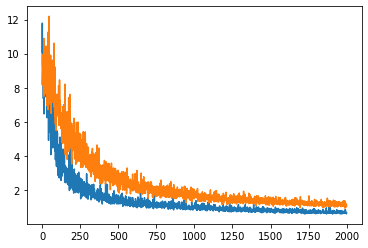

In [11]:
plt.plot(manyLossPMP[:2000])
plt.plot(manyLossSP[:2000])
plt.show()

2. test_acc

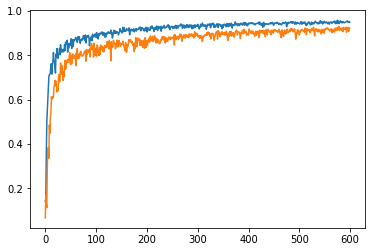

In [12]:
plt.plot(test_accPMP)
plt.plot(test_accSP)
plt.show()

3. train_acc

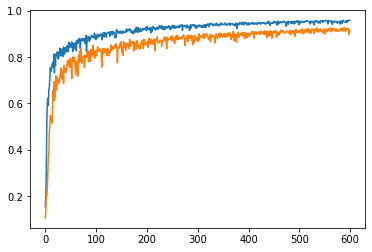

In [13]:
plt.plot(train_accPMP)
plt.plot(train_accSP)
plt.show()

# 加速比计算

In [2]:

manyLossPMP = np.load("./mnist_PMPhmc_loss.npy",allow_pickle=True)
test_accPMP = np.load("./mnist_PMPhmc_test_acc.npy",allow_pickle=True)
train_accPMP = np.load("./mnist_PMPhmc_train_acc.npy",allow_pickle=True)

manyLossSP = np.load("./mnist_SPhmc_loss.npy",allow_pickle=True)
test_accSP = np.load("./mnist_SPhmc_test_acc.npy",allow_pickle=True)
train_accSP = np.load("./mnist_SPhmc_train_acc.npy",allow_pickle=True)

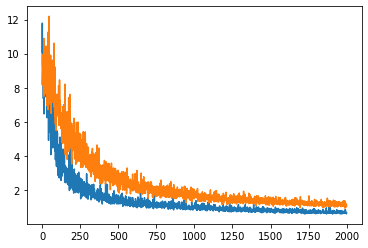

In [4]:
plt.plot(manyLossPMP[:2000])
plt.plot(manyLossSP[:2000])
plt.show()

In [5]:
from scipy.signal import savgol_filter

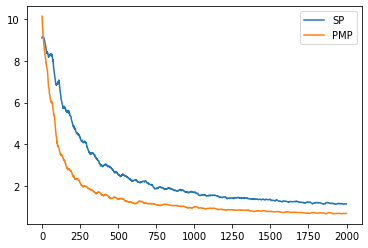

In [28]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


LossSP_fit = savgol_filter(manyLossSP, 51, 3)
LossPMP_fit = savgol_filter(manyLossPMP, 51, 3)
plt.plot(LossSP_fit[:2000],label ="SP")
plt.plot(LossPMP_fit[:2000],label="PMP")
plt.legend()
plt.show()

In [29]:
LossSP_fit.max(),LossSP_fit.min(),LossPMP_fit.max(),LossPMP_fit.min()

(9.171607156749882, 0.2827479020400355, 10.139801776808222, 0.1521887211010971)

In [49]:
beanchmark = np.linspace(8,0.5,1000)

In [50]:
def first(k,loss_array):
    num = 0
    for i in loss_array:
        if k < i:
            num += 1
           
        else:
            break
    return num


    

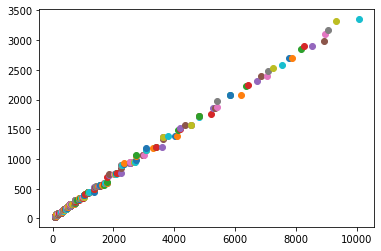

In [52]:
x = []
y = []
for i in beanchmark:
    SP_first = first(i,LossSP_fit)
    x.append(SP_first)
    PMP_first = first(i,LossPMP_fit)
    y.append(PMP_first)
    plt.scatter(SP_first,PMP_first)
plt.show()

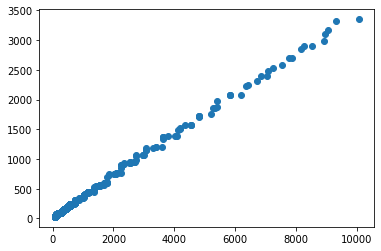

In [57]:
x = np.array(x)
y = np.array(y)
plt.scatter(x,y)

In [60]:
x.shape,y.shape

((1000,), (1000,))

直线拟合函数: p(x)= -41.70311050249167 + 2.862805033772417 *x


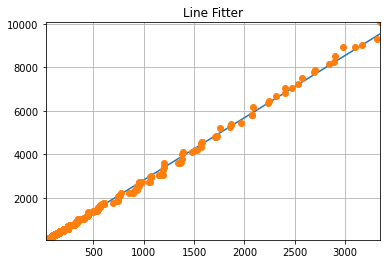

In [70]:
def fitting(x,y):
    n = len(x)
    # 拟合直线:p=a+bx,根据已知的公式求得系数a,b
    a = (np.sum(np.power(x, 2)) * np.sum(y) - np.sum(x) * np.sum(np.multiply(np.array(x), np.array(y)))) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    b = (n * np.sum(np.multiply(np.array(x), np.array(y))) - np.sum(x) * np.sum(y)) / (n * np.sum(np.power(x, 2)) - np.sum(x)**2)
    x_f = np.linspace(min(x) - 1, max(x) + 1, 1000)  # 50等分
    p = a + b * x_f  # 得到拟合直线
    print('直线拟合函数: p(x)=', a, '+', b, '*x')

    # 绘制图像
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_xlim([min(x) - 1, max(x) + 1])  
    ax1.set_ylim([min(y) - 1, max(y) + 1])  
    plt.plot(x_f, p)  # 画出拟合函数
    plt.plot(x, y, 'o') 
    plt.grid()
    plt.title('Line Fitter')
    plt.show()

fitting(y,x)